In [1]:
from src.data.datasets.nuscenes import NuScenesValidationMini
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

2024-05-06 15:28:46.466792: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 15:28:46.472357: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 15:28:46.528652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 15:28:48.150157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nusc_base_kwargs = {
    "label_names": ['car'],
    "data_root": "data/nuscenes",
    "pipeline": [],
    "box_type_3d": "Camera",
    "load_type": 'frame_based',
    "modality": dict(use_camera=True,use_lidar=False),
    "filter_empty_gt": False,
    "test_mode": False,
    "with_velocity": False,
    "use_valid_flag": False,
}

nusc_val = NuScenesValidationMini(**nusc_base_kwargs)

05/06 15:28:55 - mmengine - INFO - ------------------------------
05/06 15:28:55 - mmengine - INFO - The length of training dataset: 486
05/06 15:28:55 - mmengine - INFO - The number of instances per category in the dataset:
+----------------------+--------+
| category             | number |
+----------------------+--------+
| car                  | 2568   |
| truck                | 124    |
| trailer              | 0      |
| bus                  | 41     |
| construction_vehicle | 0      |
| bicycle              | 52     |
| motorcycle           | 259    |
| pedestrian           | 1358   |
| traffic_cone         | 39     |
| barrier              | 0      |
+----------------------+--------+


In [3]:
nusc_item = nusc_val[5]
point_screen = nusc_item.point_screen
patch_center_2d = nusc_item.patch_center_2d
full_img = nusc_item.full_img

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.4036,  1.0645, 63.0810]]])
point_patch_ndc tensor([[-9.5323e-03,  5.9370e-04,  9.9932e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.0413,  0.0026,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0000, 1.0000]])


/n/fs/pci-sharedt/tb21/generative-detection/src/data/datasets/nuscenes.py:384: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch_size_original = torch.tensor(patch_size_original, dtype=torch.float32, requires_grad=False)


In [4]:
nusc_item.keys()

dict_keys(['sample_idx', 'cam_idx', 'cam_name', 'img_path', 'cam2img', 'cam2ego', 'sample_data_token', 'timestamp', 'lidar2cam', 'full_img', 'patch', 'class_id', 'pose_6d', 'bbox_sizes', 'patch_size', 'patch_center_2d', 'point_screen', 'bbox_3d'])

In [5]:
nusc_item.pose_6d, nusc_item.bbox_sizes

(tensor([[-9.5543e-03,  1.0561e-04, -8.6526e+00,  0.0000e+00,  0.0000e+00,
          -1.0230e-01]]),
 tensor([5.0300, 0.3324, 0.3883]))

In [6]:
nusc_item.patch_center_2d, nusc_item.point_screen

(tensor([834.6033, 491.1261]), tensor([[1.7777, 1.0000, 1.0000]]))

point_screen tensor([1.7777, 1.0000])


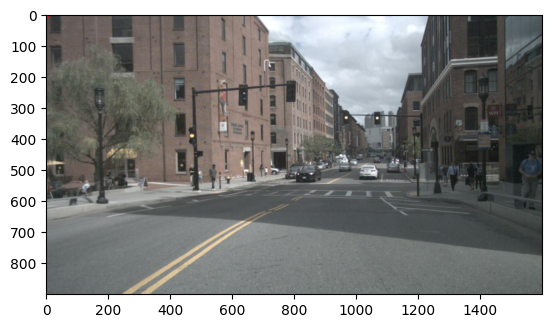

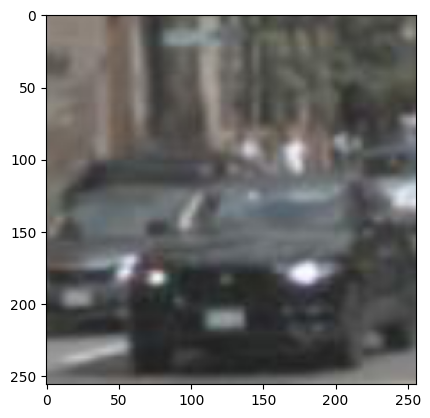

In [7]:
point_screen = nusc_item.point_screen
point_screen = point_screen.squeeze()[:2]
print("point_screen", point_screen)


# plot on full image on the same figure
def plot_points_on_image(points, fig, ax, color='r'):
    ax.scatter(points[0], points[1], c=color, s=1)
    return fig, ax


full_img = nusc_item.full_img
full_img_np = full_img.numpy().transpose(1, 2, 0)
fig, ax = plt.subplots()
ax.imshow(full_img_np)
plot_points_on_image(point_screen, fig, ax, color='r')
# plot_points_on_image(patch_center_2d, fig, ax, color='b')
plt.show()
# plot patch
patch = nusc_item.patch
patch_np = patch.numpy()
patch_np = np.transpose(patch_np, (1, 2, 0))
plt.imshow(patch_np)



In [8]:
nusc_val[5], nusc_val[5].patch_size

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.4036,  1.0645, 63.0810]]])
point_patch_ndc tensor([[-9.5323e-03,  5.9370e-04,  9.9932e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.0413,  0.0026,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.4036,  1.0645, 63.0810]]])
point_patch_ndc tensor([[-9.5323e-03,  5.9370e-04,  9.9932e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.0413,  0.0026,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0000, 1.0000]])


({'sample_idx': 1,
  'cam_idx': 0,
  'cam_name': 'CAM_FRONT',
  'img_path': 'data/nuscenes/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg',
  'cam2img': [[1252.8131021185304, 0.0, 826.588114781398],
   [0.0, 1252.8131021185304, 469.9846626224581],
   [0.0, 0.0, 1.0]],
  'cam2ego': [[0.010260207578539848,
    0.008433448150753975,
    0.9999117851257324,
    1.7220057249069214],
   [-0.9998725652694702,
    0.012316255830228329,
    0.010155927389860153,
    0.004754533059895039],
   [-0.01222951989620924,
    -0.9998885989189148,
    0.008558740839362144,
    1.49491286277771],
   [0.0, 0.0, 0.0, 1.0]],
  'sample_data_token': 'ba01f58b926a472b9d146cb5a54e9a2e',
  'timestamp': 1533151604.012404,
  'lidar2cam': [[0.999883770942688,
    0.012659676373004913,
    -0.008493026718497276,
    9.455266990698874e-05],
   [-0.009169741533696651,
    0.05439155176281929,
    -0.998477578163147,
    -0.35451388359069824],
   [-0.012178453616797924,
    0.9984394311904907,
    0.054

In [9]:
# mark patch_center_2d as red on full image
# idx = 50
import matplotlib.pyplot as plt

for idx in tqdm.tqdm(range(len(nusc_val))):
    full_img = nusc_val[idx].full_img.permute(1,2,0)

    # mark patch_center_2d as red on full image 
    patch_center_2d = nusc_val[idx].patch_center_2d # torch.Size([2])

  0%|          | 0/486 [00:00<?, ?it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])


  0%|          | 1/486 [00:00<01:15,  6.40it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0981,  0.7654, 22.0657]]])
point_patch_ndc tensor([[2.6994e-02, 3.7796e-04, 1.0102e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.1202, 0.0017, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0981,  0.7654, 22.0657]]])
point_patch_ndc tensor([[2.6994e-02, 3.7796e-04, 1.0102e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.1202, 0.0017, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0000, 1.0000]])


  1%|          | 3/486 [00:00<01:17,  6.23it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3467,  0.7467, 18.7883]]])
point_patch_ndc tensor([[-0.0321,  0.0021,  0.9972]])
points_ndc_recovered in nusc dataloader tensor([[-0.1611,  0.0106,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3467,  0.7467, 18.7883]]])
point_patch_ndc tensor([[-0.0321,  0.0021,  0.9972]])
points_ndc_recovered in nusc dataloader tensor([[-0.1611,  0.0106,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3467,  0.7467, 18.7883]]])
point_patch_ndc tensor([[-0.0321,  0.0021,  0.9972]])
points_ndc_recovered in nusc dataloader tensor([[-0.1611,  0.0106,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


  1%|          | 4/486 [00:00<01:15,  6.40it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0981,  0.7654, 22.0657]]])
point_patch_ndc tensor([[2.6994e-02, 3.7796e-04, 1.0102e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.1202, 0.0017, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.4036,  1.0645, 63.0810]]])
point_patch_ndc tensor([[-9.5323e-03,  5.9370e-04,  9.9932e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.0413,  0.0026,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.6471,  1.1880, 39.3370]]])
point_patch_ndc tensor([[-0.0028,  0.0083,  1.0008]])
points_ndc_recovered in nusc dataloader tensor([[-0.0133,  0.0397,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0001, 1.0000]])


  1%|          | 5/486 [00:00<01:18,  6.13it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.6471,  1.1880, 39.3370]]])
point_patch_ndc tensor([[-0.0028,  0.0083,  1.0008]])
points_ndc_recovered in nusc dataloader tensor([[-0.0133,  0.0397,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.2286,  1.1119, 64.3310]]])
point_patch_ndc tensor([[2.5043e-02, 3.6590e-04, 1.0093e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.2537, 0.0037, 1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 1.0000, 1.0000]])


  1%|          | 6/486 [00:00<01:19,  6.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0837,  1.2296, 40.9842]]])
point_patch_ndc tensor([[0.0681, 0.0063, 1.0376]])
points_ndc_recovered in nusc dataloader tensor([[0.4221, 0.0391, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])


  1%|▏         | 7/486 [00:01<01:18,  6.13it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0837,  1.2296, 40.9842]]])
point_patch_ndc tensor([[0.0681, 0.0063, 1.0376]])
points_ndc_recovered in nusc dataloader tensor([[0.4221, 0.0391, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4744,  0.7962, 32.0134]]])
point_patch_ndc tensor([[ 0.0012, -0.0023,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0085, -0.0157,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4744,  0.7962, 32.0134]]])
point_patch_ndc tensor([[ 0.0012, -0.0023,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0085, -0.0157,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 1.0000, 1.0000]])


  2%|▏         | 8/486 [00:01<01:21,  5.89it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4744,  0.7962, 32.0134]]])
point_patch_ndc tensor([[ 0.0012, -0.0023,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0085, -0.0157,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4744,  0.7962, 32.0134]]])
point_patch_ndc tensor([[ 0.0012, -0.0023,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0085, -0.0157,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 1.0000, 1.0000]])


  2%|▏         | 9/486 [00:01<01:20,  5.94it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.5756,  0.8880, 18.6493]]])
point_patch_ndc tensor([[-0.0373,  0.0050,  0.9980]])
points_ndc_recovered in nusc dataloader tensor([[-0.1830,  0.0246,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0001, 1.0000]])


  2%|▏         | 10/486 [00:01<01:20,  5.91it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4744,  0.7962, 32.0134]]])
point_patch_ndc tensor([[ 0.0012, -0.0023,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0085, -0.0157,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.9963,  1.3358, 43.2942]]])
point_patch_ndc tensor([[-0.0368,  0.0081,  1.0036]])
points_ndc_recovered in nusc dataloader tensor([[-0.1875,  0.0415,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.9963,  1.3358, 43.2942]]])
point_patch_ndc tensor([[-0.0368,  0.0081,  1.0036]])
points_ndc_recovered in nusc dataloader tensor([[-0.1875,  0.0415,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0001, 1.0000]])


  2%|▏         | 12/486 [00:01<01:18,  6.03it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3656,  1.1969, 58.8624]]])
point_patch_ndc tensor([[-0.0302,  0.0030,  1.0005]])
points_ndc_recovered in nusc dataloader tensor([[-0.1237,  0.0122,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.6917,  1.1751, 56.2671]]])
point_patch_ndc tensor([[0.0201, 0.0016, 1.0060]])
points_ndc_recovered in nusc dataloader tensor([[0.1731, 0.0137, 1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4561,  1.2829, 40.1558]]])
point_patch_ndc tensor([[0.0606, 0.0069, 1.0316]])
points_ndc_recovered in nusc dataloader tensor([[0.3885, 0.0445, 1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0001, 1.0000]])


  3%|▎         | 13/486 [00:02<01:13,  6.43it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3656,  1.1969, 58.8624]]])
point_patch_ndc tensor([[-0.0302,  0.0030,  1.0005]])
points_ndc_recovered in nusc dataloader tensor([[-0.1237,  0.0122,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.0663,  0.7548, 41.9095]]])
point_patch_ndc tensor([[-0.0092, -0.0031,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.0833, -0.0279,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])


  3%|▎         | 14/486 [00:02<01:12,  6.49it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.0663,  0.7548, 41.9095]]])
point_patch_ndc tensor([[-0.0092, -0.0031,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.0833, -0.0279,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])


  3%|▎         | 15/486 [00:02<01:10,  6.69it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9052,  0.8220, 18.4877]]])
point_patch_ndc tensor([[-0.0439,  0.0039,  0.9987]])
points_ndc_recovered in nusc dataloader tensor([[-0.2151,  0.0190,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9052,  0.8220, 18.4877]]])
point_patch_ndc tensor([[-0.0439,  0.0039,  0.9987]])
points_ndc_recovered in nusc dataloader tensor([[-0.2151,  0.0190,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9052,  0.8220, 18.4877]]])
point_patch_ndc tensor([[-0.0439,  0.0039,  0.9987]])
points_ndc_recovered in nusc dataloader tensor([[-0.2151,  0.0190,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_

  3%|▎         | 16/486 [00:02<01:07,  7.00it/s]

point_camera in nusc dataloader tensor([[[ 1.0663,  0.7548, 41.9095]]])
point_patch_ndc tensor([[-0.0092, -0.0031,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.0833, -0.0279,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.1048,  0.3990, 54.6222]]])
point_patch_ndc tensor([[-0.0583, -0.0065,  1.0054]])
points_ndc_recovered in nusc dataloader tensor([[-0.2173, -0.0241,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9999, 1.0000]])


  3%|▎         | 17/486 [00:02<01:08,  6.82it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.6921,  0.1880, 68.4387]]])
point_patch_ndc tensor([[-0.0093, -0.0039,  0.9995]])
points_ndc_recovered in nusc dataloader tensor([[-0.0872, -0.0368,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])


  4%|▎         | 18/486 [00:02<01:08,  6.87it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.6921,  0.1880, 68.4387]]])
point_patch_ndc tensor([[-0.0093, -0.0039,  0.9995]])
points_ndc_recovered in nusc dataloader tensor([[-0.0872, -0.0368,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.6921,  0.1880, 68.4387]]])
point_patch_ndc tensor([[-0.0093, -0.0039,  0.9995]])
points_ndc_recovered in nusc dataloader tensor([[-0.0872, -0.0368,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.6552,  0.9105, 22.7017]]])
point_patch_ndc tensor([[-0.1518,  0.0265,  1.0446]])
points_ndc_recovered in nusc dataloader tensor([[-0.3847,  0.0673,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0001, 1.0000]])


  4%|▍         | 19/486 [00:02<01:06,  7.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.6921,  0.1880, 68.4387]]])
point_patch_ndc tensor([[-0.0093, -0.0039,  0.9995]])
points_ndc_recovered in nusc dataloader tensor([[-0.0872, -0.0368,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.8535,  1.4777, 51.7780]]])
point_patch_ndc tensor([[-1.3289e-02, -7.7618e-04,  9.9860e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.1576, -0.0092,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


  4%|▍         | 20/486 [00:03<01:05,  7.14it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.8535,  1.4777, 51.7780]]])
point_patch_ndc tensor([[-1.3289e-02, -7.7618e-04,  9.9860e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.1576, -0.0092,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


  4%|▍         | 21/486 [00:03<01:00,  7.62it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.8535,  1.4777, 51.7780]]])
point_patch_ndc tensor([[-1.3289e-02, -7.7618e-04,  9.9860e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.1576, -0.0092,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.1486,  1.0768, 18.4112]]])
point_patch_ndc tensor([[-0.0499,  0.0092,  1.0006]])
points_ndc_recovered in nusc dataloader tensor([[-0.2389,  0.0438,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.1486,  1.0768, 18.4112]]])
point_patch_ndc tensor([[-0.0499,  0.0092,  1.0006]])
points_ndc_recovered in nusc dataloader tensor([[-0.2389,  0.0438,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cp

  5%|▍         | 23/486 [00:03<00:53,  8.64it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.1796, -0.0842, 40.4586]]])
point_patch_ndc tensor([[ 0.0444, -0.0075,  1.0182]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2973, -0.0502,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.1164,  -0.0509,  49.6606]]])
point_patch_ndc tensor([[-0.1791, -0.0135,  1.0904]])
points_ndc_recovered in nusc dataloader tensor([[-0.6262, -0.0473,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.1282, -0.4896, 48.2655]]])
point_patch_ndc tensor([[ 0.0669, -0.0104,  1.0390]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4674, -0.0727,  1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 0.9998, 1.0000]])
point_ndc device cpu
ndc2pat

  5%|▌         | 25/486 [00:03<00:49,  9.29it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2266,  1.2796, 18.5881]]])
point_patch_ndc tensor([[-0.0502,  0.0127,  1.0017]])
points_ndc_recovered in nusc dataloader tensor([[-0.2452,  0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu


  5%|▌         | 26/486 [00:03<00:49,  9.33it/s]

point_camera in nusc dataloader tensor([[[-1.2266,  1.2796, 18.5881]]])
point_patch_ndc tensor([[-0.0502,  0.0127,  1.0017]])
points_ndc_recovered in nusc dataloader tensor([[-0.2452,  0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2266,  1.2796, 18.5881]]])
point_patch_ndc tensor([[-0.0502,  0.0127,  1.0017]])
points_ndc_recovered in nusc dataloader tensor([[-0.2452,  0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2266,  1.2796, 18.5881]]])
point_patch_ndc tensor([[-0.0502,  0.0127,  1.0017]])
points_ndc_recovered in nusc dataloader tensor([[-0.2452,  0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader

  6%|▌         | 29/486 [00:04<00:47,  9.63it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.4401, -2.1774, 66.3992]]])
point_patch_ndc tensor([[ 1.1526e-04, -1.2070e-02,  1.0006e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0013, -0.1357,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9299, -0.9323, 44.1349]]])
point_patch_ndc tensor([[ 0.0693, -0.0162,  1.0390]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4411, -0.1032,  1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu


  6%|▌         | 30/486 [00:04<00:47,  9.69it/s]

point_camera in nusc dataloader tensor([[[-5.7464, -0.9241, 45.9533]]])
point_patch_ndc tensor([[-0.1335, -0.0329,  1.0390]])
points_ndc_recovered in nusc dataloader tensor([[-0.4072, -0.1004,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9299, -0.9323, 44.1349]]])
point_patch_ndc tensor([[ 0.0693, -0.0162,  1.0390]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4411, -0.1032,  1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


  6%|▋         | 31/486 [00:04<00:49,  9.25it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2179,  1.3758, 19.2167]]])
point_patch_ndc tensor([[-0.0493,  0.0137,  1.0018]])
points_ndc_recovered in nusc dataloader tensor([[-0.2406,  0.0670,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.3645, -0.6960, 39.7223]]])
point_patch_ndc tensor([[ 0.0378, -0.0143,  1.0139]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2468, -0.0932,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2179,  1.3758, 19.2167]]])
point_patch_ndc tensor([[-0.0493,  0.0137,  1.0018]])
points_ndc_recovered in nusc dataloader tensor([

  7%|▋         | 32/486 [00:04<00:49,  9.16it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2179,  1.3758, 19.2167]]])
point_patch_ndc tensor([[-0.0493,  0.0137,  1.0018]])
points_ndc_recovered in nusc dataloader tensor([[-0.2406,  0.0670,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2179,  1.3758, 19.2167]]])
point_patch_ndc tensor([[-0.0493,  0.0137,  1.0018]])
points_ndc_recovered in nusc dataloader tensor([[-0.2406,  0.0670,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])


  7%|▋         | 34/486 [00:04<00:46,  9.73it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2179,  1.3758, 19.2167]]])
point_patch_ndc tensor([[-0.0493,  0.0137,  1.0018]])
points_ndc_recovered in nusc dataloader tensor([[-0.2406,  0.0670,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2179,  1.3758, 19.2167]]])
point_patch_ndc tensor([[-0.0493,  0.0137,  1.0018]])
points_ndc_recovered in nusc dataloader tensor([[-0.2406,  0.0670,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0001, 1.0000]])


  7%|▋         | 35/486 [00:04<00:47,  9.58it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.0287,  0.0567, 41.4874]]])
point_patch_ndc tensor([[-0.2017, -0.0154,  1.0825]])
points_ndc_recovered in nusc dataloader tensor([[-0.5308, -0.0406,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.3876, -0.2007, 40.1253]]])
point_patch_ndc tensor([[ 0.0268, -0.0089,  1.0076]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1760, -0.0583,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9999, 1.0000]])


  7%|▋         | 36/486 [00:04<00:46,  9.67it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.0287,  0.0567, 41.4874]]])
point_patch_ndc tensor([[-0.2017, -0.0154,  1.0825]])
points_ndc_recovered in nusc dataloader tensor([[-0.5308, -0.0406,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.3876, -0.2007, 40.1253]]])
point_patch_ndc tensor([[ 0.0268, -0.0089,  1.0076]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1760, -0.0583,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9999, 1.0000]])


  8%|▊         | 37/486 [00:04<00:48,  9.21it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4748, -0.1664, 40.1178]]])
point_patch_ndc tensor([[ 0.0700, -0.0100,  1.0353]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3902, -0.0560,  1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.0982, -0.2858, 55.3397]]])
point_patch_ndc tensor([[-0.0510, -0.0082,  1.0124]])
points_ndc_recovered in nusc dataloader tensor([[-0.3659, -0.0588,  1.0000]])
point_screen in nusc dataloader tensor([[1.7770, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.7491,  0.4118, 36.9318]]])
point_patch_ndc tensor([[-0.2973, -0.0062,  1.1557]])
points_ndc_recovered in nusc dataloader tensor([

  8%|▊         | 38/486 [00:05<00:57,  7.75it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3424,  0.8328, 20.4698]]])
point_patch_ndc tensor([[-0.0500,  0.0025,  0.9997]])
points_ndc_recovered in nusc dataloader tensor([[-0.2445,  0.0123,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.7491,  0.4118, 36.9318]]])
point_patch_ndc tensor([[-0.2973, -0.0062,  1.1557]])
points_ndc_recovered in nusc dataloader tensor([[-0.6432, -0.0134,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3424,  0.8328, 20.4698]]])
point_patch_ndc tensor([[-0.0500,  0.0025,  0.9997]])
points_ndc_recovered in nusc dataloader tensor([

  8%|▊         | 39/486 [00:05<01:02,  7.12it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3424,  0.8328, 20.4698]]])
point_patch_ndc tensor([[-0.0500,  0.0025,  0.9997]])
points_ndc_recovered in nusc dataloader tensor([[-0.2445,  0.0123,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])


  8%|▊         | 40/486 [00:05<01:01,  7.27it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3424,  0.8328, 20.4698]]])
point_patch_ndc tensor([[-0.0500,  0.0025,  0.9997]])
points_ndc_recovered in nusc dataloader tensor([[-0.2445,  0.0123,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.2173,  0.7447, 12.6721]]])
point_patch_ndc tensor([[-0.9178,  0.1428,  1.6242]])
points_ndc_recovered in nusc dataloader tensor([[-0.7659,  0.1192,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0003, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


  8%|▊         | 41/486 [00:05<01:04,  6.87it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.2173,  0.7447, 12.6721]]])
point_patch_ndc tensor([[-0.9178,  0.1428,  1.6242]])
points_ndc_recovered in nusc dataloader tensor([[-0.7659,  0.1192,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0003, 1.0000]])


  9%|▊         | 42/486 [00:05<01:05,  6.78it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.8491,   0.7934,  35.6941]]])
point_patch_ndc tensor([[-0.8186,  0.0126,  1.8373]])
points_ndc_recovered in nusc dataloader tensor([[-1.1393,  0.0175,  1.0000]])
point_screen in nusc dataloader tensor([[1.7752, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.3103,  0.2268, 50.7509]]])
point_patch_ndc tensor([[-0.0712, -0.0049,  1.0241]])
points_ndc_recovered in nusc dataloader tensor([[-0.4601, -0.0320,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.5842,  0.0940, 40.2989]]])
point_patch_ndc tensor([[ 0.0181, -0.0058,  1.0040]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1194, -0.0379,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])


  9%|▉         | 43/486 [00:05<01:03,  6.98it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.1283, -0.6989, 67.3785]]])
point_patch_ndc tensor([[ 0.0198, -0.0053,  1.0078]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2768, -0.0733,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.3372, -0.2785, 27.5366]]])
point_patch_ndc tensor([[ 1.3153, -0.0283,  3.0985]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5160, -0.0326,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9999, 1.0000]])


  9%|▉         | 44/486 [00:05<01:02,  7.09it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.3372, -0.2785, 27.5366]]])
point_patch_ndc tensor([[ 1.3153, -0.0283,  3.0985]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5160, -0.0326,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


  9%|▉         | 45/486 [00:06<01:03,  6.98it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.5236,  0.5523, 12.3740]]])
point_patch_ndc tensor([[0.2522, 0.0129, 1.1614]])
points_ndc_recovered in nusc dataloader tensor([[0.3759, 0.0193, 1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.5236,  0.5523, 12.3740]]])
point_patch_ndc tensor([[0.2522, 0.0129, 1.1614]])
points_ndc_recovered in nusc dataloader tensor([[0.3759, 0.0193, 1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2498,  0.5266, 21.9742]]])
point_patch_ndc tensor([[-0.0447, -0.0034,  0.9984]])
points_ndc_recovered in nusc dataloader tensor([[-0.2291, -0.0173,  1.0000]])
point_screen in nusc dataloader tensor([[1.777

  9%|▉         | 46/486 [00:06<01:01,  7.15it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.2498,  0.5266, 21.9742]]])
point_patch_ndc tensor([[-0.0447, -0.0034,  0.9984]])
points_ndc_recovered in nusc dataloader tensor([[-0.2291, -0.0173,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.0281,   0.7411,  19.1625]]])
point_patch_ndc tensor([[ 265.3850,  -12.7559, -410.0004]])
points_ndc_recovered in nusc dataloader tensor([[-1.6550,  0.0795,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 1.0002, 1.0000]])


 10%|▉         | 47/486 [00:06<01:02,  6.98it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.0281,   0.7411,  19.1625]]])
point_patch_ndc tensor([[ 265.3850,  -12.7559, -410.0004]])
points_ndc_recovered in nusc dataloader tensor([[-1.6550,  0.0795,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 1.0002, 1.0000]])


 10%|▉         | 48/486 [00:06<01:01,  7.10it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-14.1672,   0.1992,  28.2238]]])
point_patch_ndc tensor([[-0.8895, -0.0051,  2.1898]])
points_ndc_recovered in nusc dataloader tensor([[-1.4507, -0.0083,  1.0000]])
point_screen in nusc dataloader tensor([[1.7746, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.0281,   0.7411,  19.1625]]])
point_patch_ndc tensor([[ 265.3850,  -12.7559, -410.0004]])
points_ndc_recovered in nusc dataloader tensor([[-1.6550,  0.0795,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.0096,  0.9704, 31.4701]]])
point_patch_ndc tensor([[0.0968, 0.0104, 1.0500]])
points_ndc_recovered in nusc dataloader tensor([[0.3841, 0.0414, 1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0001, 1.0000]])


 10%|█         | 49/486 [00:06<01:00,  7.20it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.0992,  0.9600, 46.4965]]])
point_patch_ndc tensor([[-0.0350,  0.0019,  1.0046]])
points_ndc_recovered in nusc dataloader tensor([[-0.2447,  0.0131,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[17.6652,  1.3740, 29.1690]]])
point_patch_ndc tensor([[2.3588, 0.1873, 5.1609]])
points_ndc_recovered in nusc dataloader tensor([[1.6323, 0.1296, 1.0000]])
point_screen in nusc dataloader tensor([[1.7814, 1.0003, 1.0000]])


 10%|█         | 50/486 [00:06<01:02,  6.99it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.5584,  1.1181, 14.9115]]])
point_patch_ndc tensor([[-3.6607, -0.4389, -5.8736]])
points_ndc_recovered in nusc dataloader tensor([[1.7312, 0.2076, 1.0000]])
point_screen in nusc dataloader tensor([[1.7816, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 10%|█         | 51/486 [00:06<01:02,  6.91it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.1559, -0.0311, 23.8675]]])
point_patch_ndc tensor([[-0.0370, -0.0107,  0.9978]])
points_ndc_recovered in nusc dataloader tensor([[-0.2142, -0.0621,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.6799, -0.0305, 21.7764]]])
point_patch_ndc tensor([[ 0.0241, -0.0167,  1.0074]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0895, -0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.6799, -0.0305, 21.7764]]])
point_patch_ndc tensor([[ 0.0241, -0.0167,  1.0074]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0895, -0.0622,  1.0000]])
point_screen in nusc dataloader te

 11%|█         | 52/486 [00:07<01:01,  7.10it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.6799, -0.0305, 21.7764]]])
point_patch_ndc tensor([[ 0.0241, -0.0167,  1.0074]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0895, -0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.3905,   0.4984,  29.7354]]])
point_patch_ndc tensor([[-0.2958,  0.0054,  1.2709]])
points_ndc_recovered in nusc dataloader tensor([[-1.0270,  0.0187,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 1.0000, 1.0000]])


 11%|█         | 53/486 [00:07<01:02,  6.98it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.1210,  0.8179, 20.7463]]])
point_patch_ndc tensor([[-0.3724,  0.0301,  1.3381]])
points_ndc_recovered in nusc dataloader tensor([[-1.0098,  0.0816,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 1.0002, 1.0000]])


 11%|█         | 54/486 [00:07<01:00,  7.12it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.1210,  0.8179, 20.7463]]])
point_patch_ndc tensor([[-0.3724,  0.0301,  1.3381]])
points_ndc_recovered in nusc dataloader tensor([[-1.0098,  0.0816,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.1210,  0.8179, 20.7463]]])
point_patch_ndc tensor([[-0.3724,  0.0301,  1.3381]])
points_ndc_recovered in nusc dataloader tensor([[-1.0098,  0.0816,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.4370,  1.1026, 39.7694]]])
point_patch_ndc tensor([[-0.0511,  0.0056,  1.0100]])
points_ndc_recovered in nusc dataloader tensor([[-0.2997,  0.0328,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_

 11%|█▏        | 55/486 [00:07<00:59,  7.24it/s]

point_camera in nusc dataloader tensor([[[-14.1566,   1.4100,  26.5487]]])
point_patch_ndc tensor([[ 3.6732, -0.2462, -4.2833]])
points_ndc_recovered in nusc dataloader tensor([[-1.5436,  0.1035,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.7833,  1.0732, 12.4338]]])
point_patch_ndc tensor([[-1.7627, -0.3402, -1.4813]])
points_ndc_recovered in nusc dataloader tensor([[1.2396, 0.2392, 1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0005, 1.0000]])


 12%|█▏        | 56/486 [00:07<01:01,  6.96it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.7833,  1.0732, 12.4338]]])
point_patch_ndc tensor([[-1.7627, -0.3402, -1.4813]])
points_ndc_recovered in nusc dataloader tensor([[1.2396, 0.2392, 1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0005, 1.0000]])


 12%|█▏        | 57/486 [00:07<01:01,  7.01it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.7833,  1.0732, 12.4338]]])
point_patch_ndc tensor([[-1.7627, -0.3402, -1.4813]])
points_ndc_recovered in nusc dataloader tensor([[1.2396, 0.2392, 1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.7833,  1.0732, 12.4338]]])
point_patch_ndc tensor([[-1.7627, -0.3402, -1.4813]])
points_ndc_recovered in nusc dataloader tensor([[1.2396, 0.2392, 1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.0050, -0.0600, 26.0090]]])
point_patch_ndc tensor([[-0.0288, -0.0093,  0.9978]])
points_ndc_recovered in nusc dataloader tensor([[-0.1968, -0.0638,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9999, 1.0000]])


 12%|█▏        | 58/486 [00:07<00:59,  7.19it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.0050, -0.0600, 26.0090]]])
point_patch_ndc tensor([[-0.0288, -0.0093,  0.9978]])
points_ndc_recovered in nusc dataloader tensor([[-0.1968, -0.0638,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.3208,  0.5623, 31.4066]]])
point_patch_ndc tensor([[-0.1822,  0.0065,  1.0921]])
points_ndc_recovered in nusc dataloader tensor([[-0.6154,  0.0218,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 12%|█▏        | 59/486 [00:08<01:00,  7.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.0989,  0.8892, 22.3614]]])
point_patch_ndc tensor([[-0.1574,  0.0294,  1.0558]])
points_ndc_recovered in nusc dataloader tensor([[-0.4413,  0.0826,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 1.0002, 1.0000]])


 12%|█▏        | 60/486 [00:08<00:59,  7.19it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.0989,  0.8892, 22.3614]]])
point_patch_ndc tensor([[-0.1574,  0.0294,  1.0558]])
points_ndc_recovered in nusc dataloader tensor([[-0.4413,  0.0826,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.3208,  0.5623, 31.4066]]])
point_patch_ndc tensor([[-0.1822,  0.0065,  1.0921]])
points_ndc_recovered in nusc dataloader tensor([[-0.6154,  0.0218,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.4533,  0.7534, 34.9249]]])
point_patch_ndc tensor([[-0.0694,  0.0032,  1.0153]])
points_ndc_recovered in nusc dataloader tensor([[-0.3344,  0.0156,  1.0000]])
point_screen in nusc dataloader tensor([[1.7770, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_

 13%|█▎        | 61/486 [00:08<00:58,  7.30it/s]

point_camera in nusc dataloader tensor([[[ 4.7912,  0.7677, 22.5567]]])
point_patch_ndc tensor([[0.2258, 0.0214, 1.1498]])
points_ndc_recovered in nusc dataloader tensor([[0.5323, 0.0503, 1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.2124,  0.9740, 10.0036]]])
point_patch_ndc tensor([[1.9895, 0.9636, 2.6146]])
points_ndc_recovered in nusc dataloader tensor([[0.5577, 0.2701, 1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0006, 1.0000]])


 13%|█▎        | 62/486 [00:08<01:00,  6.95it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.2124,  0.9740, 10.0036]]])
point_patch_ndc tensor([[1.9895, 0.9636, 2.6146]])
points_ndc_recovered in nusc dataloader tensor([[0.5577, 0.2701, 1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0006, 1.0000]])


 13%|█▎        | 63/486 [00:08<01:00,  7.03it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.2124,  0.9740, 10.0036]]])
point_patch_ndc tensor([[1.9895, 0.9636, 2.6146]])
points_ndc_recovered in nusc dataloader tensor([[0.5577, 0.2701, 1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.2646,  1.2653, 24.2634]]])
point_patch_ndc tensor([[4.0686, 0.5212, 6.1346]])
points_ndc_recovered in nusc dataloader tensor([[1.1220, 0.1437, 1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.6610,  0.2940, 28.1675]]])
point_patch_ndc tensor([[-0.0226, -0.0055,  0.9976]])
points_ndc_recovered in nusc dataloader tensor([[-0.1700, -0.0413,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform de

 13%|█▎        | 64/486 [00:08<00:58,  7.21it/s]

point_camera in nusc dataloader tensor([[[-0.6610,  0.2940, 28.1675]]])
point_patch_ndc tensor([[-0.0226, -0.0055,  0.9976]])
points_ndc_recovered in nusc dataloader tensor([[-0.1700, -0.0413,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.0879,  0.8014, 24.0064]]])
point_patch_ndc tensor([[0.0268, 0.0250, 1.0079]])
points_ndc_recovered in nusc dataloader tensor([[0.0695, 0.0648, 1.0000]])
point_screen in nusc dataloader tensor([[1.7779, 1.0001, 1.0000]])


 13%|█▎        | 65/486 [00:08<00:59,  7.08it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.0879,  0.8014, 24.0064]]])
point_patch_ndc tensor([[0.0268, 0.0250, 1.0079]])
points_ndc_recovered in nusc dataloader tensor([[0.0695, 0.0648, 1.0000]])
point_screen in nusc dataloader tensor([[1.7779, 1.0001, 1.0000]])


 14%|█▎        | 66/486 [00:09<00:58,  7.23it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0943,  0.4024, 33.0627]]])
point_patch_ndc tensor([[-0.0708,  0.0018,  1.0086]])
points_ndc_recovered in nusc dataloader tensor([[-0.2323,  0.0059,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0943,  0.4024, 33.0627]]])
point_patch_ndc tensor([[-0.0708,  0.0018,  1.0086]])
points_ndc_recovered in nusc dataloader tensor([[-0.2323,  0.0059,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.2715, -0.0446, 43.5847]]])
point_patch_ndc tensor([[ 0.0119, -0.0065,  1.0022]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0860, -0.0473,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_

 14%|█▍        | 67/486 [00:09<00:57,  7.35it/s]

point_camera in nusc dataloader tensor([[[17.0353, -0.8063, 55.3293]]])
point_patch_ndc tensor([[ 0.1179, -0.0126,  1.1080]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7981, -0.0850,  1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.5597,  1.1091, 22.9943]]])
point_patch_ndc tensor([[0.0342, 0.0060, 1.0146]])
points_ndc_recovered in nusc dataloader tensor([[0.1458, 0.0257, 1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 1.0001, 1.0000]])


 14%|█▍        | 68/486 [00:09<00:59,  7.04it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.8495,  1.1596, 30.4209]]])
point_patch_ndc tensor([[0.3118, 0.0493, 1.2491]])
points_ndc_recovered in nusc dataloader tensor([[0.6607, 0.1045, 1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 1.0002, 1.0000]])


 14%|█▍        | 69/486 [00:09<00:58,  7.12it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1147,  1.1582, 21.9614]]])
point_patch_ndc tensor([[1.1321, 0.1948, 2.1228]])
points_ndc_recovered in nusc dataloader tensor([[0.8450, 0.1454, 1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1147,  1.1582, 21.9614]]])
point_patch_ndc tensor([[1.1321, 0.1948, 2.1228]])
points_ndc_recovered in nusc dataloader tensor([[0.8450, 0.1454, 1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.5597,  1.1091, 22.9943]]])
point_patch_ndc tensor([[0.0342, 0.0060, 1.0146]])
points_ndc_recovered in nusc dataloader tensor([[0.1458, 0.0257, 1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device c

 14%|█▍        | 70/486 [00:09<00:57,  7.29it/s]

point_camera in nusc dataloader tensor([[[ 3.5597,  1.1091, 22.9943]]])
point_patch_ndc tensor([[0.0342, 0.0060, 1.0146]])
points_ndc_recovered in nusc dataloader tensor([[0.1458, 0.0257, 1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.7498,  0.8317, 25.4209]]])
point_patch_ndc tensor([[0.2156, 0.0294, 1.1275]])
points_ndc_recovered in nusc dataloader tensor([[0.4626, 0.0630, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 15%|█▍        | 71/486 [00:09<00:58,  7.14it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.7498,  0.8317, 25.4209]]])
point_patch_ndc tensor([[0.2156, 0.0294, 1.1275]])
points_ndc_recovered in nusc dataloader tensor([[0.4626, 0.0630, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0001, 1.0000]])


 15%|█▍        | 72/486 [00:09<00:57,  7.24it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.7498,  0.8317, 25.4209]]])
point_patch_ndc tensor([[0.2156, 0.0294, 1.1275]])
points_ndc_recovered in nusc dataloader tensor([[0.4626, 0.0630, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.7498,  0.8317, 25.4209]]])
point_patch_ndc tensor([[0.2156, 0.0294, 1.1275]])
points_ndc_recovered in nusc dataloader tensor([[0.4626, 0.0630, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.6320,  0.6300, 15.4009]]])
point_patch_ndc tensor([[0.8661, 0.0773, 1.7887]])
points_ndc_recovered in nusc dataloader tensor([[0.7782, 0.0695, 1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device c

 15%|█▌        | 73/486 [00:09<00:56,  7.34it/s]

point_camera in nusc dataloader tensor([[[-8.0783,  0.4144, 36.5338]]])
point_patch_ndc tensor([[-0.1888, -0.0036,  1.1048]])
points_ndc_recovered in nusc dataloader tensor([[-0.6747, -0.0128,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.4375,  0.7039, 31.4991]]])
point_patch_ndc tensor([[-0.0183, -0.0024,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1530, -0.0202,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


 15%|█▌        | 74/486 [00:10<00:58,  7.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.3958,  1.2315, 20.0573]]])
point_patch_ndc tensor([[0.4978, 0.1529, 1.3617]])
points_ndc_recovered in nusc dataloader tensor([[0.5521, 0.1696, 1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 15%|█▌        | 75/486 [00:10<00:59,  6.94it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.4375,  0.7039, 31.4991]]])
point_patch_ndc tensor([[-0.0183, -0.0024,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1530, -0.0202,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0584,  0.8358, 31.1184]]])
point_patch_ndc tensor([[ 0.0071, -0.0019,  1.0019]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0456, -0.0122,  1.0000]])
point_screen in nusc dataloader tensor([[1.7779, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0584,  0.8358, 31.1184]]])
point_patch_ndc tensor([[ 0.0071, -0.0019,  1.0019]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0456, -0.0122,  1.0000]])
point_screen in nusc dataloader te

 16%|█▌        | 76/486 [00:10<00:57,  7.12it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0584,  0.8358, 31.1184]]])
point_patch_ndc tensor([[ 0.0071, -0.0019,  1.0019]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0456, -0.0122,  1.0000]])
point_screen in nusc dataloader tensor([[1.7779, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.5946,  0.9570, 27.8613]]])
point_patch_ndc tensor([[-0.4282,  0.0239,  1.3458]])
points_ndc_recovered in nusc dataloader tensor([[-0.9179,  0.0512,  1.0000]])
point_screen in nusc dataloader tensor([[1.7757, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 16%|█▌        | 77/486 [00:10<01:00,  6.79it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.9962, -0.0415, 31.3246]]])
point_patch_ndc tensor([[ 0.5672, -0.0249,  1.6877]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0960, -0.0481,  1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 0.9999, 1.0000]])


 16%|█▌        | 78/486 [00:10<01:00,  6.78it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.7292, -0.5956, 55.6327]]])
point_patch_ndc tensor([[ 0.1579, -0.0151,  1.1413]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7781, -0.0742,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9126, -0.4686, 84.7249]]])
point_patch_ndc tensor([[ 0.0135, -0.0040,  1.0042]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2009, -0.0598,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9126, -0.4686, 84.7249]]])
point_patch_ndc tensor([[ 0.0135, -0.0040,  1.0042]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2009, -0.0598,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9999, 1.0000]])


 16%|█▋        | 79/486 [00:10<00:58,  6.97it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.7950,  0.6482, 24.6582]]])
point_patch_ndc tensor([[-0.1633,  0.0096,  1.0615]])
points_ndc_recovered in nusc dataloader tensor([[-0.4876,  0.0288,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1145,  1.2486, 22.9491]]])
point_patch_ndc tensor([[-0.0358,  0.0720,  1.0094]])
points_ndc_recovered in nusc dataloader tensor([[-0.0745,  0.1501,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 1.0003, 1.0000]])


 16%|█▋        | 80/486 [00:11<00:59,  6.82it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.5702,  1.2505, 18.8878]]])
point_patch_ndc tensor([[0.2469, 0.1413, 1.1353]])
points_ndc_recovered in nusc dataloader tensor([[0.3198, 0.1830, 1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 1.0004, 1.0000]])


 17%|█▋        | 81/486 [00:11<00:58,  6.92it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.2251,  1.3247, 27.3811]]])
point_patch_ndc tensor([[0.1117, 0.0554, 1.0512]])
points_ndc_recovered in nusc dataloader tensor([[0.2687, 0.1332, 1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1145,  1.2486, 22.9491]]])
point_patch_ndc tensor([[-0.0358,  0.0720,  1.0094]])
points_ndc_recovered in nusc dataloader tensor([[-0.0745,  0.1501,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.4212,  0.7132, 32.7128]]])
point_patch_ndc tensor([[-0.0168, -0.0023,  0.9980]])
points_ndc_recovered in nusc dataloader tensor([[-0.1512, -0.0211,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


 17%|█▋        | 82/486 [00:11<00:56,  7.10it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.4212,  0.7132, 32.7128]]])
point_patch_ndc tensor([[-0.0168, -0.0023,  0.9980]])
points_ndc_recovered in nusc dataloader tensor([[-0.1512, -0.0211,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.5548,  0.6458, 13.2489]]])
point_patch_ndc tensor([[ 2.1553, -0.1605, -1.4174]])
points_ndc_recovered in nusc dataloader tensor([[-1.2263,  0.0913,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.6983, -0.6747, 53.5566]]])
point_patch_ndc tensor([[ 0.1756, -0.0172,  1.1626]])
points_ndc_recovered in nusc dataloader tensor([

 17%|█▋        | 84/486 [00:11<00:59,  6.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.6871, -0.9037, 54.3418]]])
point_patch_ndc tensor([[ 0.2251, -0.0215,  1.2404]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9495, -0.0907,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.6871, -0.9037, 54.3418]]])
point_patch_ndc tensor([[ 0.2251, -0.0215,  1.2404]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9495, -0.0907,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.7062, -0.4984, 47.8802]]])
point_patch_ndc tensor([[ 0.1774, -0.0143,  1.1826]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9123, -0.0734,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9998, 1.0000]])


 17%|█▋        | 85/486 [00:11<00:58,  6.91it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.5217,  0.6343, 11.3053]]])
point_patch_ndc tensor([[-4.1450, -0.4394, -3.9485]])
points_ndc_recovered in nusc dataloader tensor([[1.0544, 0.1118, 1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.8875,  1.3056, 17.6717]]])
point_patch_ndc tensor([[0.0585, 0.1498, 1.0430]])
points_ndc_recovered in nusc dataloader tensor([[0.0799, 0.2045, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 18%|█▊        | 86/486 [00:11<00:59,  6.75it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.5227,  1.5114, 30.1198]]])
point_patch_ndc tensor([[-0.1102,  0.0517,  1.0265]])
points_ndc_recovered in nusc dataloader tensor([[-0.2947,  0.1382,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 1.0003, 1.0000]])


 18%|█▊        | 87/486 [00:12<00:58,  6.86it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.8875,  1.3056, 17.6717]]])
point_patch_ndc tensor([[0.0585, 0.1498, 1.0430]])
points_ndc_recovered in nusc dataloader tensor([[0.0799, 0.2045, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.8367,  1.3516, 21.7755]]])
point_patch_ndc tensor([[-0.1495,  0.0865,  1.0414]])
points_ndc_recovered in nusc dataloader tensor([[-0.2963,  0.1715,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3245,  0.8421, 33.1910]]])
point_patch_ndc tensor([[-0.0162, -0.0016,  0.9980]])
points_ndc_recovered in nusc dataloader tensor([[-0.1457, -0.0148,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0000, 1.0000]])


 18%|█▊        | 88/486 [00:12<00:56,  7.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.6465,  0.5770, 44.3331]]])
point_patch_ndc tensor([[-0.0069, -0.0041,  0.9983]])
points_ndc_recovered in nusc dataloader tensor([[-0.0626, -0.0367,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.7046, -0.3122, 46.4152]]])
point_patch_ndc tensor([[ 0.1976, -0.0132,  1.2094]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9429, -0.0631,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 18%|█▊        | 89/486 [00:12<00:59,  6.71it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.6907, -0.6434, 52.8939]]])
point_patch_ndc tensor([[ 0.2487, -0.0199,  1.2722]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9773, -0.0783,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9998, 1.0000]])


 19%|█▊        | 90/486 [00:12<00:59,  6.68it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9073, -0.2171, 81.1909]]])
point_patch_ndc tensor([[ 0.0152, -0.0037,  1.0049]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2121, -0.0519,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.9502,  0.0579, 27.7852]]])
point_patch_ndc tensor([[ 1.1995, -0.0374,  2.6254]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2385, -0.0386,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.6907, -0.6434, 52.8939]]])
point_patch_ndc tensor([[ 0.2487, -0.0199,  1.2722]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9773, -0.0783,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9998, 1.0000]])


 19%|█▊        | 91/486 [00:12<00:57,  6.84it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.6489,  1.1243, 24.0775]]])
point_patch_ndc tensor([[-0.8097,  0.0654,  1.7733]])
points_ndc_recovered in nusc dataloader tensor([[-1.0591,  0.0856,  1.0000]])
point_screen in nusc dataloader tensor([[1.7754, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.3042,  1.5038, 25.3818]]])
point_patch_ndc tensor([[-0.0112,  0.0676,  1.0103]])
points_ndc_recovered in nusc dataloader tensor([[-0.0270,  0.1636,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 19%|█▉        | 92/486 [00:12<00:59,  6.64it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2547,  1.3265, 16.7631]]])
point_patch_ndc tensor([[-0.0768,  0.1633,  1.0351]])
points_ndc_recovered in nusc dataloader tensor([[-0.1030,  0.2192,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0005, 1.0000]])


 19%|█▉        | 93/486 [00:12<00:58,  6.75it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.3042,  1.5038, 25.3818]]])
point_patch_ndc tensor([[-0.0112,  0.0676,  1.0103]])
points_ndc_recovered in nusc dataloader tensor([[-0.0270,  0.1636,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.7402,  1.5728, 29.3162]]])
point_patch_ndc tensor([[-0.1626,  0.0577,  1.0569]])
points_ndc_recovered in nusc dataloader tensor([[-0.4172,  0.1479,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2518,  0.7400, 33.8088]]])
point_patch_ndc tensor([[-0.0157, -0.0023,  0.9980]])
points_ndc_recovered in nusc dataloader tensor([[-0.1416, -0.0210,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0000, 1.0000]])


 19%|█▉        | 94/486 [00:13<00:56,  6.96it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.7282,  0.2806, 50.9986]]])
point_patch_ndc tensor([[-0.0096, -0.0047,  0.9982]])
points_ndc_recovered in nusc dataloader tensor([[-0.1031, -0.0500,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.7042, -0.2330, 51.1550]]])
point_patch_ndc tensor([[ 0.2034, -0.0137,  1.1965]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8500, -0.0571,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 20%|█▉        | 95/486 [00:13<00:58,  6.65it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5338,  0.5602, 40.4564]]])
point_patch_ndc tensor([[ 5.5319e-02, -8.2957e-04,  1.0281e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3905, -0.0059,  1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0000, 1.0000]])


 20%|█▉        | 96/486 [00:13<00:58,  6.65it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.5663,  0.8066, 65.0987]]])
point_patch_ndc tensor([[-0.0412, -0.0012,  1.0090]])
points_ndc_recovered in nusc dataloader tensor([[-0.3399, -0.0099,  1.0000]])
point_screen in nusc dataloader tensor([[1.7770, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9315,  0.3654, 80.2553]]])
point_patch_ndc tensor([[ 0.0154, -0.0023,  1.0050]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2161, -0.0317,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.6607,  1.2886, 23.0306]]])
point_patch_ndc tensor([[-1.0341,  0.1041,  2.0423]])
points_ndc_recovered in nusc dataloader tensor([[-1.1060,  0.1114,  1.0000]])
point_screen in nusc dataloader tensor([[1.7753, 1.0002, 1.0000]])


 20%|█▉        | 97/486 [00:13<00:56,  6.86it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.6607,  1.2886, 23.0306]]])
point_patch_ndc tensor([[-1.0341,  0.1041,  2.0423]])
points_ndc_recovered in nusc dataloader tensor([[-1.1060,  0.1114,  1.0000]])
point_screen in nusc dataloader tensor([[1.7753, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9656,  1.3784, 16.1509]]])
point_patch_ndc tensor([[-0.1775,  0.1844,  1.0633]])
points_ndc_recovered in nusc dataloader tensor([[-0.2277,  0.2365,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 20%|██        | 98/486 [00:13<00:57,  6.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.7357,  1.4807, 20.3493]]])
point_patch_ndc tensor([[-0.3324,  0.1167,  1.1744]])
points_ndc_recovered in nusc dataloader tensor([[-0.5737,  0.2014,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9656,  1.3784, 16.1509]]])
point_patch_ndc tensor([[-0.1775,  0.1844,  1.0633]])
points_ndc_recovered in nusc dataloader tensor([[-0.2277,  0.2365,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.9349,  0.2564, 25.9640]]])
point_patch_ndc tensor([[ 2.5212, -0.0

 20%|██        | 99/486 [00:13<01:00,  6.43it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.6565, -0.0656, 50.4187]]])
point_patch_ndc tensor([[ 0.2125, -0.0119,  1.2075]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8607, -0.0480,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9999, 1.0000]])


 21%|██        | 100/486 [00:14<01:03,  6.12it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.2739,  0.9672, 29.0943]]])
point_patch_ndc tensor([[-0.3774,  0.0214,  1.2794]])
points_ndc_recovered in nusc dataloader tensor([[-0.8508,  0.0481,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.6565, -0.0656, 50.4187]]])
point_patch_ndc tensor([[ 0.2125, -0.0119,  1.2075]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8607, -0.0480,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 21%|██        | 101/486 [00:14<01:03,  6.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.9728,  0.7110, 12.7567]]])
point_patch_ndc tensor([[-0.7591,  0.1717,  1.3162]])
points_ndc_recovered in nusc dataloader tensor([[-0.4896,  0.1108,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.6485, -0.1459, 51.2540]]])
point_patch_ndc tensor([[ 0.2759, -0.0143,  1.3103]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0082, -0.0523,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9999, 1.0000]])


 21%|██        | 102/486 [00:14<01:01,  6.22it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.6565, -0.0656, 50.4187]]])
point_patch_ndc tensor([[ 0.2125, -0.0119,  1.2075]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8607, -0.0480,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9999, 1.0000]])


 21%|██        | 103/486 [00:14<00:58,  6.53it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.8681,  0.6540, 79.5118]]])
point_patch_ndc tensor([[ 0.0155, -0.0015,  1.0051]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2164, -0.0215,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.6623,  0.0714, 44.7401]]])
point_patch_ndc tensor([[ 0.2213, -0.0090,  1.2421]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9778, -0.0400,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.4162,   0.5667,  27.8286]]])
point_patch_ndc tensor([[-3.3536,  0.1271,  5.3905]])
points_ndc_recovered in nusc dataloader tensor([[-1.3859,  0.0525,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 1.0001, 1.0000]])


 21%|██▏       | 104/486 [00:14<00:57,  6.66it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.4162,   0.5667,  27.8286]]])
point_patch_ndc tensor([[-3.3536,  0.1271,  5.3905]])
points_ndc_recovered in nusc dataloader tensor([[-1.3859,  0.0525,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.3694,  1.5039, 19.9302]]])
point_patch_ndc tensor([[-0.4181,  0.1297,  1.2585]])
points_ndc_recovered in nusc dataloader tensor([[-0.6734,  0.2089,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 22%|██▏       | 105/486 [00:14<00:56,  6.68it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2458,  0.4563, 34.5927]]])
point_patch_ndc tensor([[-0.0150, -0.0039,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1410, -0.0364,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])


 22%|██▏       | 106/486 [00:14<00:55,  6.90it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2458,  0.4563, 34.5927]]])
point_patch_ndc tensor([[-0.0150, -0.0039,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1410, -0.0364,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2458,  0.4563, 34.5927]]])
point_patch_ndc tensor([[-0.0150, -0.0039,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1410, -0.0364,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.7392,  0.6990, 49.4599]]])
point_patch_ndc tensor([[ 4.3513e-02, -6.8814e-04,  1.0190e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3203, -0.0051,  1.0000]])
point_screen in nusc d

 22%|██▏       | 107/486 [00:15<00:57,  6.55it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.5534,  0.2253, 43.9341]]])
point_patch_ndc tensor([[ 0.2323, -0.0071,  1.2569]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9899, -0.0301,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.1271,  0.9616,  7.1691]]])
point_patch_ndc tensor([[ 0.8881, -0.1996, -0.4683]])
points_ndc_recovered in nusc dataloader tensor([[-1.6473,  0.3703,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 1.0008, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.7710,   0.5910,  27.3410]]])
point_patch_ndc tensor([[-2.7963,  0.1166,  4.5448]])
points_ndc_recovered in nusc dataloader tenso

 22%|██▏       | 108/486 [00:15<00:59,  6.31it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.5534,  0.2253, 43.9341]]])
point_patch_ndc tensor([[ 0.2323, -0.0071,  1.2569]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9899, -0.0301,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-20.4771,   0.2855,  43.0326]]])
point_patch_ndc tensor([[-0.9147,  0.0095,  2.1797]])
points_ndc_recovered in nusc dataloader tensor([[-1.3685,  0.0142,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 1.0000, 1.0000]])


 22%|██▏       | 109/486 [00:15<00:58,  6.47it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.7710,   0.5910,  27.3410]]])
point_patch_ndc tensor([[-2.7963,  0.1166,  4.5448]])
points_ndc_recovered in nusc dataloader tensor([[-1.3440,  0.0560,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 1.0001, 1.0000]])


 23%|██▎       | 110/486 [00:15<00:56,  6.70it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.7710,   0.5910,  27.3410]]])
point_patch_ndc tensor([[-2.7963,  0.1166,  4.5448]])
points_ndc_recovered in nusc dataloader tensor([[-1.3440,  0.0560,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.9209,  1.7304, 27.9110]]])
point_patch_ndc tensor([[-0.2841,  0.0744,  1.1643]])
points_ndc_recovered in nusc dataloader tensor([[-0.6535,  0.1713,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0004, 1.0000]])


 23%|██▎       | 111/486 [00:15<00:54,  6.82it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.9026,  1.6685, 23.9175]]])
point_patch_ndc tensor([[-0.1225,  0.0835,  1.0363]])
points_ndc_recovered in nusc dataloader tensor([[-0.2829,  0.1930,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 1.0004, 1.0000]])


 23%|██▎       | 112/486 [00:15<00:53,  7.01it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2967,  0.3865, 35.4059]]])
point_patch_ndc tensor([[-0.0152, -0.0043,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1432, -0.0404,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2967,  0.3865, 35.4059]]])
point_patch_ndc tensor([[-0.0152, -0.0043,  0.9979]])
points_ndc_recovered in nusc dataloader tensor([[-0.1432, -0.0404,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6886,  1.0786,  9.0790]]])
point_patch_ndc tensor([[ 1.1146, -0.2170, -0.6123]])
points_ndc_recovered in nusc dataloader tensor([[-1.5060,  0.2932,  1.0000]])
point_screen in nusc dataloader tensor([[1.7744, 1.0007, 1.0000]])


 23%|██▎       | 113/486 [00:15<00:53,  6.97it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6886,  1.0786,  9.0790]]])
point_patch_ndc tensor([[ 1.1146, -0.2170, -0.6123]])
points_ndc_recovered in nusc dataloader tensor([[-1.5060,  0.2932,  1.0000]])
point_screen in nusc dataloader tensor([[1.7744, 1.0007, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[21.5090,  0.0659, 42.6084]]])
point_patch_ndc tensor([[ 0.8114, -0.0242,  2.1870]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3463, -0.0401,  1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 0.9999, 1.0000]])


 23%|██▎       | 114/486 [00:16<00:54,  6.82it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.8029,  1.4210, 20.3073]]])
point_patch_ndc tensor([[-4.2653,  0.5068,  6.0167]])
points_ndc_recovered in nusc dataloader tensor([[-1.2659,  0.1504,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 1.0003, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 24%|██▎       | 115/486 [00:16<00:55,  6.69it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.7398,  1.7615, 27.3901]]])
point_patch_ndc tensor([[-0.3438,  0.0816,  1.2305]])
points_ndc_recovered in nusc dataloader tensor([[-0.7484,  0.1777,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.4075,  0.1348, 48.7356]]])
point_patch_ndc tensor([[ 0.2302, -0.0096,  1.2289]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8782, -0.0367,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-14.0559,   0.7666,  23.2150]]])
point_patch_ndc tensor([[ 11.1401,  -0.5658, -17.4515]])
points_ndc_recovered in nusc dataloader tensor([[-1.7305,  0.0879,  1.0000]])
point_screen in nusc dataloa

 24%|██▍       | 116/486 [00:16<00:53,  6.87it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-14.0559,   0.7666,  23.2150]]])
point_patch_ndc tensor([[ 11.1401,  -0.5658, -17.4515]])
points_ndc_recovered in nusc dataloader tensor([[-1.7305,  0.0879,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.7771,   1.8071,  24.9754]]])
point_patch_ndc tensor([[-8.8812,  1.1929, 13.4062]])
points_ndc_recovered in nusc dataloader tensor([[-1.4905,  0.2002,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 1.0004, 1.0000]])


 24%|██▍       | 117/486 [00:16<00:53,  6.93it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.7398,  1.7615, 27.3901]]])
point_patch_ndc tensor([[-0.3438,  0.0816,  1.2305]])
points_ndc_recovered in nusc dataloader tensor([[-0.7484,  0.1777,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0004, 1.0000]])


 24%|██▍       | 118/486 [00:16<00:52,  7.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[7.5247, 0.9893, 7.3887]]])
point_patch_ndc tensor([[-1.4887, -0.1576, -1.9227]])
points_ndc_recovered in nusc dataloader tensor([[1.6751, 0.1774, 1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3551,  0.2672, 36.2979]]])
point_patch_ndc tensor([[-0.0149, -0.0048,  0.9980]])
points_ndc_recovered in nusc dataloader tensor([[-0.1457, -0.0467,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.8116,  1.8711, 25.0470]]])
point_patch_ndc tensor([[10.2065,  1.2765, 16.5452]])
points_ndc_recovered in nusc dataloader tensor([[1.3608, 0.1702, 1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 1.0004, 1.0000]])


 24%|██▍       | 119/486 [00:16<00:52,  7.02it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.6290,  1.0560,  9.3957]]])
point_patch_ndc tensor([[ 0.9450, -0.1498, -0.5695]])
points_ndc_recovered in nusc dataloader tensor([[-1.7365,  0.2753,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.4825,  0.1435, 47.6744]]])
point_patch_ndc tensor([[ 0.2524, -0.0101,  1.2574]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9034, -0.0360,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9999, 1.0000]])


 25%|██▍       | 120/486 [00:16<00:53,  6.79it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.7823,  1.4456, 19.3284]]])
point_patch_ndc tensor([[-46.2997,   5.7281,  58.2797]])
points_ndc_recovered in nusc dataloader tensor([[-1.3241,  0.1638,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 1.0004, 1.0000]])


 25%|██▍       | 121/486 [00:17<00:52,  6.89it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.8369,  0.3686, 23.0093]]])
point_patch_ndc tensor([[1.0106e+01, 1.2691e-03, 1.7294e+01]])
points_ndc_recovered in nusc dataloader tensor([[1.4941e+00, 1.8764e-04, 1.0000e+00]])
point_screen in nusc dataloader tensor([[1.7811, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.4711,  0.0514, 48.5667]]])
point_patch_ndc tensor([[ 0.3333, -0.0131,  1.3911]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0571, -0.0415,  1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.1451,   0.6899,  22.6797]]])
point_patch_ndc tensor([[ 4.1658, -0.2025, -5.5965]])
points_ndc_recovered in nusc dataloader tensor([[-1.6582,  0.0806,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 1.0002, 1.0000]])
bbox out o

 25%|██▌       | 122/486 [00:17<00:53,  6.77it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.9624,  1.4954, 14.1410]]])
point_patch_ndc tensor([[-1.3471,  0.4687,  2.1131]])
points_ndc_recovered in nusc dataloader tensor([[-0.8438,  0.2936,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 1.0007, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2237,  0.2639, 37.3816]]])
point_patch_ndc tensor([[-0.0136, -0.0046,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.1390, -0.0472,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])


 25%|██▌       | 123/486 [00:17<00:53,  6.73it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.1380,  1.4501, 18.0091]]])
point_patch_ndc tensor([[-46.8176,  -6.2596, -84.1925]])
points_ndc_recovered in nusc dataloader tensor([[1.6682, 0.2230, 1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 1.0005, 1.0000]])


 26%|██▌       | 124/486 [00:17<00:52,  6.90it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2237,  0.2639, 37.3816]]])
point_patch_ndc tensor([[-0.0136, -0.0046,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.1390, -0.0472,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2237,  0.2639, 37.3816]]])
point_patch_ndc tensor([[-0.0136, -0.0046,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.1390, -0.0472,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.6060,  1.0810,  9.7596]]])
point_patch_ndc tensor([[ 0.8694, -0.1205, -0.6259]])
points_ndc_recovered in nusc dataloader tensor([[-1.9534,  0.2708,  1.0000]])
point_screen in nusc dataloader tensor([[1.7734, 1.0006, 1.0000]])
bbox out of bounds of image
pat

 26%|██▌       | 125/486 [00:17<00:53,  6.69it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.8447,  0.4600, 21.6298]]])
point_patch_ndc tensor([[3.3011, 0.0307, 6.6558]])
points_ndc_recovered in nusc dataloader tensor([[1.5942, 0.0148, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.7589,  0.6198, 46.3866]]])
point_patch_ndc tensor([[ 0.1912, -0.0018,  1.1690]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7667, -0.0072,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 1.0000, 1.0000]])


 26%|██▌       | 126/486 [00:17<00:54,  6.59it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[21.6002,  0.0462, 40.1476]]])
point_patch_ndc tensor([[ 1.3438, -0.0385,  3.0904]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4388, -0.0412,  1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 0.9999, 1.0000]])


 26%|██▌       | 127/486 [00:18<00:53,  6.76it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.8447,  0.4600, 21.6298]]])
point_patch_ndc tensor([[3.3011, 0.0307, 6.6558]])
points_ndc_recovered in nusc dataloader tensor([[1.5942, 0.0148, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.5204,  0.1725, 46.2914]]])
point_patch_ndc tensor([[ 0.2794, -0.0102,  1.2935]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9345, -0.0340,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.9671,   0.7697,  21.9553]]])
point_patch_ndc tensor([[ 4.0505, -0.2427, -5.0305]])
points_ndc_recovered in nusc dataloader tensor([[-1.5618,  0.0936,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 1.0002, 1.0000]])
bbox out of bounds of image
patch 

 26%|██▋       | 128/486 [00:18<00:53,  6.68it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-14.7029,   1.8950,  23.7157]]])
point_patch_ndc tensor([[ 36.3315,  -4.4833, -60.7720]])
points_ndc_recovered in nusc dataloader tensor([[-1.7935,  0.2213,  1.0000]])
point_screen in nusc dataloader tensor([[1.7738, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.0462,  1.5081, 13.3391]]])
point_patch_ndc tensor([[-11.0284,   3.0975,  12.9796]])
points_ndc_recovered in nusc dataloader tensor([[-1.1180,  0.3140,  1.0000]])
point_screen in nusc dataloader tensor([[1.7753, 1.0007, 1.0000]])


 27%|██▋       | 129/486 [00:18<00:52,  6.76it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.1272,   2.1079,  29.5468]]])
point_patch_ndc tensor([[-0.9329,  0.1525,  2.0445]])
points_ndc_recovered in nusc dataloader tensor([[-1.2078,  0.1974,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 1.0004, 1.0000]])


 27%|██▋       | 130/486 [00:18<00:51,  6.93it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2568,  0.2357, 38.7877]]])
point_patch_ndc tensor([[-0.0137, -0.0048,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.1401, -0.0490,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2568,  0.2357, 38.7877]]])
point_patch_ndc tensor([[-0.0137, -0.0048,  0.9981]])
points_ndc_recovered in nusc dataloader tensor([[-0.1401, -0.0490,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.5057,  0.1751, 44.9052]]])
point_patch_ndc tensor([[ 0.3086, -0.0107,  1.3334]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9642, -0.0336,  1.0000]])
point_screen in nusc dataloader te

 27%|██▋       | 131/486 [00:18<00:52,  6.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.6266,  2.0006, 25.8420]]])
point_patch_ndc tensor([[0.8578, 0.1410, 2.0760]])
points_ndc_recovered in nusc dataloader tensor([[1.0811, 0.1778, 1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.7454,  0.6195, 45.0009]]])
point_patch_ndc tensor([[ 0.2093, -0.0016,  1.1902]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7913, -0.0061,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 1.0000, 1.0000]])


 27%|██▋       | 132/486 [00:18<00:53,  6.61it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.7719,  1.4095, 58.8185]]])
point_patch_ndc tensor([[-0.0530,  0.0031,  1.0142]])
points_ndc_recovered in nusc dataloader tensor([[-0.3796,  0.0223,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0000, 1.0000]])


 27%|██▋       | 133/486 [00:19<01:28,  3.98it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.5057,  0.1751, 44.9052]]])
point_patch_ndc tensor([[ 0.3086, -0.0107,  1.3334]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9642, -0.0336,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-21.9093,   0.5297,  38.4161]]])
point_patch_ndc tensor([[-2.7750,  0.0581,  5.3127]])
points_ndc_recovered in nusc dataloader tensor([[-1.6323,  0.0342,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.4019,  0.5204, 26.6533]]])
point_patch_ndc tensor([[-0.5293,  0.0326,  1.3915]])
points_ndc_recovered in nusc dataloader tensor([[-0.8151,  0.0502,  1.0000]])
point_screen in nusc dataloader

 28%|██▊       | 135/486 [00:19<01:09,  5.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-16.4874,   0.1334,  40.4924]]])
point_patch_ndc tensor([[-0.6728,  0.0028,  1.7385]])
points_ndc_recovered in nusc dataloader tensor([[-1.1767,  0.0049,  1.0000]])
point_screen in nusc dataloader tensor([[1.7752, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.8110,  1.8488, 21.2711]]])
point_patch_ndc tensor([[-0.4833,  0.1413,  1.3744]])
points_ndc_recovered in nusc dataloader tensor([[-0.8242,  0.2409,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.7509,  1.9968, 25.3000]]])
point_patch_ndc tensor([[-0.8242,  0.1583,  1.8733]])
points_ndc_recovered in nusc dataloader tensor([[-1.1379,  0.2186,  1.0000]])
point_screen in nusc dataloader tensor([[1.7752, 1.0005, 1.0000]])


 28%|██▊       | 136/486 [00:19<01:03,  5.54it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5624,  1.0500, 11.2059]]])
point_patch_ndc tensor([[-6.2138, -0.6185, -7.3634]])
points_ndc_recovered in nusc dataloader tensor([[1.0667, 0.1062, 1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5624,  1.0500, 11.2059]]])
point_patch_ndc tensor([[-6.2138, -0.6185, -7.3634]])
points_ndc_recovered in nusc dataloader tensor([[1.0667, 0.1062, 1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.4152,  2.4778, 34.1205]]])
point_patch_ndc tensor([[0.2000, 0.0419, 1.1935]])
points_ndc_recovered in nusc dataloader tensor([[0.7856, 0.1644, 1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patc

 28%|██▊       | 138/486 [00:20<00:58,  5.90it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5903,  0.7438, 37.2712]]])
point_patch_ndc tensor([[0.1038, 0.0027, 1.0575]])
points_ndc_recovered in nusc dataloader tensor([[0.4332, 0.0111, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5903,  0.7438, 37.2712]]])
point_patch_ndc tensor([[0.1038, 0.0027, 1.0575]])
points_ndc_recovered in nusc dataloader tensor([[0.4332, 0.0111, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.3447,  0.8822, 32.3387]]])
point_patch_ndc tensor([[0.0939, 0.0061, 1.0576]])
points_ndc_recovered in nusc dataloader tensor([[0.4871, 0.0315

 29%|██▊       | 139/486 [00:20<00:56,  6.12it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-15.0780,  -0.0545,  39.5943]]])
point_patch_ndc tensor([[-0.6024, -0.0045,  1.6169]])
points_ndc_recovered in nusc dataloader tensor([[-1.1031, -0.0082,  1.0000]])
point_screen in nusc dataloader tensor([[1.7753, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5903,  0.7438, 37.2712]]])
point_patch_ndc tensor([[0.1038, 0.0027, 1.0575]])
points_ndc_recovered in nusc dataloader tensor([[0.4332, 0.0111, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.3997,  0.6233, 20.3041]]])
point_patch_ndc tensor([[-16.5611,   1.0117,  21.8483]])
points_ndc_recovered in nusc dataloader tensor([[-1.3324,  0.0814,  1.0000]])
point_screen in nusc dataloader te

 29%|██▉       | 140/486 [00:20<00:55,  6.19it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1865,  0.1541, 41.9595]]])
point_patch_ndc tensor([[-0.0121, -0.0047,  0.9982]])
points_ndc_recovered in nusc dataloader tensor([[-0.1363, -0.0532,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.1043,   2.1451,  24.3739]]])
point_patch_ndc tensor([[-1.4698,  0.2688,  2.8494]])
points_ndc_recovered in nusc dataloader tensor([[-1.3340,  0.2440,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1865,  0.1541, 41.9595]]])
point_patch_ndc tensor([[-0.0121, -

 29%|██▉       | 142/486 [00:20<00:52,  6.57it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5743,  1.0956, 12.8754]]])
point_patch_ndc tensor([[2.3279, 0.2318, 3.7728]])
points_ndc_recovered in nusc dataloader tensor([[0.9134, 0.0909, 1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1865,  0.1541, 41.9595]]])
point_patch_ndc tensor([[-0.0121, -0.0047,  0.9982]])
points_ndc_recovered in nusc dataloader tensor([[-0.1363, -0.0532,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.9725,  2.4002, 28.2477]]])
point_patch_ndc tensor([[1.9818, 0.2999, 3.9466]])
points_ndc_recovered in nusc dataloader tensor([[1.3138, 0.1988, 1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 1.0004, 1.0000]])


 30%|██▉       | 144/486 [00:20<00:51,  6.61it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.9725,  2.4002, 28.2477]]])
point_patch_ndc tensor([[1.9818, 0.2999, 3.9466]])
points_ndc_recovered in nusc dataloader tensor([[1.3138, 0.1988, 1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[21.5187, -0.1418, 35.2282]]])
point_patch_ndc tensor([[ 0.6997, -0.0237,  2.2305]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6415, -0.0556,  1.0000]])
point_screen in nusc dataloader tensor([[1.7814, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.8169,  1.4277, 55.3004]]])
point_patch_ndc tensor([[-0.0600,  0.0041,  1.0175]])
points_ndc_recovered in nusc dataloader tensor([[-0.40

 30%|██▉       | 145/486 [00:21<00:52,  6.48it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6571,  0.7795, 41.2399]]])
point_patch_ndc tensor([[0.0682, 0.0014, 1.0348]])
points_ndc_recovered in nusc dataloader tensor([[0.3903, 0.0082, 1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-16.1547,   2.2585,  26.8137]]])
point_patch_ndc tensor([[ 43.8559,  -5.8673, -71.5953]])
points_ndc_recovered in nusc dataloader tensor([[-1.7446,  0.2334,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.4336,  0.3426, 24.7279]]])
point_patch_ndc tensor([[-0.3167,  0.0201,  1.1469]])
points_ndc_recovered in nusc dataloader tensor([

 30%|███       | 147/486 [00:21<00:50,  6.67it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.9347,   0.3542,  36.4984]]])
point_patch_ndc tensor([[-1.8067,  0.0276,  3.5471]])
points_ndc_recovered in nusc dataloader tensor([[-1.4884,  0.0228,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1858,  0.1026, 44.2051]]])
point_patch_ndc tensor([[-0.0115, -0.0047,  0.9983]])
points_ndc_recovered in nusc dataloader tensor([[-0.1358, -0.0556,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.6910,  1.9039, 19.3041]]])
point_patch_ndc tensor([[-2.0613,  0.4277,  3.5881]])
points_ndc_recovered in nusc dataloader tensor([[-1.3190,  0.2736,  1.0000]])
point_screen in nusc dataloader

 30%|███       | 148/486 [00:21<00:49,  6.84it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5810,  1.0764, 14.7406]]])
point_patch_ndc tensor([[0.7684, 0.0683, 1.8114]])
points_ndc_recovered in nusc dataloader tensor([[0.7823, 0.0696, 1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5810,  1.0764, 14.7406]]])
point_patch_ndc tensor([[0.7684, 0.0683, 1.8114]])
points_ndc_recovered in nusc dataloader tensor([[0.7823, 0.0696, 1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.1910,  2.3593, 28.8758]]])
point_patch_ndc tensor([[0.7463, 0.1274, 1.9616]])
points_ndc_recovered in nusc dataloader tensor([[1.1117, 0.1897, 1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 1.0004, 1.0000]])


 31%|███       | 150/486 [00:21<00:49,  6.75it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.4858,  2.3395, 23.9026]]])
point_patch_ndc tensor([[1.6288, 0.3001, 3.3832]])
points_ndc_recovered in nusc dataloader tensor([[1.2744, 0.2348, 1.0000]])
point_screen in nusc dataloader tensor([[1.7806, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.7380,  1.5610, 62.3751]]])
point_patch_ndc tensor([[0.0296, 0.0026, 1.0123]])
points_ndc_recovered in nusc dataloader tensor([[0.2863, 0.0253, 1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.7611,  1.3985, 70.7353]]])
point_patch_ndc tensor([[-0.0335,  0.0011,  1.0070]])
points_ndc_recovered in nusc dataloader tensor([[-0.3252,  0

 31%|███       | 151/486 [00:21<00:49,  6.73it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.8388, -0.1401, 25.7665]]])
point_patch_ndc tensor([[-0.1378, -0.0113,  1.0221]])
points_ndc_recovered in nusc dataloader tensor([[-0.2388, -0.0195,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0389,  1.0527, 51.0280]]])
point_patch_ndc tensor([[0.0397, 0.0016, 1.0177]])
points_ndc_recovered in nusc dataloader tensor([[0.3249, 0.0130, 1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-17.2245,   0.2917,  35.3358]]])
point_patch_ndc tensor([[-1.4066,  0.0188,  2.8598]])
points_ndc_recovered in nusc dataloader tensor([[-1.4009,  0.0187,  1.0000]])
point_screen in nusc dataloader tenso

 31%|███▏      | 152/486 [00:22<00:48,  6.85it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-24.3705,   0.4434,  37.3109]]])
point_patch_ndc tensor([[-0.7185,  0.0111,  2.2826]])
points_ndc_recovered in nusc dataloader tensor([[-1.8637,  0.0288,  1.0000]])
point_screen in nusc dataloader tensor([[1.7736, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2154,  0.0817, 46.1160]]])
point_patch_ndc tensor([[-0.0109, -0.0045,  0.9984]])
points_ndc_recovered in nusc dataloader tensor([[-0.1367, -0.0566,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.4049,  1.6644, 14.1585]]])
point_patch_ndc tensor([[0.0952, 0.

 32%|███▏      | 154/486 [00:22<00:50,  6.55it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4551,  2.3710, 24.5576]]])
point_patch_ndc tensor([[0.5412, 0.1241, 1.6549]])
points_ndc_recovered in nusc dataloader tensor([[1.0080, 0.2311, 1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2154,  0.0817, 46.1160]]])
point_patch_ndc tensor([[-0.0109, -0.0045,  0.9984]])
points_ndc_recovered in nusc dataloader tensor([[-0.1367, -0.0566,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.4049,  1.6644, 14.1585]]])
point_patch_ndc tensor([[0.0952, 0.1308, 1.0805]])
points_ndc_recovered in nusc dataloader tensor([[0.2110, 0.2897, 1.0000]])
point_screen in nusc dataloader tensor([[1.778

 32%|███▏      | 156/486 [00:22<00:50,  6.56it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.2498,  2.7010, 36.2720]]])
point_patch_ndc tensor([[0.0575, 0.0288, 1.0341]])
points_ndc_recovered in nusc dataloader tensor([[0.3379, 0.1695, 1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.3101,  1.7505, 63.6786]]])
point_patch_ndc tensor([[-0.0391,  0.0033,  1.0106]])
points_ndc_recovered in nusc dataloader tensor([[-0.3787,  0.0321,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5277,  1.3254, 60.0569]]])
point_patch_ndc tensor([[0.0326, 0.0019, 1.0135]])
points_ndc_recovered in nusc dataloader tensor([[0.2899, 

 32%|███▏      | 157/486 [00:22<00:48,  6.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.4605,  0.6247, 37.0920]]])
point_patch_ndc tensor([[4.0638e-01, 1.0597e-03, 1.4347e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.9512, 0.0025, 1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.3101,  1.7505, 63.6786]]])
point_patch_ndc tensor([[-0.0391,  0.0033,  1.0106]])
points_ndc_recovered in nusc dataloader tensor([[-0.3787,  0.0321,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.0255,  1.2086, 15.6405]]])
point_patch_ndc tensor([[-1.9795, -0.3083, -2.0263]])
points_ndc_recovered in nusc dataloader tensor([[1.3738, 0.2140, 1.0000]])
point_screen in nusc dataloader

 33%|███▎      | 159/486 [00:23<00:43,  7.44it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.3877,   0.6285,  29.9722]]])
point_patch_ndc tensor([[-2.5344,  0.0784,  5.2471]])
points_ndc_recovered in nusc dataloader tensor([[-1.7529,  0.0542,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4854,  1.5330, 12.1453]]])
point_patch_ndc tensor([[1.0962, 0.7518, 1.9602]])
points_ndc_recovered in nusc dataloader tensor([[0.5115, 0.3508, 1.0000]])
point_screen in nusc dataloader tensor([[1.7789, 1.0008, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.4854,  1.5330, 12.1453]]])
point_patch_ndc tensor([[1.0962, 0.7518, 1.9602]])
points_ndc_recovered in nusc dataloader tensor([[0.5115, 0.3508, 1.0000]])
point_screen in nusc dataloader tensor([[1.7789, 1.0008, 1.0000]])
point_ndc device cpu
ndc2patch_transform

 33%|███▎      | 161/486 [00:23<00:42,  7.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3495, -0.0972, 48.3772]]])
point_patch_ndc tensor([[-0.0107, -0.0048,  0.9985]])
points_ndc_recovered in nusc dataloader tensor([[-0.1412, -0.0633,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.8964,  2.6011, 36.8526]]])
point_patch_ndc tensor([[0.0284, 0.0294, 1.0150]])
points_ndc_recovered in nusc dataloader tensor([[0.1535, 0.1587, 1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.3646,  1.9394, 19.8940]]])
point_patch_ndc tensor([[0.3586, 0.1014, 1.3750]])
points_ndc_recovered in nusc dataloader tensor([[0.8265, 0.2337, 1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 1.0005, 1.0000]])
bbox out of bounds of image
patch None
patc

 33%|███▎      | 162/486 [00:23<00:41,  7.82it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.0388,  0.2299, 34.4680]]])
point_patch_ndc tensor([[ 1.1193, -0.0234,  2.5147]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2364, -0.0258,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.0172,  0.0897, 35.4920]]])
point_patch_ndc tensor([[ 2.9177, -0.0761,  5.5210]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4326, -0.0374,  1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.0172,  0.0897, 35.4920]]])
point_patch_ndc tensor([[ 2.9177, -0.0761,  5.5210]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4326, -0.0374,  1.0000]])
point_screen in nusc dataloader te

 34%|███▍      | 165/486 [00:23<00:35,  9.04it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.2691,  0.1793, 20.9002]]])
point_patch_ndc tensor([[0.0835, 0.0126, 1.0178]])
points_ndc_recovered in nusc dataloader tensor([[0.1301, 0.0196, 1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.5109, -0.2359, 50.9032]]])
point_patch_ndc tensor([[-0.0110, -0.0051,  0.9985]])
points_ndc_recovered in nusc dataloader tensor([[-0.1462, -0.0680,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.8385,  1.2412, 14.2202]]])
point_patch_ndc tensor([[-3.5451, -0.7890, -3.4773]])
points_ndc_recovered in nusc dataloader tensor([[1.0871, 0.2420, 1.0000]])
point_screen in nusc dataloader tensor([[1.

 34%|███▍      | 167/486 [00:23<00:33,  9.62it/s]

point_camera in nusc dataloader tensor([[[-0.5109, -0.2359, 50.9032]]])
point_patch_ndc tensor([[-0.0110, -0.0051,  0.9985]])
points_ndc_recovered in nusc dataloader tensor([[-0.1462, -0.0680,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9546,  2.1612, 29.8578]]])
point_patch_ndc tensor([[-0.0446,  0.0471,  1.0124]])
points_ndc_recovered in nusc dataloader tensor([[-0.1549,  0.1637,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9546,  2.1612, 29.8578]]])
point_patch_ndc tensor([[-0.0446,  0.0471,  1.0124]])
points_ndc_recovered in nusc dataloader tensor([[-0.1549,  0.1637,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cp

 35%|███▍      | 170/486 [00:24<00:31,  9.92it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.5051,  2.0557, 45.6687]]])
point_patch_ndc tensor([[-0.1031,  0.0161,  1.0438]])
points_ndc_recovered in nusc dataloader tensor([[-0.5166,  0.0809,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.3123,  1.3055, 37.9614]]])
point_patch_ndc tensor([[0.0845, 0.0107, 1.0456]])
points_ndc_recovered in nusc dataloader tensor([[0.4038, 0.0513, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.0228,  0.4715, 13.9914]]])
point_patch_ndc tensor([[-0.0400,  0.0815,  1.0066]])
points_ndc_recovered in nusc dataloader tensor([[-0.0441,  0.0898,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transf

 35%|███▌      | 171/486 [00:24<00:32,  9.82it/s]

point_camera in nusc dataloader tensor([[[ 3.7180,  1.2717, 12.8224]]])
point_patch_ndc tensor([[3.4838, 1.2784, 4.3916]])
points_ndc_recovered in nusc dataloader tensor([[0.7500, 0.2752, 1.0000]])
point_screen in nusc dataloader tensor([[1.7794, 1.0006, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.3804,  0.7646, 24.3536]]])
point_patch_ndc tensor([[ 0.1090, -0.0011,  1.0723]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4083, -0.0041,  1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.3046,  0.5880,  8.7500]]])
point_patch_ndc tensor([[-2.9472,  0.1747,  3.2204]])
points_ndc_recovered in nusc dataloader tensor([[-0.9996,  0.0592,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 1.0001, 1.0000]])
point_ndc device cpu
ndc2

 36%|███▌      | 173/486 [00:24<00:30, 10.11it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.1425,  2.1289, 27.0779]]])
point_patch_ndc tensor([[0.0323, 0.0377, 1.0190]])
points_ndc_recovered in nusc dataloader tensor([[0.1549, 0.1811, 1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.5774, -0.2847, 28.6420]]])
point_patch_ndc tensor([[-0.2640, -0.0149,  1.2303]])
points_ndc_recovered in nusc dataloader tensor([[-0.9852, -0.0555,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.1159,  0.1124, 17.2486]]])
point_patch_ndc tensor([[-0.4751, -0.0053,  1.3643]])
points_ndc_recovered in nusc dataloader tensor([[-0.8803, -0.0098,  1.0000]])
point_screen in nusc dataloader tensor([[1.7758, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transf

 36%|███▌      | 175/486 [00:24<00:30, 10.21it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.6440,   0.8253,  25.2407]]])
point_patch_ndc tensor([[-1.8266,  0.1196,  3.2925]])
points_ndc_recovered in nusc dataloader tensor([[-1.3279,  0.0870,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.7175,  0.4370, 12.1907]]])
point_patch_ndc tensor([[1.0924, 0.1794, 1.7420]])
points_ndc_recovered in nusc dataloader tensor([[0.5830, 0.0958, 1.0000]])
point_screen in nusc dataloader tensor([[1.7791, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.2613,  0.6629, 27.6630]]])
point_patch_ndc tensor([[ 0.0733, -0.0038,  1.0431]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3364, -0.0173,  1.0000]])
point_screen in nusc dataloader tenso

 37%|███▋      | 178/486 [00:25<00:33,  9.12it/s]

point_camera in nusc dataloader tensor([[[-4.3629,  0.5841, 11.9998]]])
point_patch_ndc tensor([[-0.5410,  0.0185,  1.2816]])
points_ndc_recovered in nusc dataloader tensor([[-0.7722,  0.0264,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.9368, -0.6537, 56.6129]]])
point_patch_ndc tensor([[-0.0105, -0.0053,  0.9987]])
points_ndc_recovered in nusc dataloader tensor([[-0.1577, -0.0802,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.6765, -0.1698, 29.8440]]])
point_patch_ndc tensor([[-0.1828, -0.0118,  1.1031]])
points_ndc_recovered in nusc dataloader tensor([[-0.6778, -0.0437,  1.0000]])
point_screen in nusc d

 37%|███▋      | 179/486 [00:25<00:33,  9.10it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.1382,  1.5448, 56.6739]]])
point_patch_ndc tensor([[-0.0604,  0.0041,  1.0211]])
points_ndc_recovered in nusc dataloader tensor([[-0.4589,  0.0315,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6365,  0.1437, 24.0492]]])
point_patch_ndc tensor([[-0.1988, -0.0038,  1.0951]])
points_ndc_recovered in nusc dataloader tensor([[-0.5919, -0.0113,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.1648,  0.2069, 18.4786]]])
point_patch_ndc tensor([[-0.1816,  0.0015,  1.0489]])
points_ndc_recovered in nusc dataloader tensor([[-0.3818,  0.0032,  1.0000]])
point_screen in nusc dataloader te

 37%|███▋      | 182/486 [00:25<00:32,  9.32it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.4049,  1.7268, 51.9831]]])
point_patch_ndc tensor([[-0.0698,  0.0066,  1.0282]])
points_ndc_recovered in nusc dataloader tensor([[-0.5092,  0.0481,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.4492, -0.0832, 16.1581]]])
point_patch_ndc tensor([[-1.9838,  0.0261, -1.9758]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4208, -0.0187,  1.0000]])
point_screen in nusc dataloader tensor([[1.7809, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.4037, -0.5040, 20.8063]]])
point_patch_ndc tensor([[-2.4050,  0.1276, -2.4617]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3569, -0.0720,  1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 0.9998, 1.0000]])
bbox out of bounds of image
pat

 38%|███▊      | 183/486 [00:25<00:33,  8.95it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.1543, -0.2114, 59.8110]]])
point_patch_ndc tensor([[-0.0101, -0.0041,  0.9988]])
points_ndc_recovered in nusc dataloader tensor([[-0.1626, -0.0660,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.4139,  0.6964, 15.1715]]])
point_patch_ndc tensor([[-0.2722,  0.0091,  1.1066]])
points_ndc_recovered in nusc dataloader tensor([[-0.6436,  0.0215,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.1896,  1.3210, 16.4976]]])
point_patch_ndc tensor([[11.0981,  0.6529, 19.4604]])
points_ndc_recovered in nusc dataloader tensor([[1.3947, 0.0821, 1.0000]])
point_screen in nusc dataloader tenso

 38%|███▊      | 185/486 [00:25<00:32,  9.26it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.7244,  0.3451, 13.9954]]])
point_patch_ndc tensor([[ 1.4528, -0.0371, -1.1489]])
points_ndc_recovered in nusc dataloader tensor([[-1.5895,  0.0406,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.0142,  -0.0442,  18.0591]]])
point_patch_ndc tensor([[ 1.6442,  0.0357, -1.4391]])
points_ndc_recovered in nusc dataloader tensor([[-1.5967, -0.0347,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.7543,  0.1664, 25.2331]]])
point_patch_ndc tensor([[-0.0841, -0.0032,  1.0114]])
points_ndc_recovered in nusc dataloader tensor([[-0.2495, -0.0096,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])
point_ndc device cpu
ndc2pat

 39%|███▊      | 188/486 [00:26<00:32,  9.28it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.6296,  0.9136, 16.1002]]])
point_patch_ndc tensor([[2.0012, 0.2486, 3.1167]])
points_ndc_recovered in nusc dataloader tensor([[0.9144, 0.1136, 1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.6906,  0.2607, 28.7537]]])
point_patch_ndc tensor([[-0.2015,  0.0106,  1.0646]])
points_ndc_recovered in nusc dataloader tensor([[-0.3980,  0.0210,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.2822,  0.2568, 25.6945]]])
point_patch_ndc tensor([[-0.2186,  0.0130,  1.0697]])
points_ndc_recovered in nusc dataloader tensor([[-0.3963,  0.0236,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transf

 39%|███▉      | 189/486 [00:26<00:31,  9.39it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.4655,  0.9819,  7.3639]]])
point_patch_ndc tensor([[ 0.8205, -0.1732, -0.4060]])
points_ndc_recovered in nusc dataloader tensor([[-1.7556,  0.3707,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0008, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6291,  0.9773, 11.8013]]])
point_patch_ndc tensor([[0.6404, 0.0642, 1.7325]])
points_ndc_recovered in nusc dataloader tensor([[0.8663, 0.0869, 1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6291,  0.9773, 11.8013]]])
point_patch_ndc tensor([[0.6404, 0.0642, 1.7325]])
points_ndc_recovered in nusc dataloader tensor([[0.8663, 0.0869, 1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patc

 39%|███▉      | 191/486 [00:26<00:30,  9.65it/s]

point_camera in nusc dataloader tensor([[[-8.1507,  1.6252, 24.8247]]])
point_patch_ndc tensor([[-0.5705,  0.0840,  1.5034]])
points_ndc_recovered in nusc dataloader tensor([[-0.9814,  0.1444,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6593,  0.3625, 15.2264]]])
point_patch_ndc tensor([[-2.5257,  0.1066,  3.0144]])
points_ndc_recovered in nusc dataloader tensor([[-0.9064,  0.0382,  1.0000]])
point_screen in nusc dataloader tensor([[1.7758, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.9839, -0.6863, 44.5740]]])
point_patch_ndc tensor([[-0.0883, -0.0145,  1.0282]])
points_ndc_recovered in nusc dataloader tensor([[-0.4293, -0.0707,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader

 40%|████      | 195/486 [00:26<00:29,  9.94it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.9883,  0.9821,  8.2545]]])
point_patch_ndc tensor([[ 1.3734, -0.3243, -0.9081]])
points_ndc_recovered in nusc dataloader tensor([[-1.3889,  0.3279,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 1.0007, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.6511,  0.7401, 20.1959]]])
point_patch_ndc tensor([[ 3.9516, -0.2818, -4.1476]])
points_ndc_recovered in nusc dataloader tensor([[-1.3741,  0.0980,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.2640,  1.3175, 23.3166]]])
point_patch_ndc tensor([[2.3001, 0.0695, 4.6716]])
points_ndc_recovered in nusc dataloader tensor([[1.3347, 0.0403, 1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transf

 41%|████      | 197/486 [00:27<00:28, 10.13it/s]

point_camera in nusc dataloader tensor([[[14.1872,  1.2640, 23.4851]]])
point_patch_ndc tensor([[0.6614, 0.0250, 1.7963]])
points_ndc_recovered in nusc dataloader tensor([[0.9414, 0.0356, 1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0657,  0.8169, 37.8371]]])
point_patch_ndc tensor([[ 0.0282, -0.0030,  1.0127]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2023, -0.0215,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.0879,  1.3202, 11.3309]]])
point_patch_ndc tensor([[ 1.1871, -0.2177, -0.7797]])
points_ndc_recovered in nusc dataloader tensor([[-1.5641,  0.2868,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tenso

 41%|████      | 199/486 [00:27<00:28, 10.15it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1231,  0.2222, 22.2768]]])
point_patch_ndc tensor([[ 7.9704e-01, -1.7043e-04,  1.7529e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 8.3179e-01, -1.7786e-04,  1.0000e+00]])
point_screen in nusc dataloader tensor([[1.7796, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.8414,  1.4425, 41.2629]]])
point_patch_ndc tensor([[-0.1279,  0.0103,  1.0702]])
points_ndc_recovered in nusc dataloader tensor([[-0.6556,  0.0529,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5613,  0.8773, 20.8785]]])
point_patch_ndc tensor([[0.3927, 0.0418, 1.3212]])
points_ndc_recovered in nusc dataloader tensor([[0.6825, 0.0726, 1.0000]])
point_screen in nusc dataloader tensor([[1.7793, 1.0002, 1.0000]])
point_ndc dev

 41%|████▏     | 201/486 [00:27<00:29,  9.53it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9945,  0.8203,  8.9293]]])
point_patch_ndc tensor([[ 1.0273, -0.1618, -0.6064]])
points_ndc_recovered in nusc dataloader tensor([[-1.6016,  0.2522,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.4353,  1.3214, 27.1297]]])
point_patch_ndc tensor([[0.3337, 0.0118, 1.3372]])
points_ndc_recovered in nusc dataloader tensor([[0.7486, 0.0265, 1.0000]])
point_screen in nusc dataloader tensor([[1.7794, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.1844,  1.2592, 12.1151]]])
point_patch_ndc tensor([[-4.7880, -0.4903, -6.1621]])
points_ndc_recovered in nusc dataloader tensor([[1.2141, 0.1243, 1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform

 42%|████▏     | 203/486 [00:27<00:29,  9.48it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.4415e+00, -4.3879e-02,  7.0440e+01]]])
point_patch_ndc tensor([[-0.0088, -0.0032,  0.9990]])
points_ndc_recovered in nusc dataloader tensor([[-0.1646, -0.0608,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.8240, -0.2088, 24.2512]]])
point_patch_ndc tensor([[-0.1656, -0.0323,  1.0251]])
points_ndc_recovered in nusc dataloader tensor([[-0.2653, -0.0518,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.0067,  0.1448, 20.0446]]])
point_patch_ndc tensor([[ 0.0545, -0.0051,  1.0104]])
points_ndc_recovered in nusc dataloa

 42%|████▏     | 204/486 [00:27<00:29,  9.58it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.0569,  0.2909, 17.9750]]])
point_patch_ndc tensor([[0.2149, 0.0140, 1.0814]])
points_ndc_recovered in nusc dataloader tensor([[0.2615, 0.0171, 1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5452,  0.9082, 22.6795]]])
point_patch_ndc tensor([[0.2496, 0.0269, 1.1889]])
points_ndc_recovered in nusc dataloader tensor([[0.6216, 0.0671, 1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.1090,  1.2266, 34.4279]]])
point_patch_ndc tensor([[-0.0530,  0.0094,  1.0115]])
points_ndc_recovered in nusc dataloader tensor([[-0.3105,  0.0548,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform de

 43%|████▎     | 207/486 [00:28<00:28,  9.65it/s]

point_camera in nusc dataloader tensor([[[-1.3076,  0.0900, 21.5137]]])
point_patch_ndc tensor([[-0.1421,  0.0050,  1.0186]])
points_ndc_recovered in nusc dataloader tensor([[-0.2093,  0.0073,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.3657,  1.3603, 30.9679]]])
point_patch_ndc tensor([[0.2199, 0.0062, 1.1972]])
points_ndc_recovered in nusc dataloader tensor([[0.6359, 0.0180, 1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.4529e+00, -4.9356e-03,  7.4303e+01]]])
point_patch_ndc tensor([[-0.0080, -0.0029,  0.9991]])
points_ndc_recovered in nusc dataloader tensor([[-0.1630, -0.0599,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc data

 43%|████▎     | 209/486 [00:28<00:27,  9.97it/s]

tensor([[1.7788, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.9640,  1.0841, 11.5172]]])
point_patch_ndc tensor([[ 1.0712, -0.1372, -0.7772]])
points_ndc_recovered in nusc dataloader tensor([[-1.7520,  0.2244,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.9640,  1.0841, 11.5172]]])
point_patch_ndc tensor([[ 1.0712, -0.1372, -0.7772]])
points_ndc_recovered in nusc dataloader tensor([[-1.7520,  0.2244,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.7264, -0.3106, 28.2810]]])
point_patch_ndc tensor([[-0.1016, -0.0183,  1.0215]])
points_ndc_recovered in nusc dataloader tensor([[-0.3242, -0.0584,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 0.9999, 1.0000

 43%|████▎     | 211/486 [00:28<00:27, 10.16it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5270,  0.8193, 17.9196]]])
point_patch_ndc tensor([[0.5817, 0.0603, 1.5442]])
points_ndc_recovered in nusc dataloader tensor([[0.7996, 0.0829, 1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.4303,  0.7340, 12.2550]]])
point_patch_ndc tensor([[-2.9643, -0.3088, -2.8972]])
points_ndc_recovered in nusc dataloader tensor([[1.1745, 0.1223, 1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 1.0003, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.1286,   0.2241,  16.2207]]])
point_patch_ndc tensor([[-10.2887,  -0.2499,  13.2813]])
points_ndc_recovered in nusc dataloader tensor([[-1

 44%|████▍     | 213/486 [00:28<00:28,  9.71it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.3684,  0.7983, 34.4822]]])
point_patch_ndc tensor([[-0.0425, -0.0023,  1.0038]])
points_ndc_recovered in nusc dataloader tensor([[-0.3527, -0.0187,  1.0000]])
point_screen in nusc dataloader tensor([[1.7770, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.0650,  1.2351, 29.4591]]])
point_patch_ndc tensor([[0.1223, 0.0043, 1.0829]])
points_ndc_recovered in nusc dataloader tensor([[0.4165, 0.0145, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.3799,  -0.0346,  26.4045]]])
point_patch_ndc tensor([[-1.1236, -0.0512,  2.2378]])
points_ndc_recovered in nusc dataloader tensor([[-1.3611, -0.0621,  1.0000]])
point_screen in nusc dataloader tenso

 44%|████▍     | 216/486 [00:29<00:28,  9.43it/s]

point_camera in nusc dataloader tensor([[[ 9.0862,  0.0758, 23.2296]]])
point_patch_ndc tensor([[ 1.6147, -0.0295,  2.8444]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0301, -0.0188,  1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.3894,  -0.1917,  21.5909]]])
point_patch_ndc tensor([[ 2.3816,  0.0758, -2.6615]])
points_ndc_recovered in nusc dataloader tensor([[-1.6503, -0.0525,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.8764, -0.2151, 25.2358]]])
point_patch_ndc tensor([[ 0.8138, -0.0518,  1.7512]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8106, -0.0516,  1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloa

 45%|████▍     | 218/486 [00:29<00:27,  9.69it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.9603,  1.1904, 29.4360]]])
point_patch_ndc tensor([[-0.3313,  0.0249,  1.2651]])
points_ndc_recovered in nusc dataloader tensor([[-0.9065,  0.0682,  1.0000]])
point_screen in nusc dataloader tensor([[1.7758, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.6589,  0.7205, 32.0930]]])
point_patch_ndc tensor([[0.0928, 0.0039, 1.0515]])
points_ndc_recovered in nusc dataloader tensor([[0.4318, 0.0181, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.0912,  1.1826, 16.2483]]])
point_patch_ndc tensor([[-1.9622, -0.2629, -2.2417]])
points_ndc_recovered in nusc dataloader tensor([[1.5034, 0.2014, 1.0000]])
point_screen in nusc dataloader tensor([[1.

 45%|████▌     | 220/486 [00:29<00:26,  9.97it/s]

point_camera in nusc dataloader tensor([[[ 9.0912,  1.1826, 16.2483]]])
point_patch_ndc tensor([[-1.9622, -0.2629, -2.2417]])
points_ndc_recovered in nusc dataloader tensor([[1.5034, 0.2014, 1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.0912,  1.1826, 16.2483]]])
point_patch_ndc tensor([[-1.9622, -0.2629, -2.2417]])
points_ndc_recovered in nusc dataloader tensor([[1.5034, 0.2014, 1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.3583,  0.8306, 37.7131]]])
point_patch_ndc tensor([[-0.0356, -0.0022,  1.0025]])
points_ndc_recovered in nusc dataloader tensor([[-0.3330, -0.0207,  1.0000]])
point_screen in nusc dataloader tensor([[1.7770, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tenso

 46%|████▌     | 222/486 [00:29<00:26,  9.84it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.0801,  0.3128, 22.3252]]])
point_patch_ndc tensor([[-13.3165,  -0.0935, -21.4288]])
points_ndc_recovered in nusc dataloader tensor([[1.5710, 0.0110, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.3655, -0.1336, 22.8027]]])
point_patch_ndc tensor([[-2.9438, -0.1086,  4.1912]])
points_ndc_recovered in nusc dataloader tensor([[-1.1972, -0.0442,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.3004,  1.3280, 59.9906]]])
point_patch_ndc tensor([[0.0262, 0.0019, 1.0094]])
points_ndc_recovered in nusc dataloader tensor([[0.2333, 0.0172, 1.0000]])
point_screen in nusc dataloader tensor([

 46%|████▌     | 224/486 [00:29<00:25, 10.09it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9770e+00, -9.7779e-03,  1.2082e+01]]])
point_patch_ndc tensor([[-1.1093,  0.0041, -1.0892]])
points_ndc_recovered in nusc dataloader tensor([[ 1.8043, -0.0066,  1.0000]])
point_screen in nusc dataloader tensor([[1.7818, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.9781, -0.0623, 14.9203]]])
point_patch_ndc tensor([[-1.5215,  0.0148, -1.6172]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6410, -0.0160,  1.0000]])
point_screen in nusc dataloader tensor([[1.7814, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.7572,  1.1527, 13.9213]]])
point_patch_ndc tensor([[-2.8695, -0.6010, -2.6311]])
points_ndc_recovered in nusc dataloader tensor([[1.0955, 0.2294, 1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 1.0005, 1.0000]])
point_ndc device cpu
n

 47%|████▋     | 226/486 [00:30<00:25, 10.23it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.0888,   0.2846,  23.5742]]])
point_patch_ndc tensor([[-0.3902, -0.0144,  1.3031]])
points_ndc_recovered in nusc dataloader tensor([[-1.0365, -0.0384,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3244,  0.4003, 15.6530]]])
point_patch_ndc tensor([[-0.0838,  0.0317,  1.0032]])
points_ndc_recovered in nusc dataloader tensor([[-0.1140,  0.0431,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.2010, -0.0842, 30.2151]]])
point_patch_ndc tensor([[ 1.9437, -0.0598,  3.4673]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1572, -0.0356,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9999, 1.0000]])
bbox out of bounds of image


 47%|████▋     | 228/486 [00:30<00:26,  9.83it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.6606, -0.1585, 32.8086]]])
point_patch_ndc tensor([[ 0.3109, -0.0190,  1.2452]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6768, -0.0413,  1.0000]])
point_screen in nusc dataloader tensor([[1.7793, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.1798,  0.5665, 43.2373]]])
point_patch_ndc tensor([[ 0.0572, -0.0013,  1.0260]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3388, -0.0079,  1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.8028,  0.6823, 30.1384]]])
point_patch_ndc tensor([[0.1205, 0.0047, 1.0722]])
points_ndc_recovered in nusc dataloader tensor([[0.4769, 0.0186, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0000, 1.0000]])
bbox out of bounds of image
patch Non

 48%|████▊     | 231/486 [00:30<00:26,  9.58it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.5713,  -0.2540,  27.6325]]])
point_patch_ndc tensor([[-0.6722, -0.0388,  1.7121]])
points_ndc_recovered in nusc dataloader tensor([[-1.3186, -0.0760,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.2200,  0.7599, 14.4138]]])
point_patch_ndc tensor([[-0.3378,  0.0148,  1.1755]])
points_ndc_recovered in nusc dataloader tensor([[-0.7697,  0.0336,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.2441,  0.5870,  9.3030]]])
point_patch_ndc tensor([[-15.5575,   0.7179,  14.6557]])
points_ndc_recovered in nusc dataloader te

 48%|████▊     | 233/486 [00:30<00:26,  9.44it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.6292e+01,  7.5054e-03,  2.7756e+01]]])
point_patch_ndc tensor([[-0.4757, -0.0241,  1.4319]])
points_ndc_recovered in nusc dataloader tensor([[-1.1679, -0.0593,  1.0000]])
point_screen in nusc dataloader tensor([[1.7752, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[18.4901, -0.2379, 29.5263]]])
point_patch_ndc tensor([[ 1.2113, -0.0362,  3.1751]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6831, -0.0503,  1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.4280, -0.4576, 34.3557]]])
point_patch_ndc tensor([[ 0.5783, -0.0396,  1.6141]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9484, -0.0649,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9999, 1.0000]])
bbox out of bounds 

 48%|████▊     | 235/486 [00:30<00:27,  9.29it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.6599,  0.1662, 12.3638]]])
point_patch_ndc tensor([[-0.2524,  0.0117,  1.0239]])
points_ndc_recovered in nusc dataloader tensor([[-0.2046,  0.0095,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.8437,  1.0980, 21.7904]]])
point_patch_ndc tensor([[-1.5375,  0.1240,  2.6693]])
points_ndc_recovered in nusc dataloader tensor([[-1.1890,  0.0959,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.9059,  0.8410, 31.0668]]])
point_patch_ndc tensor([[0.1282, 0.0084, 1.0764]])
points_ndc_recovered in nusc dataloader tensor([[0.4702, 0.0310, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0001, 1.0000]])
bbox out of bounds of image
patch Non

 49%|████▉     | 237/486 [00:31<00:27,  9.18it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-23.4495,  -0.7717,  30.9445]]])
point_patch_ndc tensor([[-1.1315, -0.0800,  2.3719]])
points_ndc_recovered in nusc dataloader tensor([[-1.4703, -0.1039,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[20.9409, -0.3901, 33.2584]]])
point_patch_ndc tensor([[ 0.7776, -0.0278,  2.4040]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6926, -0.0605,  1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 

 49%|████▉     | 239/486 [00:31<00:26,  9.17it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[20.9409, -0.3901, 33.2584]]])
point_patch_ndc tensor([[ 0.7776, -0.0278,  2.4040]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6926, -0.0605,  1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.4492,  0.6446, 39.6525]]])
point_patch_ndc tensor([[ 0.0373, -0.0069,  1.0114]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2967, -0.0552,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_tra

 50%|████▉     | 241/486 [00:31<00:25,  9.50it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4869,  0.2554, 27.0445]]])
point_patch_ndc tensor([[ 0.3853, -0.0296,  1.3817]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9652, -0.0743,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.1490,  0.2913, 19.0950]]])
point_patch_ndc tensor([[ 1.5869, -0.0781,  2.9144]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1780, -0.0580,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.1004,  0.8739, 39.4158]]])
point_patch_ndc tensor([[ 0.0158, -0.0046,  1.0019]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1316, -0.0386,  1.0000]])
point_screen in nusc dataloader te

 50%|█████     | 243/486 [00:31<00:25,  9.55it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.4140,  0.1999, 19.1480]]])
point_patch_ndc tensor([[-4.9612,  0.2355, -6.6174]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5061, -0.0715,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.3565,  0.1132, 16.5036]]])
point_patch_ndc tensor([[ 0.6797, -0.1162,  1.3824]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5531, -0.0946,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.3565,  0.1132, 16.5036]]])
point_patch_ndc tensor([[ 0.6797, -0.1162,  1.3824]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5531, -0.0946,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_

 50%|█████     | 244/486 [00:31<00:25,  9.47it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.0250,   0.4159,  19.4213]]])
point_patch_ndc tensor([[ 4.5664,  0.1683, -5.4945]])
points_ndc_recovered in nusc dataloader tensor([[-1.4609, -0.0538,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.3565,  0.1132, 16.5036]]])
point_patch_ndc tensor([[ 0.6797, -0.1162,  1.3824]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5531, -0.0946,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 51%|█████     | 246/486 [00:32<00:39,  6.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.0429,  0.2673, 27.1509]]])
point_patch_ndc tensor([[ 0.2068, -0.0250,  1.1294]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6059, -0.0732,  1.0000]])
point_screen in nusc dataloader tensor([[1.7791, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4640, -0.3004, 20.1367]]])
point_patch_ndc tensor([[ 2.0032, -0.3531,  2.8067]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8824, -0.1555,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9997, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.4294,  0.2819, 19.5006]]])
point_patch_ndc tensor([[ 7.4293, -0.3750, 10.0766]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1934, -0.0602,  1.0000]])
point_screen in nusc dataloader te

 51%|█████     | 247/486 [00:32<00:35,  6.74it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.4855,  0.9079, 38.0192]]])
point_patch_ndc tensor([[-0.0344, -0.0042,  1.0075]])
points_ndc_recovered in nusc dataloader tensor([[-0.2746, -0.0338,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.4294,  0.2819, 19.5006]]])
point_patch_ndc tensor([[ 7.4293, -0.3750, 10.0766]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1934, -0.0602,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.2015,  0.5619, 26.8399]]])
point_patch_ndc tensor([[ 0.0249, -0.0097,  1.0020]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1077, -0.0421,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_

 51%|█████▏    | 250/486 [00:32<00:29,  7.91it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.1618,  0.1110, 17.5114]]])
point_patch_ndc tensor([[ 0.3004, -0.0876,  1.0971]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3294, -0.0960,  1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.8560, -1.3256, 43.0748]]])
point_patch_ndc tensor([[ 0.0764, -0.0652,  1.0186]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2344, -0.1999,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.0468, -0.5324, 28.3967]]])
point_patch_ndc tensor([[-0.2928, -0.0948,  1.1351]])
points_ndc_recovered in nusc dataloader tensor([[-0.5136, -0.1662,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_

 52%|█████▏    | 251/486 [00:33<00:28,  8.28it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.0468, -0.5324, 28.3967]]])
point_patch_ndc tensor([[-0.2928, -0.0948,  1.1351]])
points_ndc_recovered in nusc dataloader tensor([[-0.5136, -0.1662,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.0468, -0.5324, 28.3967]]])
point_patch_ndc tensor([[-0.2928, -0.0948,  1.1351]])
points_ndc_recovered in nusc dataloader tensor([[-0.5136, -0.1662,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.5629, -0.2908, 21.6460]]])
point_patch_ndc tensor([[ 0.5541, -0.1462,  1.3247]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5739, -0.1514,  1.0000]])
point_screen in nusc dataloader tensor([[1.7791, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_

 52%|█████▏    | 254/486 [00:33<00:27,  8.53it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.3905, -0.3471, 29.4218]]])
point_patch_ndc tensor([[ 6.3022, -0.6234,  9.7061]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3527, -0.1338,  1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5403,  0.2142, 19.5136]]])
point_patch_ndc tensor([[ 1.3563, -0.1030,  2.2841]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9214, -0.0700,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.3528,  0.3188, 18.6260]]])
point_patch_ndc tensor([[ 0.4475, -0.0371,  1.2954]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6371, -0.0528,  1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_

 53%|█████▎    | 256/486 [00:33<00:27,  8.45it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.1961, -0.5390, 27.8465]]])
point_patch_ndc tensor([[-0.7052, -0.1410,  1.5612]])
points_ndc_recovered in nusc dataloader tensor([[-0.8399, -0.1679,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-16.0925,  -0.0426,  28.6212]]])
point_patch_ndc tensor([[ 4.6655,  0.3461, -6.2290]])
points_ndc_recovered in nusc dataloader tensor([[-1.5898, -0.1179,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.5698, -0.0229, 20.5440]]])
point_patch_ndc tensor([[ 0.1486, -0.0878,  1.0244]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1977, -0.1169,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9997, 1.0000]])
point_ndc device cpu
ndc2pat

 53%|█████▎    | 257/486 [00:33<00:26,  8.73it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.3332, -1.2647, 48.6470]]])
point_patch_ndc tensor([[-0.1605, -0.0604,  1.0719]])
points_ndc_recovered in nusc dataloader tensor([[-0.4956, -0.1865,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.1732e-03,  1.0849e-01,  1.6200e+01]]])
point_patch_ndc tensor([[-0.0162, -0.0885,  0.9880]])
points_ndc_recovered in nusc dataloader tensor([[-0.0174, -0.0950,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.1961, -0.5390, 27.8465]]])
point_patch_ndc tensor([[-0.7052, -0.1410,  1.5612]])
points_ndc_recovered in nusc dataloader tensor([[-0.8399, -0.1679,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9996, 1.0000]])
bbox out of bounds 

 53%|█████▎    | 260/486 [00:34<00:25,  8.78it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.1255,   0.4878,  33.2253]]])
point_patch_ndc tensor([[-0.2198, -0.0126,  1.2191]])
points_ndc_recovered in nusc dataloader tensor([[-1.0402, -0.0596,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.3984, -2.6536, 53.2020]]])
point_patch_ndc tensor([[-0.0637, -0.0652,  1.0154]])
points_ndc_recovered in nusc dataloader tensor([[-0.2475, -0.2534,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9994, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.5825,  0.0606, 36.4267]]])
point_patch_ndc tensor([[-0.1012, -0.0217,  1.0394]])
points_ndc_recovered in nusc dataloader tensor([[-0.4471, -0.0961,  1.0000]])
point_screen in nusc dataloader

 54%|█████▍    | 262/486 [00:34<00:26,  8.53it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.1958, -0.2946, 21.0580]]])
point_patch_ndc tensor([[ 0.0070, -0.1079,  0.9922]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0099, -0.1529,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.9596, -0.8601, 28.3833]]])
point_patch_ndc tensor([[ 0.0847, -0.0950,  1.0150]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1771, -0.1986,  1.0000]])
point_screen in nusc dataloader tensor([[1.7782, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.1958, -0.2946, 21.0580]]])
point_patch_ndc tensor([[ 0.0070, -0.1079,  0.9922]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0099, -0.1529,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_

 54%|█████▍    | 263/486 [00:34<00:25,  8.76it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.9057, -0.6097, 23.4363]]])
point_patch_ndc tensor([[ 0.0599, -0.1214,  1.0025]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0920, -0.1866,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.7333,  -0.1523,  22.1798]]])
point_patch_ndc tensor([[ 2.2705,  0.2017, -2.3061]])
points_ndc_recovered in nusc dataloader tensor([[-1.4968, -0.1330,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.7333,  -0.1523,  22.1798]]])
point_patch_ndc tensor([[ 2.2705,  0.2017, -2.3061]])
points_ndc_recovered in nusc dataloader tensor([[-1.4968, -0.1330,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9997, 1.0000]])
point_ndc device cpu
ndc2

 55%|█████▍    | 266/486 [00:34<00:23,  9.33it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.1865e+01, 5.5298e-03, 2.3768e+01]]])
point_patch_ndc tensor([[-2.9657,  0.2149, -3.1789]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3810, -0.1001,  1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.9752,  0.4908, 24.4329]]])
point_patch_ndc tensor([[-0.0983, -0.0179,  1.0177]])
points_ndc_recovered in nusc dataloader tensor([[-0.2442, -0.0445,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.5908,  -1.9850,  52.6376]]])
point_patch_ndc tensor([[-0.1625, -0.0615,  1.0884]])
points_ndc_recovered in nusc dataloader tensor([[-0.5793, -0.2193,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 0.9995, 1.0000]])
point_ndc device cp

 55%|█████▌    | 269/486 [00:35<00:25,  8.65it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.1351,   0.3571,  20.8444]]])
point_patch_ndc tensor([[ 2.5201,  0.0932, -3.3891]])
points_ndc_recovered in nusc dataloader tensor([[-1.7799, -0.0658,  1.0000]])
point_screen in nusc dataloader tensor([[1.7738, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.9457,  -0.3744,  25.7581]]])
point_patch_ndc tensor([[ 3.4241,  0.3717, -3.7344]])
points_ndc_recovered in nusc dataloader tensor([[-1.4228, -0.1545,  1.0000]])
point_screen in nusc dataloader tensor([[1.7746, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.5908,  -1.9850,  52.6376]]])
point_patch_ndc tensor([[-0.1625, -0.0615,  1.0884]])
points_ndc_recovered in nusc dataloader tensor([[-0.5793, -0.2193,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 0.9995, 1.0000]])
point_ndc device cpu
n

 56%|█████▌    | 271/486 [00:35<00:22,  9.36it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.1028,  -1.2198,  42.8341]]])
point_patch_ndc tensor([[-0.2942, -0.0767,  1.2061]])
points_ndc_recovered in nusc dataloader tensor([[-0.7416, -0.1935,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.1462,  -0.3743,  28.2556]]])
point_patch_ndc tensor([[-2.6799, -0.3315,  4.1558]])
points_ndc_recovered in nusc dataloader tensor([[-1.2193, -0.1508,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.4460,  1.1218, 28.6308]]])
point_patch_ndc tensor([[0.8310, 0.0101, 2.2938]])
points_ndc_recovered in nusc dataloader tensor([[1.4821, 0.0180, 1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_

 56%|█████▌    | 273/486 [00:35<00:23,  9.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.1548, -0.1775, 25.6979]]])
point_patch_ndc tensor([[-6.7225,  0.6174, -7.9778]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3076, -0.1201,  1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3715e+01,  1.0576e-02,  2.7235e+01]]])
point_patch_ndc tensor([[ 7.0649,  0.5584, -8.7798]])
points_ndc_recovered in nusc dataloader tensor([[-1.4256, -0.1127,  1.0000]])
point_screen in nusc dataloader tensor([[1.7746, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.8050,   0.5715,  22.2088]]])
point_patch_ndc tensor([[ 2.8080,  0.0668, -3.8278]])
points_ndc_recovered in nusc dataloader tensor([[-1.7559, -0.0417,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 0.9999, 1.0000]])
point_ndc device

 57%|█████▋    | 275/486 [00:35<00:23,  8.90it/s]

point_patch_ndc tensor([[ 2.8080,  0.0668, -3.8278]])
points_ndc_recovered in nusc dataloader tensor([[-1.7559, -0.0417,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.6359,  0.2973, 17.3444]]])
point_patch_ndc tensor([[-0.2544, -0.0597,  1.0534]])
points_ndc_recovered in nusc dataloader tensor([[-0.2801, -0.0658,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.7288,   0.5992,  19.7520]]])
point_patch_ndc tensor([[ 21.7693,   0.3203, -40.9358]])
points_ndc_recovered in nusc dataloader tensor([[-1.9615, -0.0289,  1.0000]])
point_screen in nusc dataloader tensor([[1.7734, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-22.4828,  -0.3733,  43.6292]]])
point_patch_ndc tensor

 57%|█████▋    | 277/486 [00:35<00:22,  9.24it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-15.1880,  -1.3178,  51.6464]]])
point_patch_ndc tensor([[-0.2724, -0.0601,  1.2173]])
points_ndc_recovered in nusc dataloader tensor([[-0.8392, -0.1852,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-22.4828,  -0.3733,  43.6292]]])
point_patch_ndc tensor([[-2.5172, -0.2377,  4.5687]])
points_ndc_recovered in nusc dataloader tensor([[-1.4584, -0.1377,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9997, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.7641,  0.7751, 21.1895]]])
point_patch_ndc tensor([[-3.0164e-01,  1.0218e-03,  1.1450e+00]])
points_ndc_recovered in nusc dataloader tensor([[-0.5154,  0.0017,  1.0000]])
point_screen in 

 58%|█████▊    | 280/486 [00:36<00:23,  8.60it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0138,  0.1770, 22.4351]]])
point_patch_ndc tensor([[-0.1832, -0.0628,  1.0345]])
points_ndc_recovered in nusc dataloader tensor([[-0.2674, -0.0917,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-17.9529,  -1.3634,  50.7570]]])
point_patch_ndc tensor([[-0.3704, -0.0696,  1.3581]])
points_ndc_recovered in nusc dataloader tensor([[-1.0061, -0.1890,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0138,  0.1770, 22.4351]]])
point_patch_ndc tensor([[-0.1832, -0.0628,  1.0345]])
points_ndc_recovered in nusc dataloader tensor([[-0.2674, -0.0917,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9998, 1.0000]])
point_ndc device cpu
ndc2pat

 58%|█████▊    | 283/486 [00:36<00:22,  9.02it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.2265, -0.0579, 24.9142]]])
point_patch_ndc tensor([[-0.1659, -0.0749,  1.0308]])
points_ndc_recovered in nusc dataloader tensor([[-0.2662, -0.1203,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.2329,  -2.2397,  66.2912]]])
point_patch_ndc tensor([[-0.0930, -0.0432,  1.0379]])
points_ndc_recovered in nusc dataloader tensor([[-0.4482, -0.2083,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.0194,  1.2441, 26.1893]]])
point_patch_ndc tensor([[0.5453, 0.0197, 1.6698]])
points_ndc_recovered in nusc dataloader tensor([[1.1480, 0.0415, 1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_tra

 58%|█████▊    | 284/486 [00:36<00:25,  7.95it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.2046, -1.9502, 61.5564]]])
point_patch_ndc tensor([[-0.0962, -0.0448,  1.0376]])
points_ndc_recovered in nusc dataloader tensor([[-0.4346, -0.2024,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.0818,  0.5560, 33.1343]]])
point_patch_ndc tensor([[-0.2222, -0.0194,  1.1263]])
points_ndc_recovered in nusc dataloader tensor([[-0.6166, -0.0537,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.2692,  -0.0317,  26.6920]]])
point_patch_ndc tensor([[  8.5297,   0.7096, -10.6524]])
points_ndc_recovered in nusc dataloader tensor([[-1.4075, -0.1171,  1.0000]])
point_screen in nusc dataloader tensor([[1.7746, 0.9997, 1.0000]])


 59%|█████▊    | 285/486 [00:36<00:29,  6.76it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.2446,  -1.3580,  50.6313]]])
point_patch_ndc tensor([[-0.3825, -0.0705,  1.3769]])
points_ndc_recovered in nusc dataloader tensor([[-1.0247, -0.1888,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.6341,   0.0853,  24.0161]]])
point_patch_ndc tensor([[ 2.4048,  0.1556, -2.7632]])
points_ndc_recovered in nusc dataloader tensor([[-1.6051, -0.1038,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.4019,   0.6415,  19.2403]]])
point_patch_ndc tensor([[ 2.1246,  0.0239, -2.7939]])
points_ndc_recovered in nusc dataloader tensor([[-1.8202, -0.0205,  1.0000]])
point_screen in nusc dataloader tensor([[1.7737, 1.0000, 1.0000]])


 59%|█████▉    | 287/486 [00:37<00:31,  6.25it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3343,  0.2048, 20.8942]]])
point_patch_ndc tensor([[-0.0409, -0.0579,  0.9930]])
points_ndc_recovered in nusc dataloader tensor([[-0.0609, -0.0863,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.2046, -1.9502, 61.5564]]])
point_patch_ndc tensor([[-0.0962, -0.0448,  1.0376]])
points_ndc_recovered in nusc dataloader tensor([[-0.4346, -0.2024,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-24.4525,  -0.3020,  41.6191]]])
point_patch_ndc tensor([[-8.5952, -0.6940, 14.9309]])
points_ndc_recovered in nusc dataloader tensor([[-1.6606, -0.1341,  1.0000]])
point_screen in nusc dataloader tensor([[1.7741, 0.9997, 1.0000]])
bbox out of bounds of image


 59%|█████▉    | 288/486 [00:37<00:31,  6.28it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.2266,  0.9353, 24.1433]]])
point_patch_ndc tensor([[0.6967, 0.0101, 1.8578]])
points_ndc_recovered in nusc dataloader tensor([[1.1559, 0.0168, 1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5506,  0.5032, 14.3811]]])
point_patch_ndc tensor([[-4.0136,  0.0102, -3.4095]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0637, -0.0027,  1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.9290,  1.0783, 24.2104]]])
point_patch_ndc tensor([[0.3468, 0.0130, 1.3350]])
points_ndc_recovered in nusc dataloader tensor([[0.8855, 0.0331, 1.0000]])
point_screen in nusc dataloader tensor([[1.779

 60%|█████▉    | 290/486 [00:37<00:28,  6.80it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.6097,  0.5139, 18.3326]]])
point_patch_ndc tensor([[-0.1789, -0.0151,  1.0381]])
points_ndc_recovered in nusc dataloader tensor([[-0.2637, -0.0222,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5506,  0.5032, 14.3811]]])
point_patch_ndc tensor([[-4.0136,  0.0102, -3.4095]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0637, -0.0027,  1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4940,  0.7965, 22.0859]]])
point_patch_ndc tensor([[0.9920, 0.0078, 2.2375]])
points_ndc_recovered in nusc dataloader tensor([[1.1736, 0.0093, 1.0000]])
point_screen in nusc dataloader tensor([

 60%|██████    | 292/486 [00:38<00:28,  6.75it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.8033,  -0.1977,  27.1508]]])
point_patch_ndc tensor([[-3.0273, -0.3294,  4.6040]])
points_ndc_recovered in nusc dataloader tensor([[-1.2329, -0.1342,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-22.2476,  -0.3194,  34.2929]]])
point_patch_ndc tensor([[-1.0679, -0.0815,  2.9148]])
points_ndc_recovered in nusc dataloader tensor([[-1.8319, -0.1398,  1.0000]])
point_screen in nusc dataloader tensor([[1.7737, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.6845,  0.2269, 19.4235]]])
point_patch_ndc tensor([[ 0.1840, -0.0658,  1.0380]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2266, -0.0811,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9998, 1.0000]])
point_ndc device cpu
ndc2

 60%|██████    | 293/486 [00:38<00:26,  7.25it/s]

tensor([[1.7786, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.4646,  0.5670, 15.0780]]])
point_patch_ndc tensor([[ 1.4124,  0.0068, -1.4572]])
points_ndc_recovered in nusc dataloader tensor([[-1.7730, -0.0085,  1.0000]])
point_screen in nusc dataloader tensor([[1.7738, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-23.3791,  -0.5058,  41.7689]]])
point_patch_ndc tensor([[-27.4177,  -2.5579,  43.3071]])
points_ndc_recovered in nusc dataloader tensor([[-1.5827, -0.1477,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.5875,  0.1451, 23.9139]]])
point_patch_ndc tensor([[ 0.0328, -0.0603,  0.9949]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0526, -0.0968,  1.0000]])
point_screen in nusc dataloader tensor([[1.7779, 0.9998, 

 61%|██████    | 295/486 [00:38<00:23,  8.18it/s]

point_camera in nusc dataloader tensor([[[12.2089,  0.8633, 22.1572]]])
point_patch_ndc tensor([[12.4925,  0.1436, 20.8526]])
points_ndc_recovered in nusc dataloader tensor([[1.5145, 0.0174, 1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0417,  0.5006, 13.2732]]])
point_patch_ndc tensor([[-1.4063, -0.0047, -1.1162]])
points_ndc_recovered in nusc dataloader tensor([[1.4687, 0.0049, 1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.1817,  0.6621, 11.0843]]])
point_patch_ndc tensor([[ 1.2769, -0.0432, -0.9847]])
points_ndc_recovered in nusc dataloader tensor([[-1.5771,  0.0534,  1.0000]])
point_screen in nusc dataloa

 61%|██████    | 297/486 [00:38<00:25,  7.56it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.8083,  0.7715, 20.0707]]])
point_patch_ndc tensor([[1.5598, 0.0207, 2.9871]])
points_ndc_recovered in nusc dataloader tensor([[1.1989, 0.0159, 1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.8420,  0.4035, 15.6082]]])
point_patch_ndc tensor([[ 1.7969,  0.0523, -1.4882]])
points_ndc_recovered in nusc dataloader tensor([[-1.4224, -0.0414,  1.0000]])
point_screen in nusc dataloader tensor([[1.7746, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.1817,  0.6621, 11.0843]]])
point_patch_ndc tensor([[ 1.2769, -0.0432, -0.9847]])
points_ndc_recovered in nusc dataloader tensor([[-1.5771,  0.0534,  1.0000]])
point_screen in nusc dataloader tensor([

 62%|██████▏   | 299/486 [00:38<00:25,  7.47it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.0982, -0.0834, 29.6504]]])
point_patch_ndc tensor([[ 0.0396, -0.0551,  0.9989]])
points_ndc_recovered in nusc dataloader tensor([[ 0.0876, -0.1216,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.7248, -1.1674, 50.8194]]])
point_patch_ndc tensor([[-0.0774, -0.0499,  1.0164]])
points_ndc_recovered in nusc dataloader tensor([[-0.2763, -0.1781,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.5894,  0.2720, 22.6656]]])
point_patch_ndc tensor([[-19.5394,  -1.3052,  23.6307]])
points_ndc_recovered in nusc dataloader tensor([[-1.2003, -0.0802,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 0.9998, 1.0000]])
point_ndc device cpu
ndc2pat

 62%|██████▏   | 300/486 [00:39<00:24,  7.57it/s]

point_camera in nusc dataloader tensor([[[-20.9224,  -0.4863,  34.5269]]])
point_patch_ndc tensor([[-5.6324, -0.5039, 10.4247]])
points_ndc_recovered in nusc dataloader tensor([[-1.7122, -0.1532,  1.0000]])
point_screen in nusc dataloader tensor([[1.7740, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.2052, -2.0860, 62.6992]]])
point_patch_ndc tensor([[-0.0839, -0.0454,  1.0284]])
points_ndc_recovered in nusc dataloader tensor([[-0.3824, -0.2069,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.8083,  0.7715, 20.0707]]])
point_patch_ndc tensor([[1.5598, 0.0207, 2.9871]])
points_ndc_recovered in nusc dataloader tensor([[1.1989, 0.0159, 1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader te

 62%|██████▏   | 302/486 [00:39<00:21,  8.48it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.7567,  0.2679, 17.5966]]])
point_patch_ndc tensor([[ 0.3621, -0.0499,  1.1582]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4212, -0.0581,  1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[17.1039, -1.1008, 35.9644]]])
point_patch_ndc tensor([[ 2.0326, -0.2883,  3.7401]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3148, -0.1865,  1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 0.9996, 1.0000]])


 62%|██████▏   | 303/486 [00:39<00:33,  5.47it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.4126,  0.5623, 11.6782]]])
point_patch_ndc tensor([[ 3.8682, -0.0756, -3.0474]])
points_ndc_recovered in nusc dataloader tensor([[-1.0737,  0.0210,  1.0000]])
point_screen in nusc dataloader tensor([[1.7754, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[3.5458e+00, 8.0438e-03, 2.5612e+01]]])
point_patch_ndc tensor([[ 0.2408, -0.0732,  1.0888]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3714, -0.1129,  1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.0478,  0.1611, 23.1487]]])
point_patch_ndc tensor([[-1.6294, -0.1553,  2.5386]])
points_ndc_recovered in nusc dataloader tensor([[-0.9892, -0.0943,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 0.9998, 1.0000]])
point_ndc device cpu
n

 63%|██████▎   | 305/486 [00:39<00:27,  6.49it/s]

point_camera in nusc dataloader tensor([[[ 5.7474,  0.3027, 18.4532]]])
point_patch_ndc tensor([[ 2.0226, -0.1604,  2.7701]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8556, -0.0679,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.0478,  0.1611, 23.1487]]])
point_patch_ndc tensor([[-1.6294, -0.1553,  2.5386]])
points_ndc_recovered in nusc dataloader tensor([[-0.9892, -0.0943,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.4839,  0.0833, 20.7523]]])
point_patch_ndc tensor([[-3.0745, -0.3074,  4.0153]])
points_ndc_recovered in nusc dataloader tensor([[-1.0255, -0.1025,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader

 63%|██████▎   | 306/486 [00:40<00:25,  7.17it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.5486,  -2.5021,  67.7850]]])
point_patch_ndc tensor([[-0.0895, -0.0430,  1.0371]])
points_ndc_recovered in nusc dataloader tensor([[-0.4517, -0.2171,  1.0000]])
point_screen in nusc dataloader tensor([[1.7768, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.8656,  0.5071, 18.1555]]])
point_patch_ndc tensor([[ 2.4105, -0.0278,  4.0213]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1831, -0.0136,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5194,  0.6224, 18.0441]]])
point_patch_ndc tensor([[0.5628, 0.0033, 1.5055]])
points_ndc_recovered in nusc dataloader tensor([[0.8247, 0.0048, 1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_tra

 64%|██████▎   | 309/486 [00:40<00:22,  7.87it/s]

point_camera in nusc dataloader tensor([[[-0.0944, -0.6847, 31.8261]]])
point_patch_ndc tensor([[-0.0103, -0.0635,  0.9973]])
points_ndc_recovered in nusc dataloader tensor([[-0.0260, -0.1610,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9996, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9083,  0.1451, 16.6149]]])
point_patch_ndc tensor([[-1.8341, -0.1944,  2.4601]])
points_ndc_recovered in nusc dataloader tensor([[-0.8430, -0.0893,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.8663, -0.2076, 28.9657]]])
point_patch_ndc tensor([[ 0.2081, -0.0779,  1.0738]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3575, -0.1338,  1.0000]])
point_screen in nusc d

 64%|██████▍   | 310/486 [00:40<00:22,  7.85it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.3317, -0.5166, 28.4615]]])
point_patch_ndc tensor([[-0.6033, -0.1188,  1.4771]])
points_ndc_recovered in nusc dataloader tensor([[-0.8355, -0.1646,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9996, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.7105, -2.3690, 63.5304]]])
point_patch_ndc tensor([[-0.0880, -0.0480,  1.0319]])
points_ndc_recovered in nusc dataloader tensor([[-0.3999, -0.2181,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-16.7080,  -0.5289,  28.1085]]])
point_patch_ndc tensor([[ 21.2794,   2.1084, -33.9311]])
points_ndc_recovered in nusc dataloader tensor([[-1.6798, -0.1664,  1.0000]])
point_screen in nusc dataloa

 64%|██████▍   | 312/486 [00:40<00:20,  8.50it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9083,  0.1451, 16.6149]]])
point_patch_ndc tensor([[-1.8341, -0.1944,  2.4601]])
points_ndc_recovered in nusc dataloader tensor([[-0.8430, -0.0893,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.9730,  0.4910, 14.2768]]])
point_patch_ndc tensor([[-2.4311, -0.0535,  2.8431]])
points_ndc_recovered in nusc dataloader tensor([[-0.7950, -0.0175,  1.0000]])
point_screen in nusc dataloader tensor([[1.7760, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.1142,  0.4293, 16.1675]]])
point_patch_ndc tensor([[ 0.4808, -0.0124,  1.3596]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6800, -0.0175,  1.0000]])
point_screen in nusc dataloader tensor([[1.7793, 1.0000, 1.0000]])
bbox out of bounds of image
pat

 65%|██████▍   | 314/486 [00:40<00:20,  8.54it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.1740, -1.0351, 29.2884]]])
point_patch_ndc tensor([[ 2.2383, -0.3598,  3.8599]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2426, -0.1998,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[21.0807, -6.3353, 74.6806]]])
point_patch_ndc tensor([[ 0.0731, -0.0320,  1.0635]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7732, -0.3384,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 0.9992, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.7568, -0.3789, 34.5867]]])
point_patch_ndc tensor([[ 0.0500, -0.0573,  1.0032]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1260, -0.1444,  1.0000]])
point_screen in nusc dataloader te

 65%|██████▌   | 316/486 [00:41<00:21,  7.94it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-27.6861,  -4.2619,  62.4021]]])
point_patch_ndc tensor([[-0.4981, -0.1207,  1.6198]])
points_ndc_recovered in nusc dataloader tensor([[-1.2579, -0.3049,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 0.9993, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.2929,  -2.4138,  63.4928]]])
point_patch_ndc tensor([[-0.1157, -0.0496,  1.0554]])
points_ndc_recovered in nusc dataloader tensor([[-0.5139, -0.2202,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.6278,  0.0968, 27.6141]]])
point_patch_ndc tensor([[ 0.2792, -0.0641,  1.1275]])
points_ndc_recovered in nusc dataloader te

 65%|██████▌   | 317/486 [00:41<00:20,  8.15it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.8103, -0.2635, 29.9596]]])
point_patch_ndc tensor([[ 0.1879, -0.0765,  1.0631]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3399, -0.1384,  1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.5055, -0.6192, 28.5065]]])
point_patch_ndc tensor([[-0.6444, -0.1321,  1.5207]])
points_ndc_recovered in nusc dataloader tensor([[-0.8512, -0.1746,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.7568, -0.3789, 34.5867]]])
point_patch_ndc tensor([[ 0.0500, -0.0573,  1.0032]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1260, -0.1444,  1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_

 66%|██████▌   | 320/486 [00:41<00:18,  9.13it/s]

point_camera in nusc dataloader tensor([[[ 7.1809,  0.4094, 15.6007]]])
point_patch_ndc tensor([[-4.0615,  0.0593, -4.3982]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2592, -0.0184,  1.0000]])
point_screen in nusc dataloader tensor([[1.7806, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.4220,  0.2150, 14.5926]]])
point_patch_ndc tensor([[ 2.1872, -0.1564,  2.8735]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8313, -0.0595,  1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.6582, -1.1742, 35.6005]]])
point_patch_ndc tensor([[ 0.9473, -0.1611,  2.1083]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1359, -0.1932,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader

 66%|██████▋   | 322/486 [00:41<00:20,  8.19it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.6435,  0.3437, 14.9778]]])
point_patch_ndc tensor([[-0.6707, -0.0651,  1.3089]])
points_ndc_recovered in nusc dataloader tensor([[-0.5101, -0.0495,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.3073, -0.4748, 28.2764]]])
point_patch_ndc tensor([[-0.8379, -0.1437,  1.7488]])
points_ndc_recovered in nusc dataloader tensor([[-0.9374, -0.1608,  1.0000]])
point_screen in nusc dataloader tensor([[1.7757, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.7946, -1.2525, 43.3102]]])
point_patch_ndc tensor([[-0.0982, -0.0587,  1.0269]])
points_ndc_recovered in nusc dataloader tensor([[-0.3260, -0.1947,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 0.9996, 1.0000]])
bbox out of bounds of image
pat

 67%|██████▋   | 324/486 [00:42<00:18,  8.60it/s]

tensor([[[ 0.2362,  0.4088, 12.4742]]])
point_patch_ndc tensor([[ 1.1521e-02, -1.1292e-05,  1.0010e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 1.7150e-02, -1.6809e-05,  1.0000e+00]])
point_screen in nusc dataloader tensor([[1.7778, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.8137, -0.3459, 30.9330]]])
point_patch_ndc tensor([[ 0.1208, -0.0735,  1.0266]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2385, -0.1451,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.3073, -0.4748, 28.2764]]])
point_patch_ndc tensor([[-0.8379, -0.1437,  1.7488]])
points_ndc_recovered in nusc dataloader tensor([[-0.9374, -0.1608,  1.0000]])
point_screen in nusc dataloader tensor([[1.7757, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor(

 67%|██████▋   | 326/486 [00:42<00:17,  9.19it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.7414,  0.3092, 14.3505]]])
point_patch_ndc tensor([[ 2.1280, -0.0752,  3.0441]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8937, -0.0316,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.5133,  0.3218, 13.3156]]])
point_patch_ndc tensor([[ 0.4214, -0.0206,  1.2358]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4950, -0.0242,  1.0000]])
point_screen in nusc dataloader tensor([[1.7789, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.6133, -1.2929, 43.1703]]])
point_patch_ndc tensor([[ 0.4109, -0.0876,  1.3688]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8658, -0.1847,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_

 67%|██████▋   | 327/486 [00:42<00:19,  8.26it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.0812,  0.1162, 21.1194]]])
point_patch_ndc tensor([[-2.0590, -0.2122,  2.8717]])
points_ndc_recovered in nusc dataloader tensor([[-0.9546, -0.0984,  1.0000]])
point_screen in nusc dataloader tensor([[1.7757, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.3725,  0.3849, 26.0132]]])
point_patch_ndc tensor([[ 0.2857, -0.0455,  1.1320]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4544, -0.0724,  1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0869,  0.3922, 27.9499]]])
point_patch_ndc tensor([[ 0.1508, -0.0383,  1.0432]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2930, -0.0745,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9998, 1.0000]])


 68%|██████▊   | 329/486 [00:42<00:19,  7.97it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-21.9777,  -1.4596,  40.5745]]])
point_patch_ndc tensor([[-2.9631, -0.4147,  5.4390]])
points_ndc_recovered in nusc dataloader tensor([[-1.5322, -0.2145,  1.0000]])
point_screen in nusc dataloader tensor([[1.7744, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.5240,  0.2992, 29.6534]]])
point_patch_ndc tensor([[ 0.0621, -0.0416,  1.0040]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1277, -0.0855,  1.0000]])
point_screen in nusc dataloader tensor([[1.7781, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.1836, -0.7938, 42.8541]]])
point_patch_ndc tensor([[-0.2081, -0.0560,  1.1180]])
points_ndc_recovered in nusc dataloader tensor([[-0.6159, -0.1656,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 0.9996, 1.0000]])
point_ndc device cpu
ndc2pat

 68%|██████▊   | 331/486 [00:42<00:17,  8.78it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.1836, -0.7938, 42.8541]]])
point_patch_ndc tensor([[-0.2081, -0.0560,  1.1180]])
points_ndc_recovered in nusc dataloader tensor([[-0.6159, -0.1656,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.8919,  0.3224, 12.9319]]])
point_patch_ndc tensor([[ 0.3661, -0.0215,  1.1605]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3756, -0.0221,  1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.1124,  0.3509, 11.5510]]])
point_patch_ndc tensor([[-0.0479, -0.0051,  0.9987]])
points_ndc_recovered in nusc dataloader tensor([[-0.0635, -0.0067,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_

 69%|██████▊   | 333/486 [00:43<00:17,  8.53it/s]

point_camera in nusc dataloader tensor([[[11.7083, -0.1981, 21.1861]]])
point_patch_ndc tensor([[-2.2400,  0.1858, -2.4944]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5307, -0.1269,  1.0000]])
point_screen in nusc dataloader tensor([[1.7812, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-15.1064,  -0.8142,  41.0681]]])
point_patch_ndc tensor([[-0.5253, -0.0850,  1.5274]])
points_ndc_recovered in nusc dataloader tensor([[-1.0457, -0.1693,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-31.6488,  -2.0924,  55.9892]]])
point_patch_ndc tensor([[-1.4167, -0.1936,  3.2168]])
points_ndc_recovered in nusc dataloader tensor([[-1.5983, -0.2184,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9995, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None


 69%|██████▊   | 334/486 [00:43<00:18,  8.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.0187,  0.0426, 17.5848]]])
point_patch_ndc tensor([[-3.3431,  0.2290, -3.3884]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2472, -0.0854,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.5903,  0.3203, 16.7910]]])
point_patch_ndc tensor([[-3.6267, -0.2310,  4.2825]])
points_ndc_recovered in nusc dataloader tensor([[-0.9480, -0.0604,  1.0000]])
point_screen in nusc dataloader tensor([[1.7757, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-36.3615,  -2.2182,  58.5532]]])
point_patch_ndc tensor([[-0.6379, -0.0799,  2.0978]])
points_ndc_recovered in nusc dataloader tensor([[-1.7542, -0.2198,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 0.9995, 1.0000]])
bbox out of bounds of image


 69%|██████▉   | 337/486 [00:43<00:16,  8.83it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.7170, -0.0506, 33.5919]]])
point_patch_ndc tensor([[-0.2102, -0.0504,  1.0912]])
points_ndc_recovered in nusc dataloader tensor([[-0.4925, -0.1180,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.3236,  0.3572, 27.0305]]])
point_patch_ndc tensor([[ 0.0626, -0.0397,  1.0036]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1209, -0.0768,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 1.2352,  0.3725, 12.4813]]])
point_patch_ndc tensor([[ 0.2822, -0.0096,  1.0871]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2424, -0.0082,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_

 70%|██████▉   | 340/486 [00:44<00:17,  8.23it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.2109,  -1.7273,  45.1821]]])
point_patch_ndc tensor([[-0.2352, -0.0686,  1.1598]])
points_ndc_recovered in nusc dataloader tensor([[-0.7129, -0.2079,  1.0000]])
point_screen in nusc dataloader tensor([[1.7762, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.6235,  -0.1686,  33.6680]]])
point_patch_ndc tensor([[-0.8163, -0.0979,  1.8337]])
points_ndc_recovered in nusc dataloader tensor([[-1.0655, -0.1278,  1.0000]])
point_screen in nusc dataloader tensor([[1.7754, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.7822,  0.4732, 13.7022]]])
point_patch_ndc tensor([[-0.7101, -0.0208,  1.3878]])
points_ndc_recovered in nusc dataloader tensor([[-0.5844, -0.0171,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 1.0000, 1.0000]])
point_ndc device cpu
ndc2

 70%|███████   | 342/486 [00:44<00:16,  8.71it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.2469e+00, -2.7995e-03,  3.1125e+01]]])
point_patch_ndc tensor([[-0.4838, -0.0728,  1.3428]])
points_ndc_recovered in nusc dataloader tensor([[-0.7577, -0.1140,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.9826,  0.3673, 16.0322]]])
point_patch_ndc tensor([[ 2.9024,  0.1167, -2.4706]])
points_ndc_recovered in nusc dataloader tensor([[-1.2352, -0.0496,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-21.0597,  -0.3427,  37.9620]]])
point_patch_ndc tensor([[-6.3088, -0.5591, 10.6447]])
points_ndc_recovered in nusc dataloader tensor([[-1.5688, -0.1390,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 0.9997, 1.0000]])
point_ndc device

 71%|███████   | 343/486 [00:44<00:15,  9.03it/s]

point_camera in nusc dataloader tensor([[[ 3.4033,  0.1922, 17.1168]]])
point_patch_ndc tensor([[ 0.5096, -0.0590,  1.2963]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5234, -0.0606,  1.0000]])
point_screen in nusc dataloader tensor([[1.7789, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.8107, -0.4033, 24.5368]]])
point_patch_ndc tensor([[ 0.2904, -0.1021,  1.1259]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4174, -0.1468,  1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.5152, -0.5703, 45.6764]]])
point_patch_ndc tensor([[ 0.1747, -0.0419,  1.1023]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5660, -0.1357,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader

 71%|███████   | 346/486 [00:44<00:15,  8.85it/s]

tensor([[0.2437, 0.2196, 1.1625]])
points_ndc_recovered in nusc dataloader tensor([[0.2370, 0.2136, 1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.5083,  -0.1446,  30.3446]]])
point_patch_ndc tensor([[-7.7068, -0.5684, 13.9755]])
points_ndc_recovered in nusc dataloader tensor([[-1.7233, -0.1271,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 0.9997, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[24.9590, -1.2403, 51.5770]]])
point_patch_ndc tensor([[ 0.8224, -0.0992,  2.1472]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3257, -0.1599,  1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.1887,  0.4225

 72%|███████▏  | 348/486 [00:44<00:15,  9.08it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.8296,  0.4162, 14.5072]]])
point_patch_ndc tensor([[ 1.5305,  0.0298, -1.5768]])
points_ndc_recovered in nusc dataloader tensor([[-1.7196, -0.0335,  1.0000]])
point_screen in nusc dataloader tensor([[1.7740, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.8296,  0.4162, 14.5072]]])
point_patch_ndc tensor([[ 1.5305,  0.0298, -1.5768]])
points_ndc_recovered in nusc dataloader tensor([[-1.7196, -0.0335,  1.0000]])
point_screen in nusc dataloader tensor([[1.7740, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-16.0485,  -0.0493,  29.6990]]])
point_patch_ndc tensor([[ 10.0753,   0.7805, -13.9909]])
points_ndc_recovered in nusc dataloader tensor([[-1.5286, -0.1184,  1.0000]])
point_screen in nusc dataloader tensor([[1.7744, 0.9997, 1.0000]])
point_ndc device cpu
ndc2

 72%|███████▏  | 349/486 [00:45<00:15,  9.05it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6641,  0.6728,  7.5915]]])
point_patch_ndc tensor([[ 0.8519, -0.0759, -0.4680]])
points_ndc_recovered in nusc dataloader tensor([[-1.7652,  0.1572,  1.0000]])
point_screen in nusc dataloader tensor([[1.7739, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.8549, -0.1369, 23.5672]]])
point_patch_ndc tensor([[-0.0748, -0.0733,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[-0.1193, -0.1170,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.8259,  0.1909, 23.5422]]])
point_patch_ndc tensor([[-5.8481,  0.2803, -8.6920]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6278, -0.0780,  1.0000]])
point_screen in nusc dataloader tensor([[1.7814, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_

 72%|███████▏  | 352/486 [00:45<00:14,  9.20it/s]

point_camera in nusc dataloader tensor([[[3.9978, 0.7255, 7.8892]]])
point_patch_ndc tensor([[-1.2705, -0.1794, -0.9544]])
points_ndc_recovered in nusc dataloader tensor([[1.3739, 0.1940, 1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 1.0004, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[3.3938, 0.7764, 6.0514]]])
point_patch_ndc tensor([[-0.9784, -0.1626, -0.5889]])
points_ndc_recovered in nusc dataloader tensor([[1.5838, 0.2632, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[3.3938, 0.7764, 6.0514]]])
point_patch_ndc tensor([[-0.9784, -0.1626, -0.5889]])
points_ndc_recovered in nusc dataloader tensor([[1.5838, 0.2632, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[3.3938,

 73%|███████▎  | 354/486 [00:45<00:14,  8.80it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[3.3938, 0.7764, 6.0514]]])
point_patch_ndc tensor([[-0.9784, -0.1626, -0.5889]])
points_ndc_recovered in nusc dataloader tensor([[1.5838, 0.2632, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0006, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.7445,  0.4967, 24.6621]]])
point_patch_ndc tensor([[-0.8485, -0.0483,  1.8202]])
points_ndc_recovered in nusc dataloader tensor([[-1.0085, -0.0574,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.9560,   0.6282,  24.9901]]])
point_patch_ndc tensor([[ 4.4908,  0.1234, -5.9243]])
points_ndc_recovered in nusc dataloader tensor([[-1.5792, -0.0434,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 0.9999, 1.0000]])
bbox out of bounds of image
patch 

 73%|███████▎  | 356/486 [00:45<00:16,  8.01it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[20.6824, -1.1869, 56.6573]]])
point_patch_ndc tensor([[ 0.3339, -0.0509,  1.3534]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9912, -0.1512,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.2192,  0.4600, 20.0705]]])
point_patch_ndc tensor([[-0.2454, -0.0274,  1.0672]])
points_ndc_recovered in nusc dataloader tensor([[-0.3275, -0.0365,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.9281, 0.6598, 6.3071]]])
point_patch_ndc tensor([[30.6525,  6.9349, 29.3176]])
points_ndc_recovered in nusc dataloader tensor([[0.

 73%|███████▎  | 357/486 [00:45<00:16,  7.84it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0964,  0.8270,  6.4689]]])
point_patch_ndc tensor([[ 21.9667,  -6.6511, -20.6773]])
points_ndc_recovered in nusc dataloader tensor([[-0.9756,  0.2954,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 1.0007, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.9281, 0.6598, 6.3071]]])
point_patch_ndc tensor([[30.6525,  6.9349, 29.3176]])
points_ndc_recovered in nusc dataloader tensor([[0.8713, 0.1971, 1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[27.7444,  0.0667, 55.0011]]])
point_patch_ndc tensor([[ 0.6401, -0.0411

 74%|███████▍  | 359/486 [00:46<00:16,  7.92it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.9281, 0.6598, 6.3071]]])
point_patch_ndc tensor([[30.6525,  6.9349, 29.3176]])
points_ndc_recovered in nusc dataloader tensor([[0.8713, 0.1971, 1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.4321,  0.2008, 39.6168]]])
point_patch_ndc tensor([[ 0.2091, -0.0290,  1.1297]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5628, -0.0780,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.9281, 0.6598, 6.3071]]])
point_patch_ndc tensor([[30.6525,  6.9349, 29.3176]])
points_ndc_recovered in nusc dataloader tensor([[0.8713, 

 74%|███████▍  | 361/486 [00:46<00:14,  8.71it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.1722,  0.5033, 11.6556]]])
point_patch_ndc tensor([[ 2.2801, -0.0108, -2.3452]])
points_ndc_recovered in nusc dataloader tensor([[-1.4983,  0.0071,  1.0000]])
point_screen in nusc dataloader tensor([[1.7744, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.4039,  0.6420, 34.6516]]])
point_patch_ndc tensor([[ 0.3474, -0.0215,  1.2465]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6464, -0.0401,  1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.9751,  0.6920, 31.8221]]])
point_patch_ndc tensor([[18.5270, -0.4177, 27.7804]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3766, -0.0310,  1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_

 74%|███████▍  | 362/486 [00:46<00:15,  8.16it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0305e+01,  3.2604e-03,  4.5934e+01]]])
point_patch_ndc tensor([[-0.8742, -0.0700,  2.0602]])
points_ndc_recovered in nusc dataloader tensor([[-1.2563, -0.1005,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.1334,  0.5842,  8.0154]]])
point_patch_ndc tensor([[ 2.2781, -0.2301, -1.5958]])
points_ndc_recovered in nusc dataloader tensor([[-1.0742,  0.1085,  1.0000]])
point_screen in nusc dataloader tensor([[1.7754, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
n

 75%|███████▍  | 363/486 [00:46<00:17,  6.99it/s]

point_camera in nusc dataloader tensor([[[-5.3534,  0.5788, 11.6630]]])
point_patch_ndc tensor([[ 11.2630,  -0.2177, -13.3433]])
points_ndc_recovered in nusc dataloader tensor([[-1.3008,  0.0251,  1.0000]])
point_screen in nusc dataloader tensor([[1.7749, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.3566,   0.8534,  22.1856]]])
point_patch_ndc tensor([[ 11.8728,   0.0460, -17.3070]])
points_ndc_recovered in nusc dataloader tensor([[-1.5750, -0.0061,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None


 75%|███████▌  | 365/486 [00:47<00:19,  6.31it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.4587,   0.8771,  38.3880]]])
point_patch_ndc tensor([[-0.3638, -0.0156,  1.2953]])
points_ndc_recovered in nusc dataloader tensor([[-0.8541, -0.0367,  1.0000]])
point_screen in nusc dataloader tensor([[1.7759, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.1334,  0.5842,  8.0154]]])
point_patch_ndc tensor([[ 2.2781, -0.2301, -1.5958]])
points_ndc_recovered in nusc dataloader tensor([[-1.0742,  0.1085,  1.0000]])
point_screen in nusc dataloader tensor([[1.7754, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.1334,  0.5842,  8.0154]]])
point_patch_ndc tensor([[ 2.2781, -0.2301, -1.5958]])
points_ndc_recovered in nusc dataloader tensor([[-1.0742,  0.1085,  1.0000]])
point_screen in nusc dataloader tensor([[1.7754, 1.0002, 1.0000]])


 75%|███████▌  | 366/486 [00:47<00:18,  6.51it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.3420,  0.8806, 13.3277]]])
point_patch_ndc tensor([[-2.0998, -0.1318, -3.3199]])
points_ndc_recovered in nusc dataloader tensor([[1.9231, 0.1207, 1.0000]])
point_screen in nusc dataloader tensor([[1.7821, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.3566,   0.8534,  22.1856]]])
point_patch_ndc tensor([[ 11.8728,   0.0460, -17.3070]])
points_ndc_recovered in nusc dataloader tensor([[-1.5750, -0.0061,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 1.0000, 1.0000]])


 76%|███████▌  | 367/486 [00:47<00:27,  4.30it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.7917,  0.4388, 39.7307]]])
point_patch_ndc tensor([[ 0.6112, -0.0370,  1.6580]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0116, -0.0612,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.6564,  0.5994, 32.3236]]])
point_patch_ndc tensor([[ 1.9720, -0.0637,  3.5785]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2399, -0.0401,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.3678,  0.5015, 24.8005]]])
point_patch_ndc tensor([[ 0.6052, -0.0288,  1.5783]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9277, -0.0441,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_

 76%|███████▌  | 369/486 [00:47<00:20,  5.69it/s]

point_camera in nusc dataloader tensor([[[ 7.3071,  0.6637, 12.0325]]])
point_patch_ndc tensor([[-1.3726, -0.0744, -1.4550]])
points_ndc_recovered in nusc dataloader tensor([[1.6582, 0.0899, 1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.7030,  0.5090,  8.7319]]])
point_patch_ndc tensor([[ 0.9905, -0.0371, -0.8335]])
points_ndc_recovered in nusc dataloader tensor([[-1.8065,  0.0677,  1.0000]])
point_screen in nusc dataloader tensor([[1.7738, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tenso

 76%|███████▋  | 371/486 [00:48<00:17,  6.46it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0404,  0.3971, 34.8853]]])
point_patch_ndc tensor([[ 0.2249, -0.0255,  1.1327]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5318, -0.0602,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0404,  0.3971, 34.8853]]])
point_patch_ndc tensor([[ 0.2249, -0.0255,  1.1327]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5318, -0.0602,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_tra

 77%|███████▋  | 372/486 [00:48<00:16,  6.95it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.1913,  0.7081, 10.8409]]])
point_patch_ndc tensor([[-1.3082, -0.0763, -1.1709]])
points_ndc_recovered in nusc dataloader tensor([[1.5711, 0.0916, 1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.5151, -0.7161, 58.5126]]])
point_patch_ndc tensor([[ 0.0789, -0.0307,  1.0296]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3253, -0.1267,  1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.8311,  0.6891, 27.3353]]])
point_patch_ndc tensor([[-5.3012,  0.0757, -7.2737]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4908, -0.0213,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_tra

 77%|███████▋  | 375/486 [00:48<00:13,  8.24it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.1942,  0.6952, 10.5920]]])
point_patch_ndc tensor([[-1.5203, -0.1368, -1.2328]])
points_ndc_recovered in nusc dataloader tensor([[1.3277, 0.1195, 1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.2564,  0.8844, 11.9149]]])
point_patch_ndc tensor([[-1.1919, -0.1031, -1.1518]])
points_ndc_recovered in nusc dataloader tensor([[1.6632, 0.1438, 1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 1.0003, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[6.9161, 0.8299, 9.6848]]])
point_patch_ndc tensor([[-2.2175, -0.1518, -2.0258]])
points_ndc_recovered in nusc dataloader tensor([[1.2193, 0.0835, 1.0000]])
point_screen in nusc dataloader tensor([[1.780

 77%|███████▋  | 376/486 [00:48<00:12,  8.51it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[6.9233, 0.8439, 7.4409]]])
point_patch_ndc tensor([[-1.2563, -0.1041, -1.2121]])
points_ndc_recovered in nusc dataloader tensor([[1.6082, 0.1333, 1.0000]])
point_screen in nusc dataloader tensor([[1.7814, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.9940,  0.5944,  8.8404]]])
point_patch_ndc tensor([[ 1.0440, -0.0516, -1.0097]])
points_ndc_recovered in nusc dataloader tensor([[-1.8760,  0.0927,  1.0000]])
point_screen in nusc dataloader tensor([[1.7736, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.9940,  0.5944,  8.8404]]])
point_patch_ndc tensor([[ 1.0440, -0.0516, -1.0097]])
points_ndc_recovered in nusc dataloader tensor([[-1.8760,  0.0927,  1.0000]])
point_screen in nusc dataloader tensor([[1.7736, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transf

 78%|███████▊  | 379/486 [00:49<00:11,  9.10it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.7259,  0.7818, 34.5694]]])
point_patch_ndc tensor([[ 1.2744, -0.0313,  2.5689]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1627, -0.0286,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.9703,  0.6471, 12.5596]]])
point_patch_ndc tensor([[34.7969,  1.3913, 40.5401]])
points_ndc_recovered in nusc dataloader tensor([[1.0911, 0.0436, 1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.4980, -0.4900, 55.9107]]])
point_patch_ndc tensor([[ 0.0862, -0.0295,  1.0337]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3413, -0.1169,  1.0000]])
point_screen in nusc dataloader tenso

 78%|███████▊  | 381/486 [00:49<00:11,  9.34it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-15.0690,   0.7816,  26.7418]]])
point_patch_ndc tensor([[ 3.7582,  0.0444, -4.8590]])
points_ndc_recovered in nusc dataloader tensor([[-1.5966, -0.0188,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9909,  0.9663,  9.1879]]])
point_patch_ndc tensor([[ 19.0003,  -2.1615, -16.8877]])
points_ndc_recovered in nusc dataloader tensor([[-1.0418,  0.1185,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.1395,  0.8945, 10.4735]]])
point_patch_ndc tensor([[-1.3865, -0.1831, -1.0625]])
points_ndc_recovered in nusc dataloader tensor([[1.3286, 0.1754, 1.0000]])
point_screen in nusc dataloader

 79%|███████▊  | 382/486 [00:49<00:11,  9.35it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.9310,  0.8211, 10.0563]]])
point_patch_ndc tensor([[-2.7022, -0.1753, -2.5628]])
points_ndc_recovered in nusc dataloader tensor([[1.1745, 0.0762, 1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.0920,  0.5659,  9.1448]]])
point_patch_ndc tensor([[ 1.0295, -0.0434, -0.9451]])
points_ndc_recovered in nusc dataloader tensor([[-1.8429,  0.0778,  1.0000]])
point_screen in nusc dataloader tensor([[1.7737, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.0920,  0.5659,  9.1448]]])
point_patch_ndc tensor([[ 1.0295, -0.0434, -0.9451]])
points_ndc_recovered in nusc dataloader tensor([[-1.8429,  0.0778,  1.0000]])
point_screen in nusc dataloader tensor([[1.7737, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_tra

 79%|███████▉  | 385/486 [00:49<00:10,  9.52it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.6538, -0.6826, 53.1822]]])
point_patch_ndc tensor([[ 0.0991, -0.0345,  1.0418]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3689, -0.1284,  1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4481,  0.6790, 17.2692]]])
point_patch_ndc tensor([[12.0990,  0.2197, 14.1956]])
points_ndc_recovered in nusc dataloader tensor([[1.0147, 0.0184, 1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.8352,   0.5253,  29.4865]]])
point_patch_ndc tensor([[-3.2585, -0.0916,  6.7605]])
points_ndc_recovered in nusc dataloader tensor([[-1.8075, -0.0508,  1.0000]])
point_screen in nusc dataloader te

 80%|███████▉  | 387/486 [00:49<00:10,  9.28it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9727,  1.0090, 11.9074]]])
point_patch_ndc tensor([[-1.2141,  0.1217,  1.8601]])
points_ndc_recovered in nusc dataloader tensor([[-0.8159,  0.0818,  1.0000]])
point_screen in nusc dataloader tensor([[1.7760, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9727,  1.0090, 11.9074]]])
point_patch_ndc tensor([[-1.2141,  0.1217,  1.8601]])
points_ndc_recovered in nusc dataloader tensor([[-0.8159,  0.0818,  1.0000]])
point_screen in nusc dataloader tensor([[1.7760, 1.0002, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1024,  0.8844, 10.3198]]])
point_patch_ndc tensor([[-2.6780, -0.1907, -2.5311]])
points_ndc_recovered in nusc dataloader tensor([

 80%|████████  | 389/486 [00:50<00:10,  9.63it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.9749,  0.9086, 12.7453]]])
point_patch_ndc tensor([[1.9699, 0.1234, 3.0911]])
points_ndc_recovered in nusc dataloader tensor([[0.9192, 0.0576, 1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.3895,  0.5472,  8.9368]]])
point_patch_ndc tensor([[ 0.8747, -0.0336, -0.7708]])
points_ndc_recovered in nusc dataloader tensor([[-1.9792,  0.0760,  1.0000]])
point_screen in nusc dataloader tensor([[1.7734, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.3895,  0.5472,  8.9368]]])
point_patch_ndc tensor([[ 0.8747, -0.0336, -0.7708]])
points_ndc_recovered in nusc dataloader tensor([[-1.9792,  0.0760,  1.0000]])
point_screen in nusc dataloader tensor([[1.7734, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transf

 80%|████████  | 391/486 [00:50<00:10,  9.42it/s]

point_camera in nusc dataloader tensor([[[-3.3091,  0.3628, 25.4147]]])
point_patch_ndc tensor([[-0.1249, -0.0242,  1.0398]])
points_ndc_recovered in nusc dataloader tensor([[-0.3806, -0.0738,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.2925,  0.7364, 21.8385]]])
point_patch_ndc tensor([[1.7540, 0.0052, 2.7127]])
points_ndc_recovered in nusc dataloader tensor([[0.9036, 0.0027, 1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.5874,  0.4088, 39.4573]]])
point_patch_ndc tensor([[ 0.1031, -0.0223,  1.0347]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2910, -0.0631,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tenso

 81%|████████  | 393/486 [00:50<00:10,  8.51it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.2245,  0.6291, 25.7220]]])
point_patch_ndc tensor([[ 0.3783, -0.0158,  1.3017]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7693, -0.0322,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.0238,  0.9742, 17.7458]]])
point_patch_ndc tensor([[0.4307, 0.0187, 1.3377]])
points_ndc_recovered in nusc dataloader tensor([[0.6468, 0.0281, 1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
p

 81%|████████▏ | 395/486 [00:50<00:10,  8.95it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.2975,  0.8904,  9.7250]]])
point_patch_ndc tensor([[-28.9765,   2.6082,  28.1167]])
points_ndc_recovered in nusc dataloader tensor([[-1.0445,  0.0940,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.0382,  0.9996,  7.4852]]])
point_patch_ndc tensor([[ 1.8342, -0.2438, -1.1767]])
points_ndc_recovered in nusc dataloader tensor([[-1.2753,  0.1695,  1.0000]])
point_screen in nusc dataloader tensor([[1.7749, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.8479,  0.5743, 12.2979]]])
point_patch_ndc tensor([[-2.3795,  0.0360,  3.5958]])
points_ndc_recovered in nusc dataloader tensor([[-1.1195,  0.0169,  1.0000]])
point_screen in nusc dataloader

 82%|████████▏ | 397/486 [00:50<00:09,  9.39it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.1482,   0.4301,  23.3469]]])
point_patch_ndc tensor([[-0.7847, -0.0396,  1.9355]])
points_ndc_recovered in nusc dataloader tensor([[-1.2327, -0.0622,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6196,  0.2728, 16.0523]]])
point_patch_ndc tensor([[-15.9679,   0.9288, -17.5379]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1381, -0.0662,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.3612, -1.4135, 48.3776]]])
point_patch_ndc tensor([[-0.0645, -0.0215,  1.0288]])
points_ndc_recovered in nusc dataloader tensor([[-0.5225, -0.1745,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 0.9996, 1.0000]])
point_ndc device cpu
ndc2

 82%|████████▏ | 399/486 [00:51<00:09,  8.94it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.9428,  0.3391, 16.1557]]])
point_patch_ndc tensor([[-3.6109,  0.1674, -3.3726]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1867, -0.0550,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-14.7578,   0.4737,  40.9660]]])
point_patch_ndc tensor([[-0.5264, -0.0350,  1.5173]])
points_ndc_recovered in nusc dataloader tensor([[-1.0271, -0.0683,  1.0000]])
point_screen in nusc dataloader tensor([[1.7755, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.0614,  1.0695, 17.5620]]])
point_patch_ndc tensor([[-0.3566,  0.0238,  1.1659]])
points_ndc_recovered in nusc dataloader tensor([[-0.5832,  0.0389,  1.0000]])
point_screen in nusc dataloader

 82%|████████▏ | 400/486 [00:51<00:10,  8.26it/s]

bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.9536, -1.2271, 45.4056]]])
point_patch_ndc tensor([[-0.0793, -0.0226,  1.0408]])
points_ndc_recovered in nusc dataloader tensor([[-0.5911, -0.1683,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 0.9996, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.9428,  0.3391, 16.1557]]])
point_patch_ndc tensor([[-3.6109,  0.1674, -3.3726]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1867, -0.0550,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.8

 83%|████████▎ | 402/486 [00:51<00:09,  8.54it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.1073,   0.7714,  23.4987]]])
point_patch_ndc tensor([[-0.5736, -0.0103,  1.6792]])
points_ndc_recovered in nusc dataloader tensor([[-1.2200, -0.0219,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.1073,   0.7714,  23.4987]]])
point_patch_ndc tensor([[-0.5736, -0.0103,  1.6792]])
points_ndc_recovered in nusc dataloader tensor([[-1.2200, -0.0219,  1.0000]])
point_screen in nusc dataloader tensor([[1.7751, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[6.1008, 0.7748, 8.8905]]])
point_patch_ndc tensor([[-0.8632, -0.0697, -0.7218]])
points_ndc_recovered in nusc dataloader tensor([[1.8950, 0.1530, 1.0000]])
point_screen in nusc dataloader te

 83%|████████▎ | 404/486 [00:51<00:08,  9.23it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.2761,  0.5609, 23.5131]]])
point_patch_ndc tensor([[-16.4274,   0.2466, -27.6239]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6725, -0.0251,  1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.8382,   0.5824,  39.1823]]])
point_patch_ndc tensor([[-0.4482, -0.0283,  1.3995]])
points_ndc_recovered in nusc dataloader tensor([[-0.9358, -0.0591,  1.0000]])
point_screen in nusc dataloader tensor([[1.7757, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-18.0035,   0.4807,  41.0858]]])
point_patch_ndc tensor([[-0.6173, -0.0337,  1.7425]])
points_ndc_recovered in nusc dataloader tensor([[-1.2455, -0.0680,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 0.9998, 1.0000]])
bbox out of bounds of 

 83%|████████▎ | 405/486 [00:51<00:09,  8.79it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.8385,  0.9128,  5.9763]]])
point_patch_ndc tensor([[ 0.8865, -0.0993, -0.5341]])
points_ndc_recovered in nusc dataloader tensor([[-1.8217,  0.2041,  1.0000]])
point_screen in nusc dataloader tensor([[1.7737, 1.0005, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5944,  0.9441, 23.6323]]])
point_patch_ndc tensor([[1.7267e-01, 4.8366e-04, 1.0979e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.4369, 0.0012, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.2443,  1.0176, 20.4074]]])
point_patch_ndc tensor([[-0.2587,  0.0093,  1.1042]])
points_ndc_recovered in nusc dataloader tensor([[-0.5271,  0.0190,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 1.0000, 1.0000]])
bbox out of bounds of ima

 84%|████████▎ | 407/486 [00:52<00:09,  8.78it/s]

bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.2895,  0.3443, 25.1766]]])
point_patch_ndc tensor([[-0.2165, -0.0270,  1.1197]])
points_ndc_recovered in nusc dataloader tensor([[-0.6042, -0.0755,  1.0000]])
point_screen in nusc dataloader tensor([[1.7764, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0882,  0.3410, 13.0828]]])
point_patch_ndc tensor([[-0.3244, -0.0286,  1.1343]])
points_ndc_recovered in nusc dataloader tensor([[-0.4629, -0.0408,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.0388,   0.6556,  23.4457]]])
point_patch_ndc tensor([[-0.5669, -0.0166,  1.6671]])
points_ndc_recovered in nusc dataloader tensor([[-1.2145, -0.0355,  1.0000]])
point_screen in nusc dataloader

 84%|████████▍ | 410/486 [00:52<00:08,  9.29it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.9775, -0.5224, 43.8036]]])
point_patch_ndc tensor([[ 0.0634, -0.0364,  1.0164]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2194, -0.1258,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.5215,  0.3873, 20.4330]]])
point_patch_ndc tensor([[-0.7773, -0.0478,  1.5674]])
points_ndc_recovered in nusc dataloader tensor([[-0.7748, -0.0476,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.9057,  0.9365,  6.5518]]])
point_patch_ndc tensor([[ 1.0090, -0.1116, -0.6066]])
points_ndc_recovered in nusc dataloader tensor([[-1.6859,  0.1864,  1.0000]])
point_screen in nusc dataloader te

 85%|████████▍ | 412/486 [00:52<00:08,  8.66it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.8611,  0.9553,  8.9907]]])
point_patch_ndc tensor([[ 2.3219, -0.2260, -1.6303]])
points_ndc_recovered in nusc dataloader tensor([[-1.2372,  0.1204,  1.0000]])
point_screen in nusc dataloader tensor([[1.7750, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.3078,  1.0549, 16.1315]]])
point_patch_ndc tensor([[-0.4453,  0.0319,  1.2406]])
points_ndc_recovered in nusc dataloader tensor([[-0.6566,  0.0470,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.5354,   0.9450,  19.3467]]])
point_patch_ndc tensor([[-3.6924,  0.0481,  5.4133]])
points_ndc_recovered in nusc dataloader tensor([[-1.3230,  0.0172,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 1.0000, 1.0000]])
bbox out of bounds of image


 85%|████████▍ | 413/486 [00:52<00:09,  7.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.8241, -0.2118, 32.3522]]])
point_patch_ndc tensor([[ 0.5675, -0.0694,  1.5497]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9054, -0.1107,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[5.1082, 0.6073, 7.7332]]])
point_patch_ndc tensor([[-0.8702, -0.0503, -0.6397]])
points_ndc_recovered in nusc dataloader tensor([[1.8327, 0.1060, 1.0000]])
point_screen in nusc dataloader tensor([[1.7819, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[5.1082, 0.6073, 7.7332]]])
point_patch_ndc tensor([[-0.8702, -0.0503, -0.6397]])
points_ndc_recovered in nusc dataloader tensor([[1.8327, 0.1060, 1.0000]])
point_screen in nusc dataloader tensor([[1.781

 85%|████████▌ | 415/486 [00:53<00:09,  7.46it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0280,  0.5266, 15.5310]]])
point_patch_ndc tensor([[ 0.5181, -0.0185,  1.2872]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5296, -0.0189,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.6996, -0.6011, 40.7723]]])
point_patch_ndc tensor([[ 0.0684, -0.0417,  1.0178]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2192, -0.1337,  1.0000]])
point_screen in nusc dataloader tensor([[1.7783, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.7728, -1.2602, 40.8459]]])
point_patch_ndc tensor([[-0.0366, -0.0288,  1.0055]])
points_ndc_recovered in nusc dataloader tensor([[-0.2272, -0.1791,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9996, 1.0000]])


 86%|████████▌ | 416/486 [00:53<00:09,  7.37it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.3028,  0.3865, 23.2011]]])
point_patch_ndc tensor([[ 0.7528, -0.0332,  1.9451]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2265, -0.0541,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.1431,  0.3714, 18.6456]]])
point_patch_ndc tensor([[-0.3786, -0.0347,  1.1667]])
points_ndc_recovered in nusc dataloader tensor([[-0.4900, -0.0449,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.6508,  0.9716, 16.6189]]])
point_patch_ndc tensor([[-0.4894,  0.0250,  1.2718]])
points_ndc_recovered in nusc dataloader tensor([[-0.6764,  0.0345,  1.0000]])
point_screen in nusc dataloader tensor([[1.7763, 1.0001, 1.0000]])


 86%|████████▌ | 418/486 [00:53<00:09,  7.18it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4469,  0.9700, 22.6666]]])
point_patch_ndc tensor([[0.2191, 0.0031, 1.1268]])
points_ndc_recovered in nusc dataloader tensor([[0.4465, 0.0063, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4282,  1.0802, 27.5968]]])
point_patch_ndc tensor([[ 1.0583e-01, -6.9756e-05,  1.0512e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 3.5395e-01, -2.3329e-04,  1.0000e+00]])
point_screen in nusc dataloader tensor([[1.7786, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.7170,  0.9723, 21.3772]]])
point_patch_ndc tensor([[-0.2521,  0.0052,  1.1057]])
points_ndc_recovered in nusc dataloader tensor([[-0.5459,  0.0112,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 1.0000, 1.0000]])
bbox out of b

 86%|████████▌ | 419/486 [00:53<00:09,  6.92it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.7966,  0.4267, 16.5001]]])
point_patch_ndc tensor([[ 3.7581, -0.1608,  4.7259]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9672, -0.0414,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.1441,  0.2675, 27.2675]]])
point_patch_ndc tensor([[-5.1595e-04, -3.3595e-02,  9.9524e-01]])
points_ndc_recovered in nusc dataloader tensor([[-0.0013, -0.0863,  1.0000]])
point_screen in nusc dataloader tensor([[1.7778, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.7540,  0.5363, 14.8915]]])
point_patch_ndc tensor([[ 0.0898, -0.0093,  1.0122]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1256, -0.0130,  1.0000]])
point_screen in nusc d

 87%|████████▋ | 421/486 [00:54<00:09,  6.72it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.9726, -1.1961, 37.8610]]])
point_patch_ndc tensor([[-0.0438, -0.0308,  1.0080]])
points_ndc_recovered in nusc dataloader tensor([[-0.2571, -0.1811,  1.0000]])
point_screen in nusc dataloader tensor([[1.7772, 0.9996, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.8406,  0.3765, 24.2329]]])
point_patch_ndc tensor([[ 0.4809, -0.0274,  1.4961]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0045, -0.0572,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.8664,  0.5039, 33.9218]]])
point_patch_ndc tensor([[-0.1968, -0.0232,  1.0886]])
points_ndc_recovered in nusc dataloader tensor([

 87%|████████▋ | 422/486 [00:54<00:09,  6.83it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.1041,   0.3227,  35.7293]]])
point_patch_ndc tensor([[-0.3211, -0.0273,  1.2705]])
points_ndc_recovered in nusc dataloader tensor([[-0.8885, -0.0754,  1.0000]])
point_screen in nusc dataloader tensor([[1.7758, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.1041,   0.3227,  35.7293]]])
point_patch_ndc tensor([[-0.3211, -0.0273,  1.2705]])
points_ndc_recovered in nusc dataloader tensor([[-0.8885, -0.0754,  1.0000]])
point_screen in nusc dataloader tensor([[1.7758, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.7192,  0.9138, 19.5797]]])
point_patch_ndc tensor([[-0.3227,  0.0073,  1.1497]])
points_ndc_recovered in nusc dataloader tensor([[-0.5902,  0.0133,  1.0000]])
point_screen in nusc dataloa

 87%|████████▋ | 424/486 [00:54<00:09,  6.83it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[6.2532, 0.9578, 8.8072]]])
point_patch_ndc tensor([[-1.8261, -0.1883, -1.5002]])
points_ndc_recovered in nusc dataloader tensor([[1.2119, 0.1249, 1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.9436,   0.9170,  13.2361]]])
point_patch_ndc tensor([[ 2.0669, -0.0569, -2.7924]])
points_ndc_recovered in nusc dataloader tensor([[-1.9593,  0.0540,  1.0000]])
point_screen in nusc dataloader tensor([[1.7734, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.2802,  1.0114, 32.8320]]])
point_patch_ndc tensor([[ 0.0714, -0.0039,  1.0287]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2790, -0.0152,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])
bbox out of bounds of image
patch 

 87%|████████▋ | 425/486 [00:54<00:09,  6.63it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.6426,   0.5038,  22.7464]]])
point_patch_ndc tensor([[-0.7324, -0.0286,  1.9423]])
points_ndc_recovered in nusc dataloader tensor([[-1.3257, -0.0518,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.8843,  0.3727, 26.5174]]])
point_patch_ndc tensor([[-0.0714, -0.0247,  1.0093]])
points_ndc_recovered in nusc dataloader tensor([[-0.2150, -0.0744,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[3.9368, 0.6185, 7.4240]]])
point_patch_ndc tensor([[-1.1718, -0.0953, -0.7912]])
points_ndc_recovered in nusc dataloader tensor([[1.4681, 0.1194, 1.0000]])
point_screen in nusc dataloader tenso

 88%|████████▊ | 427/486 [00:54<00:08,  6.86it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.5243,  0.2464, 17.6073]]])
point_patch_ndc tensor([[-2.4199,  0.1348, -2.2974]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3389, -0.0746,  1.0000]])
point_screen in nusc dataloader tensor([[1.7808, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.9865, -0.8572, 31.9031]]])
point_patch_ndc tensor([[-0.1035, -0.0365,  1.0412]])
points_ndc_recovered in nusc dataloader tensor([[-0.4760, -0.1679,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.7700,  0.2843, 40.1792]]])
point_patch_ndc tensor([[ 0.3138, -0.0244,  1.3112]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9283, -0.0723,  1.0000]])
point_screen in nusc dataloader tensor([[1.7798, 0.9998, 1.0000]])


 88%|████████▊ | 428/486 [00:55<00:08,  6.83it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.8482,  0.5745, 12.5011]]])
point_patch_ndc tensor([[-22.4779,  -0.4872, -28.9728]])
points_ndc_recovered in nusc dataloader tensor([[1.2930, 0.0280, 1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 1.0001, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[17.3332, -1.0388, 29.6469]]])
point_patch_ndc tensor([[ 0.7396, -0.0766,  2.2691]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5943, -0.1652,  1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[17.3332, -1.0388, 29.6469]]])
point_patch_ndc tensor([[ 0.7396, -0.0766,  2.2691]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5943, -0.1652,  1.0000]])
point_screen in nusc dataloader te

 88%|████████▊ | 430/486 [00:55<00:07,  7.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[17.3332, -1.0388, 29.6469]]])
point_patch_ndc tensor([[ 0.7396, -0.0766,  2.2691]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5943, -0.1652,  1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.0574,  0.9540, 13.0259]]])
point_patch_ndc tensor([[-1.0539,  0.0714,  1.8274]])
points_ndc_recovered in nusc dataloader tensor([[-0.9012,  0.0611,  1.0000]])
point_screen in nusc dataloader tensor([[1.7758, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-13.9594,   0.9209,  16.2091]]])
point_patch_ndc tensor([[ 1.9796, -0.0387, -1.9439]])
points_ndc_recovered in nusc dataloader tensor([[-1.6136,  0.0316,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 1.0001, 1.0000]])


 89%|████████▊ | 431/486 [00:55<00:07,  6.88it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.2467,   0.5766,  22.1606]]])
point_patch_ndc tensor([[-2.5397, -0.0665,  4.8750]])
points_ndc_recovered in nusc dataloader tensor([[-1.5629, -0.0409,  1.0000]])
point_screen in nusc dataloader tensor([[1.7743, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.3155,  0.4335, 26.4554]]])
point_patch_ndc tensor([[-0.0533, -0.0233,  1.0028]])
points_ndc_recovered in nusc dataloader tensor([[-0.1553, -0.0679,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.1241,  0.2877, 37.2297]]])
point_patch_ndc tensor([[ 0.4129, -0.0282,  1.4525]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0315, -0.0705,  1.0000]])
point_screen in nusc dataloader

 89%|████████▉ | 433/486 [00:55<00:07,  6.96it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.2985,  0.1530, 18.6709]]])
point_patch_ndc tensor([[-2.4222,  0.1311, -3.1236]])
points_ndc_recovered in nusc dataloader tensor([[ 1.6776, -0.0908,  1.0000]])
point_screen in nusc dataloader tensor([[1.7815, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.7568, -0.8905, 32.5522]]])
point_patch_ndc tensor([[-0.0244, -0.0406,  1.0001]])
points_ndc_recovered in nusc dataloader tensor([[-0.1016, -0.1692,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.6419, -0.4461, 31.8798]]])
point_patch_ndc tensor([[ 0.1159, -0.0535,  1.0386]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2853, -0.1316,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9997, 1.0000]])


 89%|████████▉ | 434/486 [00:55<00:07,  6.99it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.7862,  0.6684, 30.6441]]])
point_patch_ndc tensor([[-0.0322, -0.0143,  0.9994]])
points_ndc_recovered in nusc dataloader tensor([[-0.0896, -0.0396,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.1815,  0.4811, 11.9260]]])
point_patch_ndc tensor([[-2.4269, -0.0208, -2.5719]])
points_ndc_recovered in nusc dataloader tensor([[1.4346, 0.0123, 1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.2559, -1.0964, 27.8180]]])
point_patch_ndc tensor([[ 1.7531, -0.2087,  3.8321]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4918, -0.1776,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9996, 1.0000]])


 90%|████████▉ | 436/486 [00:56<00:06,  7.16it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.2559, -1.0964, 27.8180]]])
point_patch_ndc tensor([[ 1.7531, -0.2087,  3.8321]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4918, -0.1776,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.5936,  0.9498, 31.4866]]])
point_patch_ndc tensor([[ 0.0982, -0.0052,  1.0427]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3116, -0.0164,  1.0000]])
point_screen in nusc dataloader tensor([[1.7785, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-14.0488,   1.0077,  13.9303]]])
point_patch_ndc tensor([[ 2.0800, -0.0658, -2.6503]])
points_ndc_recovered in nusc dataloader tensor([[-1.8785,  0.0595,  1.0000]])
point_screen in nusc dataloader tensor([[1.7736, 1.0001, 1.0000]])


 90%|████████▉ | 437/486 [00:56<00:07,  6.81it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.3472,  0.4741, 23.2683]]])
point_patch_ndc tensor([[-0.3916, -0.0195,  1.4307]])
points_ndc_recovered in nusc dataloader tensor([[-1.1405, -0.0567,  1.0000]])
point_screen in nusc dataloader tensor([[1.7752, 0.9999, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.1895, -0.9221, 29.8401]]])
point_patch_ndc tensor([[-0.0048, -0.0470,  0.9995]])
points_ndc_recovered in nusc dataloader tensor([[-0.0183, -0.1792,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9996, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.9332, -0.8407, 26.5161]]])
point_patch_ndc tensor([[-0.1114, -0.0446,  1.0423]])
points_ndc_recovered in nusc dataloader tensor([

 90%|█████████ | 439/486 [00:56<00:06,  6.89it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[8.5572e+00, 1.8745e-02, 3.0335e+01]]])
point_patch_ndc tensor([[ 0.4913, -0.0712,  1.3876]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7734, -0.1120,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.8580, -0.9807, 29.3819]]])
point_patch_ndc tensor([[-0.0450, -0.0391,  1.0065]])
points_ndc_recovered in nusc dataloader tensor([[-0.2141, -0.1862,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.8580, -0.9807, 29.3819]]])
point_patch_ndc tensor([[-0.0450, -0.0391,  1.0065]])
points_ndc_recovered in nusc dataloader tensor([[-0.2141, -0.1862,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9996, 1.0000]])


 91%|█████████ | 440/486 [00:56<00:06,  6.98it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.2415,  0.6250, 24.2794]]])
point_patch_ndc tensor([[ 0.4112, -0.0126,  1.3962]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9334, -0.0286,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.5829,  0.5509, 14.3741]]])
point_patch_ndc tensor([[0.4250, 0.0058, 1.2227]])
points_ndc_recovered in nusc dataloader tensor([[0.4858, 0.0066, 1.0000]])
point_screen in nusc dataloader tensor([[1.7789, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.9072, -1.1405, 25.7612]]])
point_patch_ndc tensor([[ 2.6877, -0.3504,  5.2829]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4675, -0.1913,  1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 0.9996, 1.0000]])


 91%|█████████ | 442/486 [00:57<00:06,  7.18it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.9072, -1.1405, 25.7612]]])
point_patch_ndc tensor([[ 2.6877, -0.3504,  5.2829]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4675, -0.1913,  1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-5.4763,  1.0131, 14.0994]]])
point_patch_ndc tensor([[-0.6796,  0.0522,  1.4409]])
points_ndc_recovered in nusc dataloader tensor([[-0.7634,  0.0586,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.9745,  0.8839, 19.6545]]])
point_patch_ndc tensor([[0.3106, 0.0056, 1.2192]])
points_ndc_recovered in nusc dataloader tensor([[0.5732, 0.0103, 1.0000]])
point_screen in nusc dataloader tensor([[1.7791, 1.0000, 1.0000]])


 91%|█████████ | 443/486 [00:57<00:06,  6.93it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.2608,  0.3391, 29.3682]]])
point_patch_ndc tensor([[ 0.3279, -0.0395,  1.2264]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6759, -0.0814,  1.0000]])
point_screen in nusc dataloader tensor([[1.7793, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.0850,  0.6646, 12.2273]]])
point_patch_ndc tensor([[ 3.0627, -0.0834, -3.2388]])
points_ndc_recovered in nusc dataloader tensor([[-1.4090,  0.0384,  1.0000]])
point_screen in nusc dataloader tensor([[1.7746, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.5456,  0.5666, 14.0901]]])
point_patch_ndc tensor([[-2.2163e-01, -8.3479e-04,  1.0643e+00]])
points_ndc_recovered in nusc dataloader tensor([[-0.3231, -0.0012,  1.0000]])
point_screen in nusc dataloader tensor([[1.7771, 1.0000, 1.0000]])


 92%|█████████▏| 445/486 [00:57<00:05,  7.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.0868,   0.7869,  22.8813]]])
point_patch_ndc tensor([[-1.2627, -0.0161,  2.6887]])
points_ndc_recovered in nusc dataloader tensor([[-1.3723, -0.0175,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.7131,  0.7833, 13.2700]]])
point_patch_ndc tensor([[-32.0860,  -2.4607, -32.8670]])
points_ndc_recovered in nusc dataloader tensor([[0.9634, 0.0739, 1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4188, -0.4506, 26.2385]]])
point_patch_ndc tensor([[ 0.3986, -0.0859,  1.2851]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6523, -0.1406,  1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 0.9997, 1.0000]])


 92%|█████████▏| 446/486 [00:57<00:05,  6.99it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5542,  0.4984, 12.7884]]])
point_patch_ndc tensor([[-15.7698,  -0.1111, -18.4928]])
points_ndc_recovered in nusc dataloader tensor([[1.1992, 0.0084, 1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 1.0000, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.5800, -1.1508, 23.3949]]])
point_patch_ndc tensor([[ 2.2513, -0.2920,  4.8502]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5824, -0.2052,  1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.5800, -1.1508, 23.3949]]])
point_patch_ndc tensor([[ 2.2513, -0.2920,  4.8502]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5824, -0.2052,  1.0000]])
point_screen in nusc dataloader te

 92%|█████████▏| 448/486 [00:57<00:05,  7.18it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.5800, -1.1508, 23.3949]]])
point_patch_ndc tensor([[ 2.2513, -0.2920,  4.8502]])
points_ndc_recovered in nusc dataloader tensor([[ 1.5824, -0.2052,  1.0000]])
point_screen in nusc dataloader tensor([[1.7813, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.4328,  1.0076, 16.8604]]])
point_patch_ndc tensor([[-0.3016,  0.0207,  1.1267]])
points_ndc_recovered in nusc dataloader tensor([[-0.5377,  0.0368,  1.0000]])
point_screen in nusc dataloader tensor([[1.7766, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 8.9273,  0.9373, 27.3086]]])
point_patch_ndc tensor([[ 0.1790, -0.0030,  1.1165]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5229, -0.0089,  1.0000]])
point_screen in nusc dataloader tensor([[1.7789, 1.0000, 1.0000]])


 92%|█████████▏| 449/486 [00:58<00:05,  6.97it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.4754,  0.2774, 29.6895]]])
point_patch_ndc tensor([[ 0.8986, -0.0739,  1.9763]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0657, -0.0876,  1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.9069,  0.1114, 30.4214]]])
point_patch_ndc tensor([[ 1.8163, -0.1488,  3.3348]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2634, -0.1035,  1.0000]])
point_screen in nusc dataloader tensor([[1.7806, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[16.3529, -0.1618, 30.9956]]])
point_patch_ndc tensor([[-6.4084,  0.5633, -8.5106]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4606, -0.1284,  1.0000]])
point_screen in nusc dataloader tensor([[1.7810, 0.9997, 1.0000]])


 93%|█████████▎| 451/486 [00:58<00:04,  7.11it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.5197,  0.5295, 13.9823]]])
point_patch_ndc tensor([[-0.0671, -0.0043,  1.0049]])
points_ndc_recovered in nusc dataloader tensor([[-0.1201, -0.0078,  1.0000]])
point_screen in nusc dataloader tensor([[1.7775, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.0849, -0.0817, 20.6765]]])
point_patch_ndc tensor([[-2.7480,  0.1929, -3.2297]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4726, -0.1034,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.0825, -0.2700, 23.1627]]])
point_patch_ndc tensor([[ 1.8061, -0.2116,  3.0457]])
points_ndc_recovered in nusc dataloader tensor([[ 1.0674, -0.1250,  1.0000]])
point_screen in nusc dataloader tensor([[1.7801, 0.9997, 1.0000]])


 93%|█████████▎| 452/486 [00:58<00:04,  7.17it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.1128,  0.7176, 25.4881]]])
point_patch_ndc tensor([[ 1.0388, -0.0189,  2.2840]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2039, -0.0219,  1.0000]])
point_screen in nusc dataloader tensor([[1.7805, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.7267,  0.0312, 19.0430]]])
point_patch_ndc tensor([[-0.3785, -0.0643,  1.1941]])
points_ndc_recovered in nusc dataloader tensor([[-0.5660, -0.0961,  1.0000]])
point_screen in nusc dataloader tensor([[1.7765, 0.9998, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-9.9710,  0.9188, 23.7696]]])
point_patch_ndc tensor([[-4.1727e-01, -5.6477e-04,  1.2876e+00]])
points_ndc_recovered in nusc dataloader tensor([[-0.8193, -0.0011,  1.0000]])
point_screen in nusc d

 93%|█████████▎| 454/486 [00:58<00:04,  7.11it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[13.7262,  0.7573, 36.8409]]])
point_patch_ndc tensor([[ 0.1829, -0.0102,  1.1333]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6051, -0.0337,  1.0000]])
point_screen in nusc dataloader tensor([[1.7791, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.1355,  1.1461, 20.1544]]])
point_patch_ndc tensor([[0.7380, 0.0278, 1.7201]])
points_ndc_recovered in nusc dataloader tensor([[0.8394, 0.0316, 1.0000]])
point_screen in nusc dataloader tensor([[1.7796, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.4570,  0.9240, 24.1730]]])
point_patch_ndc tensor([[-5.4045e-02, -5.8538e-04,  1.0023e+00]])
points_ndc_recovered in nusc dataloader tensor([[-0.1733, -0.0019,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


 94%|█████████▎| 455/486 [00:58<00:04,  6.94it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-6.6588,  0.6526, 24.5387]]])
point_patch_ndc tensor([[-0.3243, -0.0164,  1.2380]])
points_ndc_recovered in nusc dataloader tensor([[-0.7756, -0.0393,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.6392,  0.4374, 14.4710]]])
point_patch_ndc tensor([[ 0.0528, -0.0143,  1.0045]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1075, -0.0292,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.6392,  0.4374, 14.4710]]])
point_patch_ndc tensor([[ 0.0528, -0.0143,  1.0045]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1075, -0.0292,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])


 94%|█████████▍| 457/486 [00:59<00:04,  7.12it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.6975, -0.1123, 26.5476]]])
point_patch_ndc tensor([[ 0.0778, -0.0364,  1.0197]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2683, -0.1256,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.4992, -0.0599, 19.9898]]])
point_patch_ndc tensor([[ 0.1626, -0.0359,  1.0830]])
points_ndc_recovered in nusc dataloader tensor([[ 0.4565, -0.1007,  1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.1931, -0.3216, 21.9795]]])
point_patch_ndc tensor([[ 0.2918, -0.0514,  1.2393]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7568, -0.1334,  1.0000]])
point_screen in nusc dataloader tensor([[1.7795, 0.9997, 1.0000]])


 94%|█████████▍| 458/486 [00:59<00:03,  7.20it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.2021,  0.4417, 30.6922]]])
point_patch_ndc tensor([[-0.0667, -0.0184,  1.0096]])
points_ndc_recovered in nusc dataloader tensor([[-0.2187, -0.0604,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.2021,  0.4417, 30.6922]]])
point_patch_ndc tensor([[-0.0667, -0.0184,  1.0096]])
points_ndc_recovered in nusc dataloader tensor([[-0.2187, -0.0604,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-11.4907,   0.5681,  13.3469]]])
point_patch_ndc tensor([[ 1.8924, -0.0069, -1.8079]])
points_ndc_recovered in nusc dataloader tensor([[-1.6131,  0.0059,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 1.0000, 1.0000]])


 95%|█████████▍| 460/486 [00:59<00:03,  7.15it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.8576,  0.1235, 28.4916]]])
point_patch_ndc tensor([[ 0.0377, -0.0205,  1.0076]])
points_ndc_recovered in nusc dataloader tensor([[ 0.1154, -0.0628,  1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.9581,  0.8490, 20.5353]]])
point_patch_ndc tensor([[1.8100, 0.0063, 3.1723]])
points_ndc_recovered in nusc dataloader tensor([[1.0698, 0.0037, 1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.9581,  0.8490, 20.5353]]])
point_patch_ndc tensor([[1.8100, 0.0063, 3.1723]])
points_ndc_recovered in nusc dataloader tensor([[1.0698, 0.0037, 1.0000]])
point_screen in nusc dataloader tensor([[1.7802, 1.0000, 1.0000]])


 95%|█████████▍| 461/486 [00:59<00:03,  6.97it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[7.1359e+00, 1.0567e-02, 1.4901e+01]]])
point_patch_ndc tensor([[-2.9300,  0.2473, -2.9458]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3242, -0.1118,  1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[7.1359e+00, 1.0567e-02, 1.4901e+01]]])
point_patch_ndc tensor([[-2.9300,  0.2473, -2.9458]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3242, -0.1118,  1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[7.1359e+00, 1.0567e-02, 1.4901e+01]]])
point_patch_ndc tensor([[-2.9300,  0.2473, -2.9458]])
points_ndc_recovered in nusc dataloader tensor([[ 1.3242, -0.1118,  1.0000]])
point_screen in nusc dataloader tensor([[1.7807, 0.9998, 1.0000]])
bbox

 95%|█████████▌| 463/486 [01:00<00:03,  7.08it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.1067,  0.0194, 18.5906]]])
point_patch_ndc tensor([[10.5534, -0.6309, 17.4677]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4938, -0.0893,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1614,  0.2322, 17.1297]]])
point_patch_ndc tensor([[ 1.3047, -0.0619,  2.5741]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1404, -0.0541,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.1067,  0.0194, 18.5906]]])
point_patch_ndc tensor([[10.5534, -0.6309, 17.4677]])
points_ndc_recovered in nusc dataloader tensor([[ 1.4938, -0.0893,  1.0000]])
point_screen in nusc dataloader tensor([[1.7811, 0.9998, 1.0000]])


 95%|█████████▌| 464/486 [01:00<00:03,  7.18it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.3142,  -0.0544,  18.3278]]])
point_patch_ndc tensor([[ 10.2012,   0.6977, -14.8402]])
points_ndc_recovered in nusc dataloader tensor([[-1.5945, -0.1091,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.3142,  -0.0544,  18.3278]]])
point_patch_ndc tensor([[ 10.2012,   0.6977, -14.8402]])
points_ndc_recovered in nusc dataloader tensor([[-1.5945, -0.1091,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-10.8469,   0.1788,  12.7407]]])
point_patch_ndc tensor([[ 2.9037,  0.0826, -3.2490]])
points_ndc_recovered in nusc dataloader tensor([[-1.5959, -0.0454,  1.0000]])
point_screen in nusc dataloader tensor([[1.7742, 0.9999, 1.0000]])


 96%|█████████▌| 466/486 [01:00<00:02,  7.14it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.6716,  0.0403, 17.1377]]])
point_patch_ndc tensor([[-0.8315, -0.0566,  1.6984]])
points_ndc_recovered in nusc dataloader tensor([[-0.9748, -0.0664,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.2087,  0.4379, 11.1189]]])
point_patch_ndc tensor([[-5.9285e-01,  2.0625e-04,  1.2692e+00]])
points_ndc_recovered in nusc dataloader tensor([[-5.8388e-01,  2.0313e-04,  1.0000e+00]])
point_screen in nusc dataloader tensor([[1.7765, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-8.6716,  0.0403, 17.1377]]])
point_patch_ndc tensor([[-0.8315, -0.0566,  1.6984]])
points_ndc_recovered in nusc dataloader tensor([[-0.9748, -0.0664,  1.0000]])
point_screen in nusc dataloader tensor([[1.7756, 0.9999, 1.0000]])
bbox ou

 96%|█████████▌| 467/486 [01:00<00:02,  6.85it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-7.7952, -0.3412, 27.6010]]])
point_patch_ndc tensor([[-0.2075, -0.0382,  1.1577]])
points_ndc_recovered in nusc dataloader tensor([[-0.8066, -0.1484,  1.0000]])
point_screen in nusc dataloader tensor([[1.7760, 0.9997, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[4.0917, 0.8645, 8.7690]]])
point_patch_ndc tensor([[-1.4953, -0.2169, -1.0977]])
points_ndc_recovered in nusc dataloader tensor([[1.2770, 0.1852, 1.0000]])
point_screen in nusc dataloader tensor([[1.7806, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.4466,  0.1529, 17.5270]]])
point_patch_ndc tensor([[ 1.5606, -0.0911,  

 97%|█████████▋| 469/486 [01:00<00:02,  7.02it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-12.7404,  -0.0452,  25.9828]]])
point_patch_ndc tensor([[-0.9986, -0.0853,  2.3451]])
points_ndc_recovered in nusc dataloader tensor([[-1.3885, -0.1186,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.5928,  0.3407, 18.9297]]])
point_patch_ndc tensor([[ 0.1817, -0.0216,  1.0735]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3493, -0.0416,  1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.4466,  0.1529, 17.5270]]])
point_patch_ndc tensor([[ 1.5606, -0.0911,  2.9118]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1595, -0.0677,  1.0000]])
point_screen in nusc dataloader tensor([[1.7804, 0.9998, 1.0000]])
bbox out of bounds of image


 97%|█████████▋| 470/486 [01:01<00:02,  6.95it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[19.4961, -0.4764, 33.7092]]])
point_patch_ndc tensor([[ 0.4457, -0.0439,  1.4905]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9751, -0.0960,  1.0000]])
point_screen in nusc dataloader tensor([[1.7799, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.6314, -0.4373, 19.9720]]])
point_patch_ndc tensor([[-0.2000, -0.0838,  1.0670]])
points_ndc_recovered in nusc dataloader tensor([[-0.3869, -0.1621,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 0.9996, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-17.2887,  -0.4312,  23.4854]]])
point_patch_ndc tensor([[-0.6108, -0.0456,  1.7672]])
points_ndc_recovered in nusc dataloader tensor([[-1.3887, -0.1036,  1.0000]])
point_screen in nusc dataloader tensor([[1.7747, 0.9998, 1.0000]])


 97%|█████████▋| 472/486 [01:01<00:01,  7.09it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[15.9680, -0.4057, 30.6234]]])
point_patch_ndc tensor([[ 0.4022, -0.0435,  1.4012]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8727, -0.0944,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6354, -0.2226, 20.4436]]])
point_patch_ndc tensor([[-0.1970, -0.0376,  1.0656]])
points_ndc_recovered in nusc dataloader tensor([[-0.4727, -0.0902,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-4.6354, -0.2226, 20.4436]]])
point_patch_ndc tensor([[-0.1970, -0.0376,  1.0656]])
points_ndc_recovered in nusc dataloader tensor([[-0.4727, -0.0902,  1.0000]])
point_screen in nusc dataloader tensor([[1.7767, 0.9998, 1.0000]])


 97%|█████████▋| 473/486 [01:01<00:01,  7.12it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-19.2788,  -0.8020,  40.2630]]])
point_patch_ndc tensor([[-1.7687, -0.2020,  3.3882]])
points_ndc_recovered in nusc dataloader tensor([[-1.3197, -0.1507,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-19.2788,  -0.8020,  40.2630]]])
point_patch_ndc tensor([[-1.7687, -0.2020,  3.3882]])
points_ndc_recovered in nusc dataloader tensor([[-1.3197, -0.1507,  1.0000]])
point_screen in nusc dataloader tensor([[1.7748, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2010, -1.0732, 29.2491]]])
point_patch_ndc tensor([[-0.0077, -0.0471,  0.9995]])
points_ndc_recovered in nusc dataloader tensor([[-0.0353, -0.2165,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9995, 1.0000]])
bbox out of bounds of ima

 98%|█████████▊| 475/486 [01:01<00:01,  7.22it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6014,  0.3115, 16.1233]]])
point_patch_ndc tensor([[ 2.8133, -0.0954,  4.3294]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1161, -0.0379,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6014,  0.3115, 16.1233]]])
point_patch_ndc tensor([[ 2.8133, -0.0954,  4.3294]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1161, -0.0379,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9999, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.6014,  0.3115, 16.1233]]])
point_patch_ndc tensor([[ 2.8133, -0.0954,  4.3294]])
points_ndc_recovered in nusc dataloader tensor([[ 1.1161, -0.0379,  1.0000]])
point_screen in nusc dataloader tensor([[1.7803, 0.9999, 1.0000]])


 98%|█████████▊| 476/486 [01:01<00:01,  7.07it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-2.0435,  0.8135,  7.8584]]])
point_patch_ndc tensor([[-2.9738,  0.7544,  3.4089]])
points_ndc_recovered in nusc dataloader tensor([[-0.7463,  0.1893,  1.0000]])
point_screen in nusc dataloader tensor([[1.7761, 1.0004, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.5837, -0.3416, 20.9169]]])
point_patch_ndc tensor([[-0.0655, -0.0325,  1.0033]])
points_ndc_recovered in nusc dataloader tensor([[-0.2011, -0.1000,  1.0000]])
point_screen in nusc dataloader tensor([[1.7773, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.0359, -0.2445, 22.7647]]])
point_patch_ndc tensor([[-0.0231, -0.0307,  0.9970]])
points_ndc_recovered in nusc dataloader tensor([[-0.0678, -0.0899,  1.0000]])
point_screen in nusc dataloader te

 98%|█████████▊| 478/486 [01:02<00:01,  7.17it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[11.8589, -0.4976, 31.1255]]])
point_patch_ndc tensor([[ 0.2178, -0.0349,  1.1619]])
points_ndc_recovered in nusc dataloader tensor([[ 0.6202, -0.0994,  1.0000]])
point_screen in nusc dataloader tensor([[1.7792, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[14.4590, -0.7277, 31.9529]]])
point_patch_ndc tensor([[ 0.3085, -0.0460,  1.2697]])
points_ndc_recovered in nusc dataloader tensor([[ 0.7488, -0.1116,  1.0000]])
point_screen in nusc dataloader tensor([[1.7794, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-3.8248, -0.2027, 19.6439]]])
point_patch_ndc tensor([[-0.1339, -0.0288,  1.0367]])
points_ndc_recovered in nusc dataloader tensor([[-0.4151, -0.0892,  1.0000]])
point_screen in nusc dataloader tensor([[1.7769, 0.9998, 1.0000]])
bbox out of bounds of image
pat

 99%|█████████▊| 479/486 [01:02<00:00,  7.06it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[12.8971, -1.7328, 27.6725]]])
point_patch_ndc tensor([[ 0.5605, -0.1257,  1.7479]])
points_ndc_recovered in nusc dataloader tensor([[ 1.2884, -0.2890,  1.0000]])
point_screen in nusc dataloader tensor([[1.7806, 0.9994, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2497, -0.9473, 18.2357]]])
point_patch_ndc tensor([[-0.0202, -0.0959,  1.0035]])
points_ndc_recovered in nusc dataloader tensor([[-0.0544, -0.2592,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9994, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 2.6819, -1.5080, 29.7685]]])
point_patch_ndc tensor([[ 0.0490, -0.0530,  1.0146]])
points_ndc_recovered in nusc dataloader tensor([[ 0.2360, -0.2556,  1.0000]])
point_screen in nusc dataloader te

 99%|█████████▉| 481/486 [01:02<00:00,  7.07it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.2497, -0.9473, 18.2357]]])
point_patch_ndc tensor([[-0.0202, -0.0959,  1.0035]])
points_ndc_recovered in nusc dataloader tensor([[-0.0544, -0.2592,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9994, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.2115, 0.6237, 7.1905]]])
point_patch_ndc tensor([[0.7396, 0.2316, 1.4419]])
points_ndc_recovered in nusc dataloader tensor([[0.4544, 0.1423, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.4728, -0.4469, 16.1738]]])
point_patch_ndc tensor([[-0.0403, -0.0721,  1.0009]])
points_ndc_recovered in nusc dataloader tensor([[-0.0996, -0.1782,  1.0000]])
point_screen in nusc dataloader tensor([[1.7776, 0.9996, 1.0000]])


 99%|█████████▉| 482/486 [01:02<00:00,  7.17it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[1.2115, 0.6237, 7.1905]]])
point_patch_ndc tensor([[0.7396, 0.2316, 1.4419]])
points_ndc_recovered in nusc dataloader tensor([[0.4544, 0.1423, 1.0000]])
point_screen in nusc dataloader tensor([[1.7788, 1.0003, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 4.6218, -0.6251, 14.3063]]])
point_patch_ndc tensor([[ 1.5706, -0.3950,  2.4580]])
points_ndc_recovered in nusc dataloader tensor([[ 0.8875, -0.2232,  1.0000]])
point_screen in nusc dataloader tensor([[1.7797, 0.9995, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[23.3396,  0.5212, 23.2499]]])
point_patch_ndc tensor([[ 0.3637, -0.0063,  1.6795]])
points_ndc_recovered in nusc dataloader tensor([[ 1.7403, -0.0303,  1.0000]])
point_screen in nusc dataloader tensor([[1.7816, 0.9999, 1.0000]])


100%|█████████▉| 484/486 [01:02<00:00,  7.24it/s]

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 0.3962, -0.1046, 21.7684]]])
point_patch_ndc tensor([[-0.0089, -0.0218,  0.9978]])
points_ndc_recovered in nusc dataloader tensor([[-0.0322, -0.0793,  1.0000]])
point_screen in nusc dataloader tensor([[1.7777, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 5.5702,  0.4620, 16.0357]]])
point_patch_ndc tensor([[ 0.4033, -0.0136,  1.2764]])
points_ndc_recovered in nusc dataloader tensor([[ 0.5597, -0.0188,  1.0000]])
point_screen in nusc dataloader tensor([[1.7790, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.9443, -0.7340, 38.8505]]])
point_patch_ndc tensor([[ 0.0863, -0.0228,  1.0445]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3954, -0.1046,  1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 0.9998, 1.0000]])
point_ndc device cpu
ndc2patch_

100%|█████████▉| 485/486 [01:03<00:00,  7.25it/s]

point_camera in nusc dataloader tensor([[[-15.5603,  -0.2903,  29.5000]]])
point_patch_ndc tensor([[-32.7292,  -2.7553,  49.6006]])
points_ndc_recovered in nusc dataloader tensor([[-1.4556, -0.1225,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9997, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-15.5603,  -0.2903,  29.5000]]])
point_patch_ndc tensor([[-32.7292,  -2.7553,  49.6006]])
points_ndc_recovered in nusc dataloader tensor([[-1.4556, -0.1225,  1.0000]])
point_screen in nusc dataloader tensor([[1.7745, 0.9997, 1.0000]])
bbox out of bounds of image
patch None
patch_size_original None
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])
point_ndc dev

100%|██████████| 486/486 [01:03<00:00,  7.68it/s]

point_camera in nusc dataloader tensor([[[10.3831, -1.7311, 29.2308]]])
point_patch_ndc tensor([[ 0.2869, -0.0820,  1.2941]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9781, -0.2795,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9994, 1.0000]])


point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[10.3831, -1.7311, 29.2308]]])
point_patch_ndc tensor([[ 0.2869, -0.0820,  1.2941]])
points_ndc_recovered in nusc dataloader tensor([[ 0.9781, -0.2795,  1.0000]])
point_screen in nusc dataloader tensor([[1.7800, 0.9994, 1.0000]])


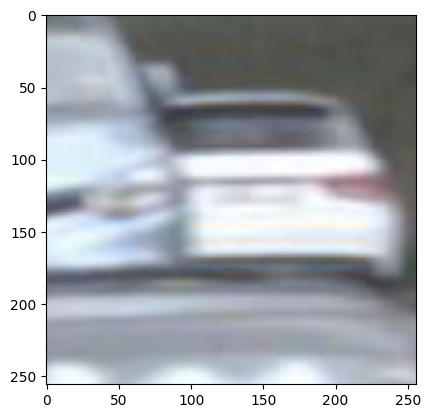

(None, 485)

In [10]:
patch = nusc_val[idx].patch.permute(1,2,0).numpy()
plt.imshow(patch)
plt.show(), idx

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.1616,  1.3096, 31.4829]]])
point_patch_ndc tensor([[-0.0426,  0.0188,  1.0049]])
points_ndc_recovered in nusc dataloader tensor([[-0.1618,  0.0714,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0002, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-1.1616,  1.3096, 31.4829]]])
point_patch_ndc tensor([[-0.0426,  0.0188,  1.0049]])
points_ndc_recovered in nusc dataloader tensor([[-0.1618,  0.0714,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0002, 1.0000]])


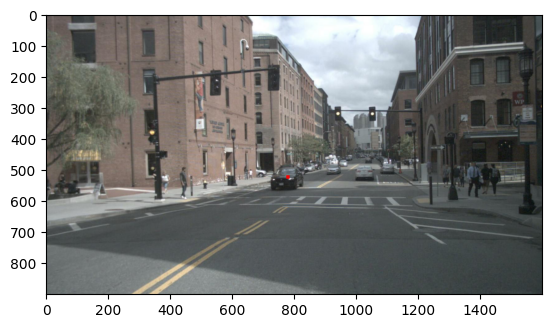

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 6.4561,  1.2829, 40.1558]]])
point_patch_ndc tensor([[0.0606, 0.0069, 1.0316]])
points_ndc_recovered in nusc dataloader tensor([[0.3885, 0.0445, 1.0000]])
point_screen in nusc dataloader tensor([[1.7786, 1.0001, 1.0000]])


(None, tensor([[  0.0453,   0.0484, -13.2301,   0.0000,   0.0000,  -1.4098]]))

In [11]:
# mark patch_center_2d as red on full image
idx = 11
import matplotlib.pyplot as plt

full_img = nusc_val[idx].full_img.permute(1,2,0)

# mark patch_center_2d as red on full image 
patch_center_2d = nusc_val[idx].patch_center_2d # torch.Size([2])

full_img = full_img.numpy()
full_img = full_img.copy() # (900, 1600, 3)

# make patch_center_2d as red with surrounding pixels red

patch_center_2d = patch_center_2d.numpy()
patch_center_2d = patch_center_2d.astype(int)
patch_center_2d = patch_center_2d.tolist()

for i in range(-5, 6):
    for j in range(-5, 6):
        full_img[patch_center_2d[1]+i, patch_center_2d[0]+j, :] = [1,0,0]
        
plt.imshow(full_img)
plt.show(), nusc_val[idx].pose_6d

In [12]:
# visualize 

In [13]:
nusc_val[0].full_img.shape, nusc_val[0].patch.shape

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4016,  1.0755, 72.4430]]])
point_patch_ndc tensor([[ 2.7171e-02, -2.7671e-04,  1.0114e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3022, -0.0031,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4016,  1.0755, 72.4430]]])
point_patch_ndc tensor([[ 2.7171e-02, -2.7671e-04,  1.0114e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3022, -0.0031,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])


(torch.Size([3, 900, 1600]), torch.Size([3, 256, 256]))

In [14]:
nusc_val[0].full_img.min(), nusc_val[0].full_img.max()

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])


(tensor(0.), tensor(1.))

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4016,  1.0755, 72.4430]]])
point_patch_ndc tensor([[ 2.7171e-02, -2.7671e-04,  1.0114e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3022, -0.0031,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])


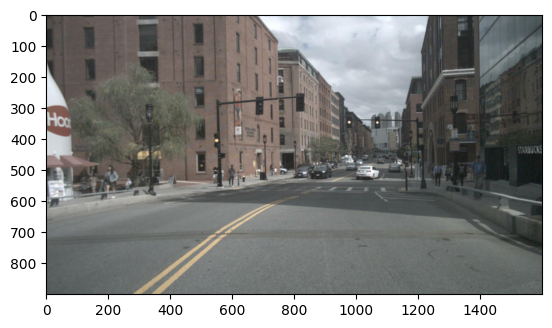

In [15]:
import matplotlib.pyplot as plt
nusc_val[0].full_img.shape # torch.Size([3, 900, 1600])
plt.imshow(nusc_val[0].full_img.permute(1,2,0))


In [16]:
nusc_val[0].patch.min(), nusc_val[0].patch.max()

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4016,  1.0755, 72.4430]]])
point_patch_ndc tensor([[ 2.7171e-02, -2.7671e-04,  1.0114e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3022, -0.0031,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 9.4016,  1.0755, 72.4430]]])
point_patch_ndc tensor([[ 2.7171e-02, -2.7671e-04,  1.0114e+00]])
points_ndc_recovered in nusc dataloader tensor([[ 0.3022, -0.0031,  1.0000]])
point_screen in nusc dataloader tensor([[1.7784, 1.0000, 1.0000]])


(tensor(0.1333), tensor(0.9961))

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3467,  0.7467, 18.7883]]])
point_patch_ndc tensor([[-0.0321,  0.0021,  0.9972]])
points_ndc_recovered in nusc dataloader tensor([[-0.1611,  0.0106,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


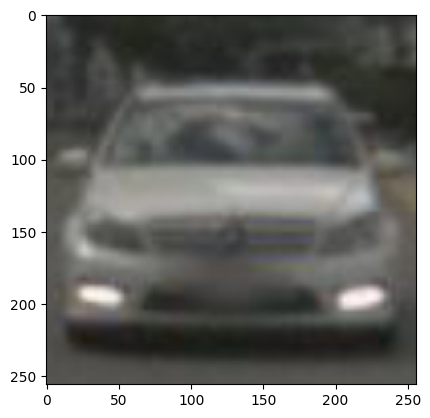

In [17]:
plt.imshow(nusc_val[1].patch.permute(1,2,0))

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 7.1338,  1.2870, 42.4305]]])
point_patch_ndc tensor([[0.0876, 0.0086, 1.0473]])
points_ndc_recovered in nusc dataloader tensor([[0.4090, 0.0400, 1.0000]])
point_screen in nusc dataloader tensor([[1.7787, 1.0001, 1.0000]])


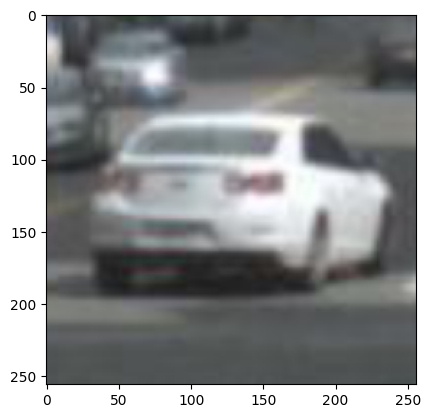

In [18]:
plt.imshow(nusc_val[0].patch.permute(1,2,0))

In [19]:
nusc_val[1].patch.min(), nusc_val[1].patch.max()

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0981,  0.7654, 22.0657]]])
point_patch_ndc tensor([[2.6994e-02, 3.7796e-04, 1.0102e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.1202, 0.0017, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[ 3.0981,  0.7654, 22.0657]]])
point_patch_ndc tensor([[2.6994e-02, 3.7796e-04, 1.0102e+00]])
points_ndc_recovered in nusc dataloader tensor([[0.1202, 0.0017, 1.0000]])
point_screen in nusc dataloader tensor([[1.7780, 1.0000, 1.0000]])


(tensor(0.0588), tensor(0.7451))

In [20]:
nusc_val[1].patch.max(), nusc_val[1].patch.min()

point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3467,  0.7467, 18.7883]]])
point_patch_ndc tensor([[-0.0321,  0.0021,  0.9972]])
points_ndc_recovered in nusc dataloader tensor([[-0.1611,  0.0106,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])
point_ndc device cpu
ndc2patch_transform device cpu
point_camera in nusc dataloader tensor([[[-0.3467,  0.7467, 18.7883]]])
point_patch_ndc tensor([[-0.0321,  0.0021,  0.9972]])
points_ndc_recovered in nusc dataloader tensor([[-0.1611,  0.0106,  1.0000]])
point_screen in nusc dataloader tensor([[1.7774, 1.0000, 1.0000]])


(tensor(1.), tensor(0.0588))